# workbook stroke 2nd itteration

# Goals
* Discover the drivers that increase the risk factor of stroke
* Use drivers to develop a machine learning model to predict weather or not a patient has had a stroke.
* Use findings to see what preventitave measures if any can be taken to decrease the risk of stroke

### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


from sklearn.metrics import recall_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [3]:
# Decision Tree and Model Evaluation Imports
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression



# Acquire
* Data acquired from kaggle on 12-13-2022
    https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?select=healthcare-dataset-stroke-data.csv
* Data contains 5110 rows and 12 columns
* Each row represents a patient and information about the patient
* Each column representa a features related to the patient

In [4]:
def get_stroke_data():
    '''get_stroke_data takes retrives stroke data from csv file saved locally
    input:
        none
    output:
        df - data frame
    '''
    df = pd.read_csv('healthcare-dataset-stroke-data.csv')
    return df

In [5]:
df= get_stroke_data()

# Prepare
prepare actions:
  * removed columns with unnecessary information
  * renamed columns and values
  * 211 null values where found and will be imputed after split
  * Outliers have not been removed
  * Encoded categorical variables
  * Split data into train, validate and test:
        -(Approximately: train 56%, validate 24%, test 20%)

  * impute 211 null values under BMI column with median due to the right skewness of feature 
  
  * Continuous variables will be scaled before modeling.

In [6]:
def dummy(df, columns):
    '''
    dummy_var takes in data frame and column list and creates dummy variables for columns
    appends dummy to main data frame
    
    returns data frame
    '''
    # create dummies
    dummy_df = pd.get_dummies(df[
                                    columns], dummy_na=False)
    
    # Concatenate dummy_df to original data frame
    df = pd.concat([df, dummy_df], axis=1)
    
    return df

In [7]:
def rename_columns_and_values(df):
    ''' 
    rename_columns_and_values renames columns and values 
    returns dataframe
    input:
        df - dataframe
    output:
        df- dataframe
    '''
    # rename column to lowercase 
    df.rename(columns = {'Residence_type':'residence_type'}, inplace=True)
    
    # renames values of smoking status 
    df.smoking_status.replace({'never smoked': 'never_smoked', 'Unknown':'unknown',
                               'formerly smoked':'formely_smoked'},inplace=True)
    return df

In [8]:
def data_prep(df):
    '''
    data_prep takes in a dataframe and prepares for exploration: renames columms, drops unuseful columns
    input:
        df = data frame
    output:
        df = data frame
    '''
    # use rename_columns_and_values functin to rename columns
    df = rename_columns_and_values(df)
    
    # drop columns with unnecessary information
    df.drop(columns = {'id'},inplace=True)
 
    
    # categorical columns that will have dummy variables
    dummy_columns=['gender', 'ever_married','work_type', 'residence_type','smoking_status']
    
    # use dummy function to get dummy columns
    df = dummy(df, dummy_columns)
    
    return df


In [9]:
df = data_prep(df)

In [10]:
df.head()

gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0             0              1          Yes        Private   
1  Female  61.0             0              0          Yes  Self-employed   
2    Male  80.0             0              1          Yes        Private   
3  Female  49.0             0              0          Yes        Private   
4  Female  79.0             1              0          Yes  Self-employed   

  residence_type  avg_glucose_level   bmi  smoking_status  ...  \
0          Urban             228.69  36.6  formely_smoked  ...   
1          Rural             202.21   NaN    never_smoked  ...   
2          Rural             105.92  32.5    never_smoked  ...   
3          Urban             171.23  34.4          smokes  ...   
4          Rural             174.12  24.0    never_smoked  ...   

   work_type_Never_worked  work_type_Private  work_type_Self-employed  \
0                       0                  1                        0   
1                       0                  0                        1   
2                       0                  1                        0   
3                       0                  1                        0   
4                       0                  0                        1   

   work_type_children  residence_type_Rural  residence_type_Urban  \
0                   0                     0                     1   
1                   0                     1                     0   
2                   0                     1                     0   
3                   0                     0                     1   
4                   0                     1                     0   

   smoking_status_formely_smoked  smoking_status_never_smoked  \
0                              1                            0   
1                              0                            1   
2                              0                            1   
3                              0                            0   
4                              0                            1   

   smoking_status_smokes  smoking_status_unknown  
0                      0                       0  
1                      0                       0  
2                      0                       0  
3                      1                       0  
4                      0                       0  

[5 rows x 27 columns]

In [11]:
df.shape

(5110, 27)

In [12]:
def impute_bmi_median(train, validate, test):
    '''
    Takes in train, validate, and test, and uses train to identify the best value to replace nulls in embark_town
    Imputes that value into all three sets and returns all three sets
    '''
    imputer = SimpleImputer(missing_values = np.nan, strategy='median')
    train[['bmi']] = imputer.fit_transform(train[['bmi']])
    validate[['bmi']] = imputer.transform(validate[['bmi']])
    test[['bmi']] = imputer.transform(test[['bmi']])
    return train, validate, test

In [13]:
def split_and_impute_data(df, target):
    '''
    split_date takes in a dataframe  and target variable and splits into train , validate, test 
    and stratifies on target variable
    
    The split is 20% test 80% train/validate. Then 30% of 80% validate and 70% of 80% train.
    Aproximately (train 56%, validate 24%, test 20%)
    
    returns train, validate, and test 
    '''
    # split test data from train/validate
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123, 
                                        stratify=df[target])

    # split train from validate
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate[target])
    # use impute_bmi_median function to fill in nulls in bmi columns after data split
    train, validate, test =impute_bmi_median(train, validate, test)
                                   
    return train, validate, test

In [14]:
train, validate, test = split_and_impute_data(df, 'stroke')

# Data Dictionary

| Feature    | Description    | 
| :------------- | -------------: | 
|      id     |   unique identifier      | 
|   gender       |    Gender of patient Male or Female or Other     | 
| age|     age of the patient     | 
|      hypertension    |     If a patient has hypertension  (1 = yes, 0 = no)  | 
|      hear_disease     |     If a patient has any heart diseases  (1 = yes, 0 = no)  | 
|       ever_married   |   If a patient has ever been married (1 = yes, 0 = no)      | 
|    work_type       |    The work type of patient. *Children are under children category     | 
|  residence_type        |     If a patient residence is  rural of urban   | 
|   avg_glucose_level        |    average glucose level in blood     | 
|     bmi     |   body mass index of patient      | 
|   smoking_status       |    smoking status of patient * Unknown represent the information was unavailable     | 
|          |         | 

In [15]:
train.shape, validate.shape, test.shape

((2861, 27), (1227, 27), (1022, 27))

# Explore

In [16]:
pal = sns.color_palette('Blues')
pal.as_hex()[:]

['#dbe9f6', '#bad6eb', '#89bedc', '#539ecd', '#2b7bba', '#0b559f']

In [17]:
pal = sns.color_palette('Blues')
pal.as_hex()

['#dbe9f6', '#bad6eb', '#89bedc', '#539ecd', '#2b7bba', '#0b559f']

# 1. What is the percent of patients who have a stroke?


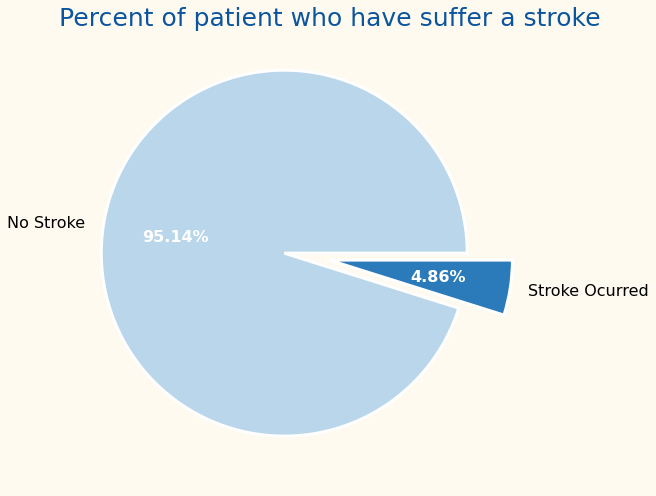

In [132]:
fig, ax = plt.subplots(figsize=(9, 7),facecolor='floralwhite')

sizes = np.array([len(train[train.stroke == 0]), len(train[train.stroke ==1])])
labels = ["No Stroke", "Stroke Ocurred"]
explode = [0.25,0 ]
colors = ['#bad6eb', '#2b7bba']

# Capture each of the return elements.
patches, texts, pcts = ax.pie(
    sizes, labels=labels, autopct='%.2f%%', explode=explode,colors=colors,
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 16})
# Style just the percent values.
plt.setp(pcts, color='white', fontweight='bold')
ax.set_title('Percent of patient who have suffer a stroke', fontsize=25,color='#0b559f')
plt.tight_layout()

***about 5 % of our patients have suffer a stroke***

# 2. Does the presense of hypertension increase the risk of stroke?


In [226]:
def chi_square_test(df,target, feature):    
    '''chi_squre_test takes in a dataframe, target variable and feature 
    to create a crosstab between the target variable and feature and
    perform a chi square test
    returns '''
    alpha = 0.05

    # Setup a crosstab of observed 
    observed = pd.crosstab(train[feature]== 1, train[target])

    t_stat, p_val, degf, expected = stats.chi2_contingency(observed)


    print(f' Chi-Square:{t_stat}')
    print(f' p-value:{p_val}')

In [188]:
train.hypertension.mean()

0.09786787836420832

<AxesSubplot:xlabel='hypertension', ylabel='count'>

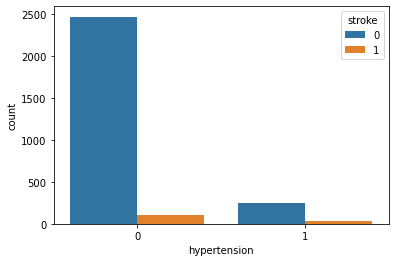

In [189]:
sns.countplot(x='hypertension',data=train, hue = 'stroke')

In [ ]:
train.hypertension

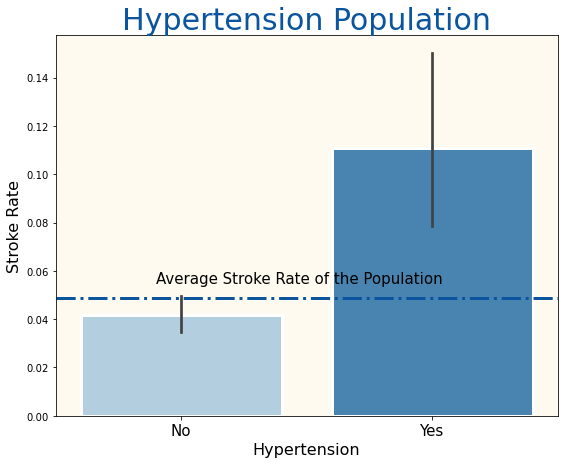

In [312]:
fig, ax = plt.subplots(figsize=(9, 7))
ax=sns.barplot(x="hypertension", y='stroke', data=train, palette='Blues',edgecolor='white',linewidth=3)
mean_line = train.stroke.mean()
plt.axhline(mean_line, label='Stroke Rate', color='#0b559f',linestyle='-.', linewidth=3)

ax.set(facecolor='floralwhite')
ax.set_xlabel('Hypertension', fontsize=16)
ax.set_ylabel('Stroke Rate', fontsize=16)
ax.set_title('Hypertension Population', fontsize=30,color='#0b559f')

ax.set_xticklabels(['No','Yes'],fontsize=15)
plt.text(-.1, .055, 'Average Stroke Rate of the Population', fontsize = 15,color='black',rotation=0)
plt.show()

***It appears that patients with hypertension tend to have a higher stroke rate thatn patients without hyprtension***

### I will now conduct a chi-square test to determine if there is an association between hypertension  and stroke.

* The confidence interval is 95%
* Alpha is set to 0.05

$H_0$ : Hypertension is **independent**   of stroke.

$H_a$: Hypertension is **dependent** of stroke.

In [228]:
chi_square_test(train,'stroke', 'hypertension')

 Chi-Square:24.45069324334392
 p-value:7.623607564219725e-07


The p-value is less than alpha. There is evidence to support that hypertention has an association with stroke. I believe that hypertention is a driver of stroke. Adding an encoded version of this feature to the model will likely increase the mode's accuracy.

In [238]:
observed = pd.crosstab(train['hypertension']==1, train.stroke)

In [239]:
observed

stroke           0    1
hypertension           
False         2473  108
True           249   31

In [240]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [241]:
expected

array([[2455.60363509,  125.39636491],
       [ 266.39636491,   13.60363509]])

# 3. Controling for gender of a patient, does hypertension increases risk of stroke?

### * note
subset female then subset male test 

hypertension vs stroke use female

then male

null_hypothesis = "survival and pclass are independent for female passengers"
alternative_hypothesis = "survival and pclass are dependent for female passengers"

alpha = 0.05
observed = pd.crosstab(female_subset.survived, female_subset.pclass)
chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("Evidence suggests that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("We find insufficient evidence to support the claim that", alternative_hypothesis)



In [251]:
train[train['gender_Male']==1].hypertension.mean()

0.10611205432937182

In [252]:
train[train['gender_Male']==0].hypertension.mean()

0.09209744503862151

In [51]:
train.gender.value_counts()

Female    1682
Male      1178
Other        1
Name: gender, dtype: int64

<AxesSubplot:xlabel='gender', ylabel='count'>

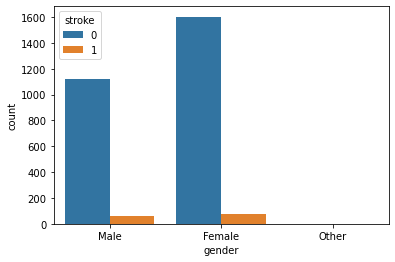

In [258]:
sns.countplot(x='gender',data=train, hue = 'stroke')

[Text(0, 0, 'Female'), Text(1, 0, 'Male')]

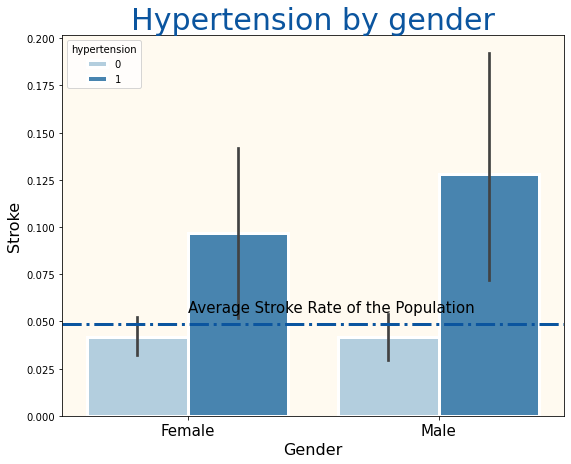

In [307]:
plt.figure(figsize=(9,7))
ax = sns.barplot(data=train, x='gender_Male', y='stroke',hue='hypertension',palette='Blues',
                 edgecolor='white',linewidth=3)
plt.text(0, .055, 'Average Stroke Rate of the Population', fontsize = 15,color='black',rotation=0)
plt.axhline(mean_line, label='Stroke Rate', color='#0b559f',linestyle='-.', linewidth=3)

ax.set(facecolor='floralwhite')
ax.set_xlabel('Gender', fontsize=16)
ax.set_ylabel('Stroke', fontsize=16)
ax.set_title('Hypertension by gender', fontsize=30,color='#0b559f')
ax.set_xticklabels(['Female','Male'],fontsize=15)
#ax.set_yticklabels(labels=labels,fontsize=15);

***It appears that males with hypertension have an above average stroke rate.
Also males with hypertensio have a higher stroke rate than females***

In [267]:
# create subgroups for male and female
male_subset = train[train.gender_Male==1]
female_subset = train[train.gender_Male==0]

### I will now conduct a chi-square test  is the male population with hypertendion associated with stroke.

* The confidence interval is 95%
* Alpha is set to 0.05

$H_0$ : Males with hypertension is **independent**   of stroke.

$H_a$: Males with hypertension is **dependent** of stroke.

In [268]:
chi_square_test(male_subset,'stroke', 'hypertension')



 Chi-Square:24.45069324334392
 p-value:7.623607564219725e-07


The p-value is less than alpha. There is evidence to support that males hypertention has an association with stroke. I believe that hypertention is a driver of stroke. Adding an encoded version of this feature to the model will likely increase the mode's accuracy.

### I will now conduct a chi-square test  is the female population with hypertendion associated with stroke.
* The confidence interval is 95%
* Alpha is set to 0.05

$H_0$ : Females with hypertension is **independent**   of stroke.

$H_a$: Females with hypertension is **dependent** of stroke.

The p-value is less than alpha. There is evidence to support that females with hypertention has an association with stroke. I believe that hypertention is a driver of stroke. Adding an encoded version of this feature to the model will likely increase the mode's accuracy.

In [272]:
chi_square_test(female_subset,'stroke', 'hypertension')

 Chi-Square:24.45069324334392
 p-value:7.623607564219725e-07


### subgroups of males with hypertension and females and hypertension

In [270]:
male_subset_with_h = train[(train.gender_Male==1) & (train.hypertension==1)]
female_subset_with_h = train[(train.gender_Male==0)& (train.hypertension==1)]

In [ ]:
chi_square_test(male_subset_with_h,'stroke', 'hypertension')

# 4. Is age a driver of stroke?

<AxesSubplot:xlabel='stroke', ylabel='age'>

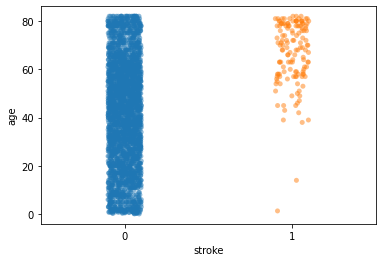

In [349]:
sns.stripplot(data=train,y='age',x='stroke', alpha=0.5,jitter=True )

Text(0.5, 1.0, 'Age vs Stroke')

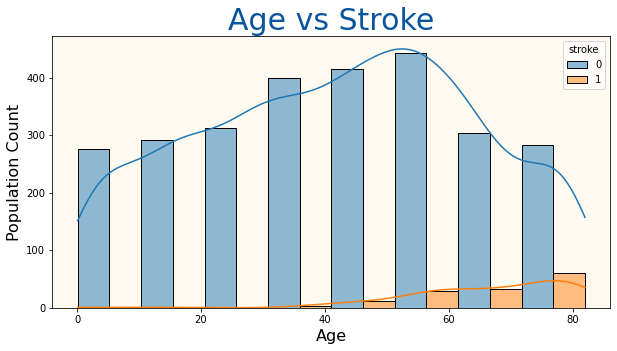

In [311]:
plt.figure(figsize=(10,5))

ax= sns.histplot(x='age', data=train, hue='stroke',multiple='dodge', kde= True, bins = 8,)
ax.set(facecolor='floralwhite')
ax.set_xlabel('Age', fontsize=16)
ax.set_ylabel('Population Count', fontsize=16)
ax.set_title('Age vs Stroke', fontsize=30,color='#0b559f')
#ax.set_yticklabels([0,100,200,300,400,500],fontsize=15)
#ax.set_xticklabels([0,20,40,60,80],fontsize=15);

***It seems that with as our patients age increases so does the instances the occurance of a stroke.***

### I will conduct a t-test to determine if the population who has suffer a stroke has a higher mean age thatn the population who has not had a stoke occurance.
* The confidence interval is 95%
* Alpha is set to 0.05
* This will be a two-tail Independent t-test

$H_0$ : The mean age of patients who have suffer a stroke <= to the mean age of patients who have not suffer a stroke

$H_a$: The mean age of patients who have suffer a stroke > to the mean age of patients who have not suffer a stroke


In [275]:
def two_tail_ttest(df,target, continuous_feature):
    
    # create two independent sample group of customers: churn and not churn.
    subset_feature =df[df[target]==1]
    subset_no_feature = df[df[target] == 0]

    # # stats Levene test - returns p value. small p-value means unequal variances
    stat, pval =stats.levene( subset_feature[continuous_feature], subset_no_feature[continuous_feature])
 

    # high p-value suggests that the populations have equal variances
    if pval < 0.05:
        variance = False

    else:
        variance = True

    
    # perform t-test
    t_stat, p_val = stats.ttest_ind(subset_feature[continuous_feature], subset_no_feature[continuous_feature],
                                    equal_var=variance,random_state=123)

    # round  and print results
    #t_stat = t_stat.round(4)
    #p_val = (p_val.round(4))/2
    print(f't-stat {t_stat}')
    print(f'p-value {p_val/2}')


In [276]:
two_tail_ttest(train,'stroke','age')

t-stat 20.108050826301564
p-value 5.1422688960466496e-48


The p-value/2 is less than the alpha. There is evidence to support that patients who suffer a stroke  on average are older than patients who have not suffer a stroke. Based on this statistical finding I believe that age is a driver of stroke. Adding an scaled version of this feature to the model will likely increase the model ability to predict home value.

# 5. Is a higher level of glucose and indicator of stroke risk?

Text(0.5, 1.0, 'glucose vs Stroke')

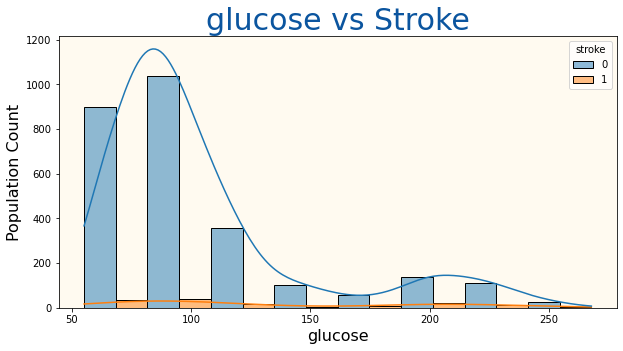

In [352]:
plt.figure(figsize=(10,5))

ax= sns.histplot(x='avg_glucose_level', data=train, hue='stroke',multiple='dodge', kde= True, bins = 8,)
ax.set(facecolor='floralwhite')
ax.set_xlabel('glucose', fontsize=16)
ax.set_ylabel('Population Count', fontsize=16)
ax.set_title('glucose vs Stroke', fontsize=30,color='#0b559f')
#ax.set_yticklabels([0,100,200,300,400,500],fontsize=15)
#ax.set_xticklabels([0,20,40,60,80],fontsize=15);

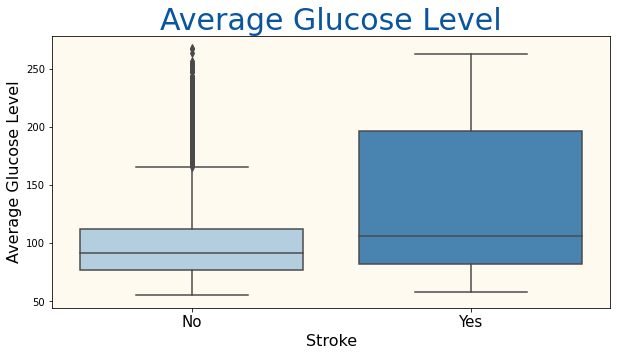

In [313]:

plt.figure(figsize=(10,5))

ax= sns.boxplot(data= train, y='avg_glucose_level',x='stroke',palette='Blues')
ax.set(facecolor='floralwhite')
ax.set_xlabel('Stroke', fontsize=16)

ax.set_ylabel('Average Glucose Level', fontsize=16)
ax.set_title('Average Glucose Level', fontsize=30,color='#0b559f')
#ax.set_yticklabels([0,50,100,150,200,250],fontsize=15)
ax.set_xticklabels(['No','Yes'],fontsize=15);

### I will conduct a t-test to determine if the population who has suffer a stroke has a higher mean age thatn the population who has not had a stoke occurance.
* The confidence interval is 95%
* Alpha is set to 0.05
* This will be a two-tail Independent t-test

$H_0$ : The mean glucose level of patients who have suffer a stroke <= to the mean glucose level of patients who have not suffer a stroke

$H_a$: The mean glucose level of patients who have suffer a stroke > to the mean glucose level of patients who have not suffer a stroke

In [278]:
two_tail_ttest(train,'stroke','avg_glucose_level')

t-stat 5.301265869210943
p-value 2.0926420182845606e-07


The p-value/2 is less than the alpha. There is evidence to support that patients who suffer a stroke have on average  a higher mean glucose level. Based on this statistical finding I believe that age is a driver of stroke .Adding an scaled version of this feature to the model will likely increase the model ability to predict home value.

### note
A blood sugar level less than 140 mg/dL (7.8 mmol/L) is normal. A reading of more than 200 mg/dL (11.1 mmol/L) after two hours means you have diabetes. A reading between 140 and 199 mg/dL (7.8 mmol/L and 11.0 mmol/L) means you have prediabetes.

If your BMI is 18.5 to 24.9, it falls within the normal or Healthy Weight range. If your BMI is 25.0 to 29.9, it falls within the overweight range. If your BMI is 30.0 or higher, it falls within the obese range.

# Do people who have no cronic disease suffer strokes less than the population?

In [317]:
healthy_subset = train[(train.hypertension==0)&(train.heart_disease==0)&(train.avg_glucose_level<140)& (train.smoking_status== 'never_smoked')]

In [321]:
healthy_subset.stroke.median()

0.0

In [320]:
train.stroke.median()

0.0

<AxesSubplot:xlabel='age', ylabel='Count'>

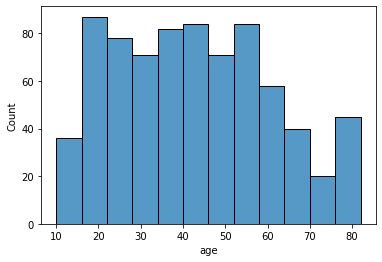

In [324]:
sns.histplot(x=healthy_subset.age)

In [327]:
unhealthy_subset = train[(train.hypertension==1)|(train.heart_disease==1)|(train.avg_glucose_level>200)| (train.smoking_status== 'smokes')| (train.smoking_status== 'formely_smokes')]

In [331]:
healthy_subset.stroke.mean(),unhealthy_subset.stroke.mean()

(0.026455026455026454, 0.08361204013377926)

# Do healthy people suffer less strokes?

In [ ]:
sns.box(x='stroke',data)

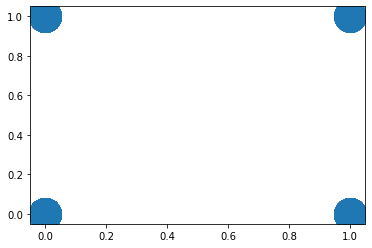

In [357]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
 
# create data

 
# use the scatter function
plt.scatter(data=train,x='stroke', y='heart_disease', s=1000, alpha=0.5)

# show the graph
plt.show()

<AxesSubplot:xlabel='stroke', ylabel='heart_disease'>

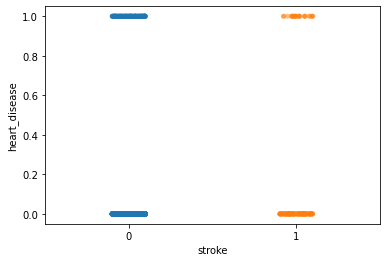

In [354]:
sns.stripplot(data=train,y='heart_disease',x='stroke', alpha=0.5,jitter=True )

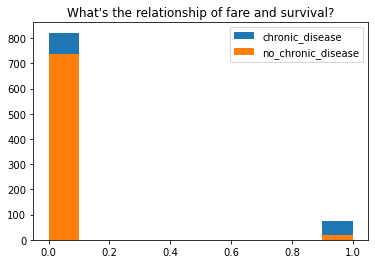

In [333]:
plt.title("What's the relationship of fare and survival?")
plt.hist(unhealthy_subset.stroke, label="chronic_disease")
plt.hist(healthy_subset.stroke, label="no_chronic_disease")

plt.legend()
plt.show()

In [343]:
train.head()

gender           age  hypertension  heart_disease ever_married  \
4600    Male  2.0000000000             0              0           No   
3431  Female 49.0000000000             0              0          Yes   
1557  Female 47.0000000000             0              0          Yes   
3899  Female 68.0000000000             0              0          Yes   
1212  Female 23.0000000000             0              0           No   

          work_type residence_type  avg_glucose_level           bmi  \
4600       children          Rural      65.8400000000 16.1000000000   
3431        Private          Rural     107.5500000000 28.2000000000   
1557  Self-employed          Urban      73.0000000000 20.6000000000   
3899  Self-employed          Urban      71.0800000000 21.5000000000   
1212        Private          Rural      90.8400000000 31.6000000000   

     smoking_status  stroke  gender_Female  gender_Male  gender_Other  \
4600        unknown       0              0            1             0   
3431        unknown       0              1            0             0   
1557   never_smoked       0              1            0             0   
3899   never_smoked       0              1            0             0   
1212   never_smoked       0              1            0             0   

      ever_married_No  ever_married_Yes  work_type_Govt_job  \
4600                1                 0                   0   
3431                0                 1                   0   
1557                0                 1                   0   
3899                0                 1                   0   
1212                1                 0                   0   

      work_type_Never_worked  work_type_Private  work_type_Self-employed  \
4600                       0                  0                        0   
3431                       0                  1                        0   
1557                       0                  0                        1   
3899                       0                  0                        1   
1212                       0                  1                        0   

      work_type_children  residence_type_Rural  residence_type_Urban  \
4600                   1                     1                     0   
3431                   0                     1                     0   
1557                   0                     0                     1   
3899                   0                     0                     1   
1212                   0                     1                     0   

      smoking_status_formely_smoked  smoking_status_never_smoked  \
4600                              0                            0   
3431                              0                            0   
1557                              0                            1   
3899                              0                            1   
1212                              0                            1   

      smoking_status_smokes  smoking_status_unknown  
4600                      0                       1  
3431                      0                       1  
1557                      0                       0  
3899                      0                       0  
1212                      0                       0

In [ ]:
sns.stripplot(cars.weight, cars.origin, alpha=0.5);

In [235]:
pd.set_option('display.max_columns', None)
train[train.bmi>30].describe()


age     hypertension    heart_disease  avg_glucose_level  \
count 1,071.0000000000 1,071.0000000000 1,071.0000000000   1,071.0000000000   
mean     49.3658263305     0.1409897292     0.0634920635     114.6330812325   
std      17.2330889406     0.3481735399     0.2439598168      52.7353854887   
min       0.8000000000     0.0000000000     0.0000000000      55.6400000000   
25%      37.0000000000     0.0000000000     0.0000000000      78.9200000000   
50%      51.0000000000     0.0000000000     0.0000000000      93.7200000000   
75%      62.0000000000     0.0000000000     0.0000000000     127.2500000000   
max      82.0000000000     1.0000000000     1.0000000000     267.6000000000   

                   bmi           stroke    gender_Female      gender_Male  \
count 1,071.0000000000 1,071.0000000000 1,071.0000000000 1,071.0000000000   
mean     36.6899159664     0.0513538749     0.5798319328     0.4201680672   
std       6.6019135637     0.2208216113     0.4938163132     0.4938163132   
min      30.1000000000     0.0000000000     0.0000000000     0.0000000000   
25%      32.1000000000     0.0000000000     0.0000000000     0.0000000000   
50%      34.8000000000     0.0000000000     1.0000000000     0.0000000000   
75%      39.3000000000     0.0000000000     1.0000000000     1.0000000000   
max      97.6000000000     1.0000000000     1.0000000000     1.0000000000   

          gender_Other  ever_married_No  ever_married_Yes  work_type_Govt_job  \
count 1,071.0000000000 1,071.0000000000  1,071.0000000000    1,071.0000000000   
mean      0.0000000000     0.2082166200      0.7917833800        0.1503267974   
std       0.0000000000     0.4062222744      0.4062222744        0.3575584203   
min       0.0000000000     0.0000000000      0.0000000000        0.0000000000   
25%       0.0000000000     0.0000000000      1.0000000000        0.0000000000   
50%       0.0000000000     0.0000000000      1.0000000000        0.0000000000   
75%       0.0000000000     0.0000000000      1.0000000000        0.0000000000   
max       0.0000000000     1.0000000000      1.0000000000        1.0000000000   

       work_type_Never_worked  work_type_Private  work_type_Self-employed  \
count        1,071.0000000000   1,071.0000000000         1,071.0000000000   
mean             0.0037348273       0.6517273576             0.1820728291   
std              0.0610275002       0.4766455063             0.3860848272   
min              0.0000000000       0.0000000000             0.0000000000   
25%              0.0000000000       0.0000000000             0.0000000000   
50%              0.0000000000       1.0000000000             0.0000000000   
75%              0.0000000000       1.0000000000             0.0000000000   
max              1.0000000000       1.0000000000             1.0000000000   

       work_type_children  residence_type_Rural  residence_type_Urban  \
count    1,071.0000000000      1,071.0000000000      1,071.0000000000   
mean         0.0121381886          0.4864612512          0.5135387488   
std          0.1095539109          0.5000501733          0.5000501733   
min          0.0000000000          0.0000000000          0.0000000000   
25%          0.0000000000          0.0000000000          0.0000000000   
50%          0.0000000000          0.0000000000          1.0000000000   
75%          0.0000000000          1.0000000000          1.0000000000   
max          1.0000000000          1.0000000000          1.0000000000   

       smoking_status_formely_smoked  smoking_status_never_smoked  \
count               1,071.0000000000             1,071.0000000000   
mean                    0.2250233427                 0.4154995331   
std                     0.4177927922                 0.4930381758   
min                     0.0000000000                 0.0000000000   
25%                     0.0000000000                 0.0000000000   
50%                     0.0000000000                 0.0000000000   
75%                     0.0000000000            

In [237]:
train[train.avg_glucose_level>200].describe()

age   hypertension  heart_disease  avg_glucose_level  \
count 252.0000000000 252.0000000000 252.0000000000     252.0000000000   
mean   60.7896825397   0.2658730159   0.1706349206     221.6258730159   
std    15.3254018197   0.4426761604   0.3769382758      15.5907642121   
min    12.0000000000   0.0000000000   0.0000000000     200.1400000000   
25%    52.0000000000   0.0000000000   0.0000000000     208.1425000000   
50%    61.5000000000   0.0000000000   0.0000000000     219.0150000000   
75%    73.2500000000   1.0000000000   0.0000000000     231.7125000000   
max    82.0000000000   1.0000000000   1.0000000000     267.7600000000   

                 bmi         stroke  gender_Female    gender_Male  \
count 252.0000000000 252.0000000000 252.0000000000 252.0000000000   
mean   33.2853174603   0.1230158730   0.5198412698   0.4801587302   
std     7.3324079179   0.3291090710   0.5006004110   0.5006004110   
min    15.7000000000   0.0000000000   0.0000000000   0.0000000000   
25%    28.2000000000   0.0000000000   0.0000000000   0.0000000000   
50%    31.7500000000   0.0000000000   1.0000000000   0.0000000000   
75%    37.3250000000   0.0000000000   1.0000000000   1.0000000000   
max    58.1000000000   1.0000000000   1.0000000000   1.0000000000   

        gender_Other  ever_married_No  ever_married_Yes  work_type_Govt_job  \
count 252.0000000000   252.0000000000    252.0000000000      252.0000000000   
mean    0.0000000000     0.1071428571      0.8928571429        0.1428571429   
std     0.0000000000     0.3099102997      0.3099102997        0.3506234792   
min     0.0000000000     0.0000000000      0.0000000000        0.0000000000   
25%     0.0000000000     0.0000000000      1.0000000000        0.0000000000   
50%     0.0000000000     0.0000000000      1.0000000000        0.0000000000   
75%     0.0000000000     0.0000000000      1.0000000000        0.0000000000   
max     0.0000000000     1.0000000000      1.0000000000        1.0000000000   

       work_type_Never_worked  work_type_Private  work_type_Self-employed  \
count          252.0000000000     252.0000000000           252.0000000000   
mean             0.0000000000       0.6468253968             0.1984126984   
std              0.0000000000       0.4789075397             0.3995982299   
min              0.0000000000       0.0000000000             0.0000000000   
25%              0.0000000000       0.0000000000             0.0000000000   
50%              0.0000000000       1.0000000000             0.0000000000   
75%              0.0000000000       1.0000000000             0.0000000000   
max              0.0000000000       1.0000000000             1.0000000000   

       work_type_children  residence_type_Rural  residence_type_Urban  \
count      252.0000000000        252.0000000000        252.0000000000   
mean         0.0119047619          0.4682539683          0.5317460317   
std          0.1086733787          0.4999841900          0.4999841900   
min          0.0000000000          0.0000000000          0.0000000000   
25%          0.0000000000          0.0000000000          0.0000000000   
50%          0.0000000000          0.0000000000          1.0000000000   
75%          0.0000000000          1.0000000000          1.0000000000   
max          1.0000000000          1.0000000000          1.0000000000   

       smoking_status_formely_smoked  smoking_status_never_smoked  \
count                 252.0000000000               252.0000000000   
mean                    0.2738095238                 0.4404761905   
std                     0.4467997887                 0.4974322227   
min                     0.0000000000                 0.0000000000   
25%                     0.0000000000                 0.0000000000   
50%                     0.0000000000                 0.0000000000   
75%                     1.0000000000                 1.0000000000   
max                     1.0000000000                 1.0000000000   

       smoking_status_smokes  smoking_status_unknow

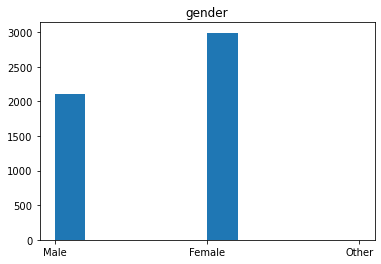

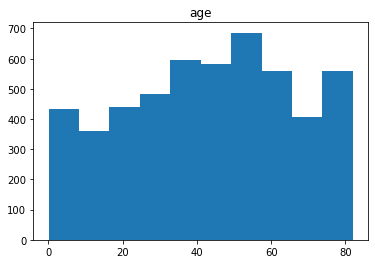

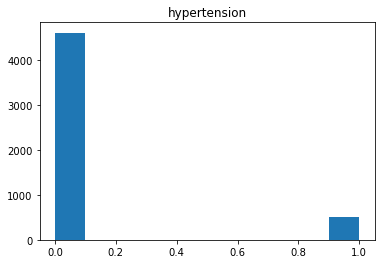

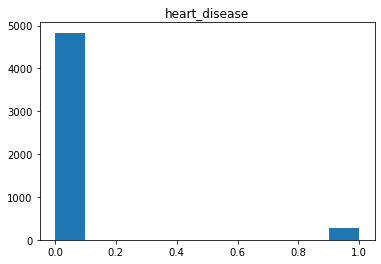

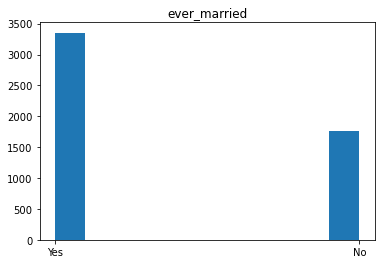

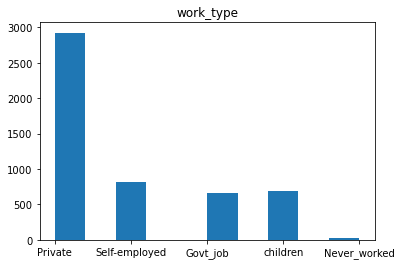

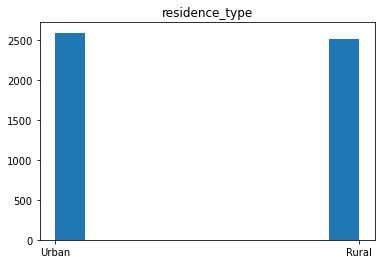

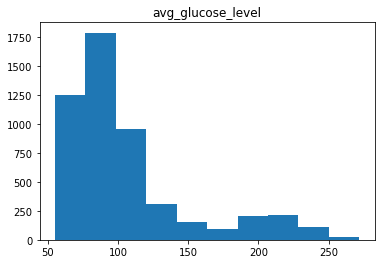

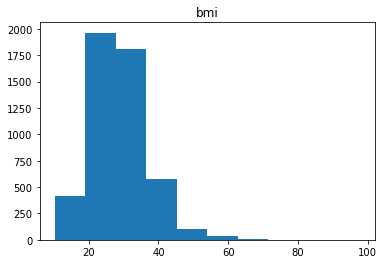

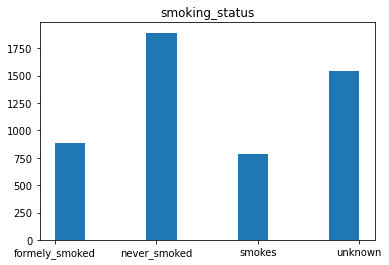

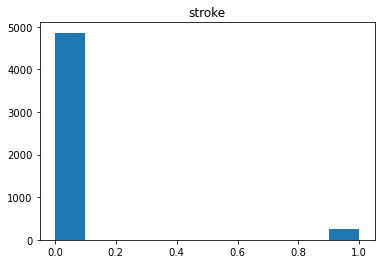

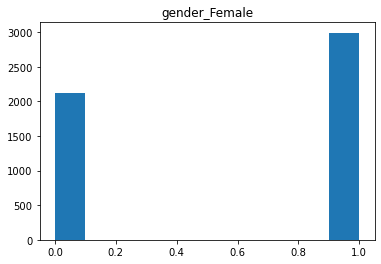

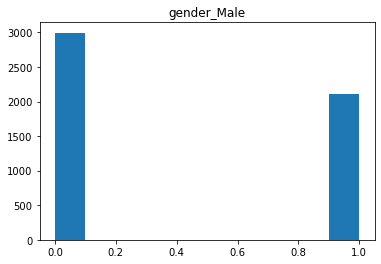

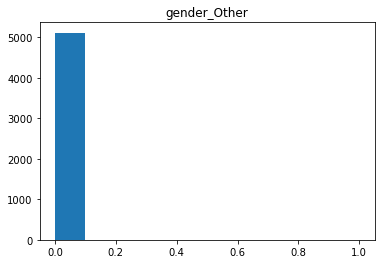

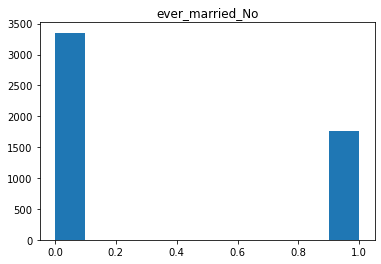

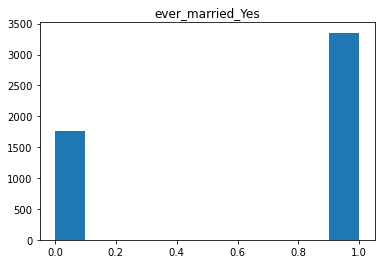

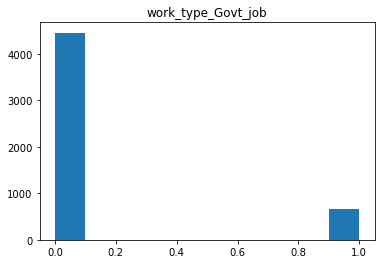

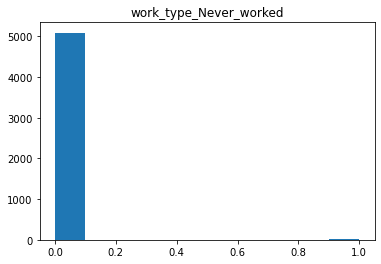

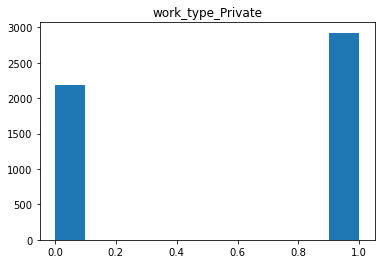

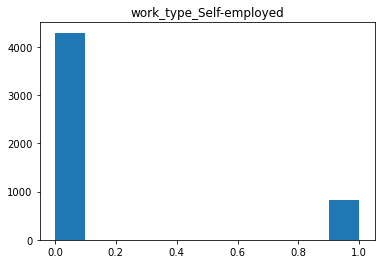

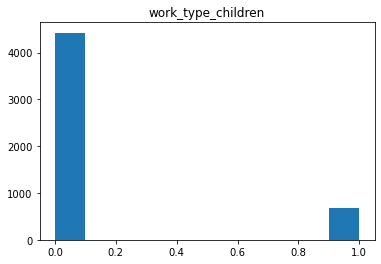

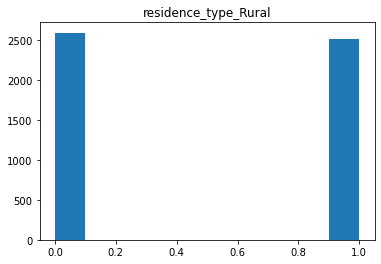

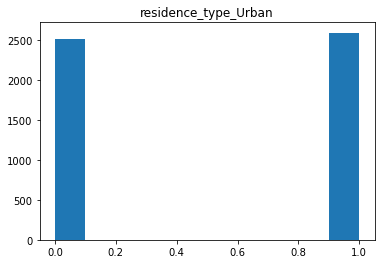

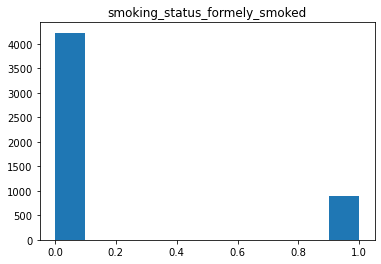

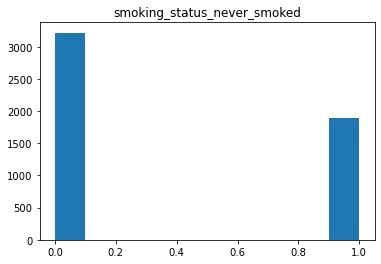

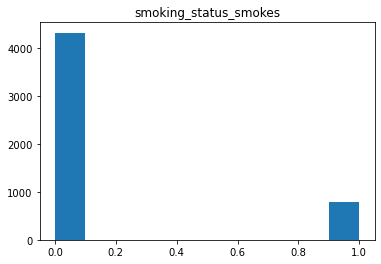

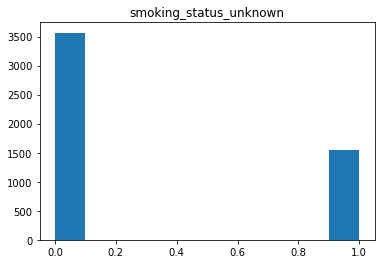

In [19]:
num_cols = train.columns
for col in num_cols:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

In [20]:
train.shape

(2861, 27)

In [21]:
features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level',
       'smoking_status','bmi']

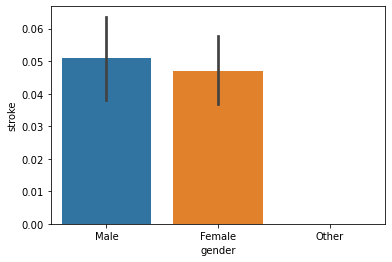

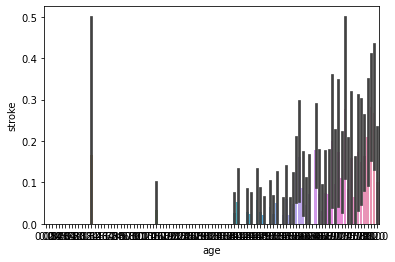

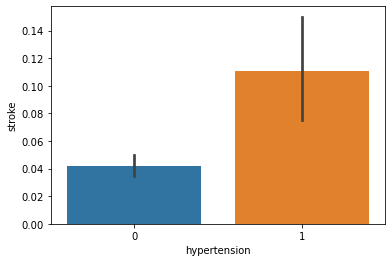

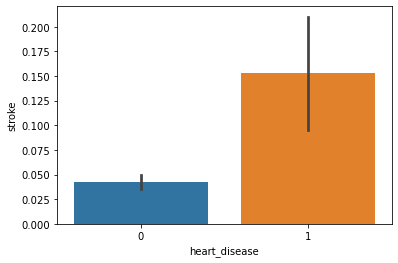

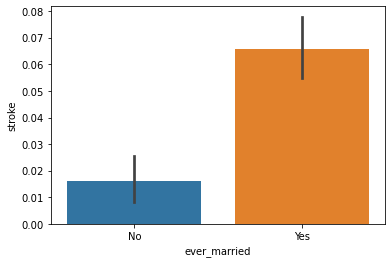

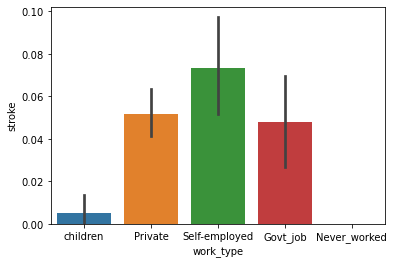

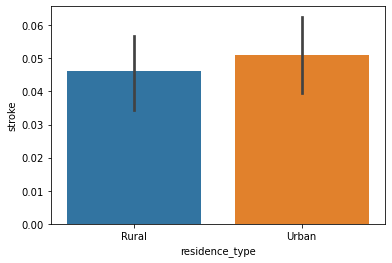

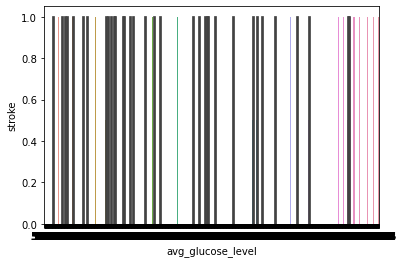

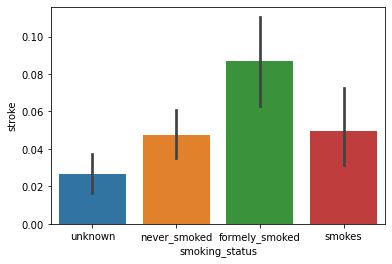

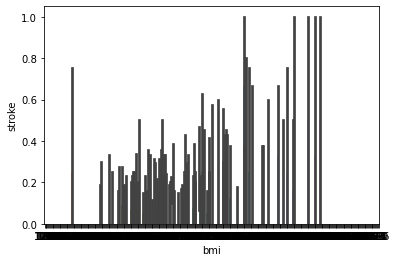

In [22]:
for i in features:
        sns.barplot(x=i, y='stroke', data = train)
        plt.show();

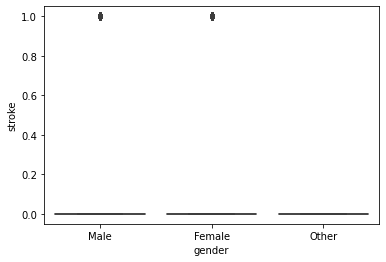

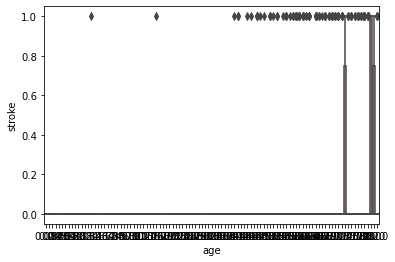

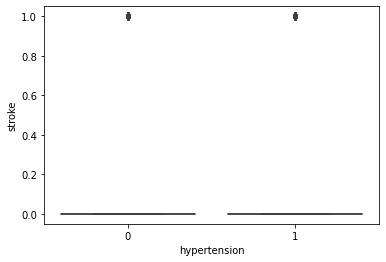

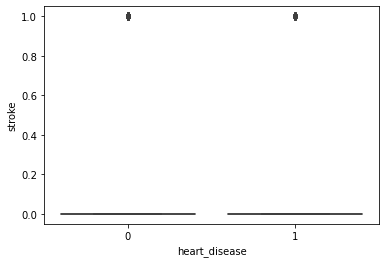

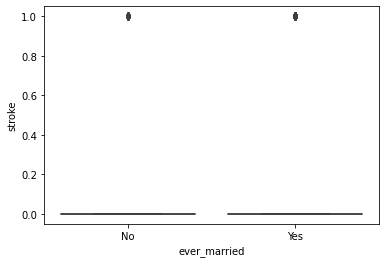

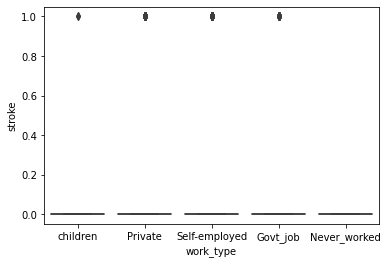

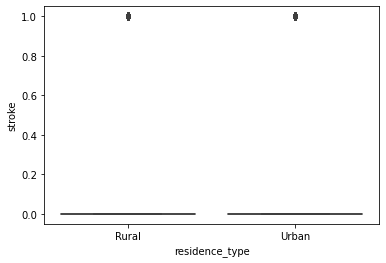

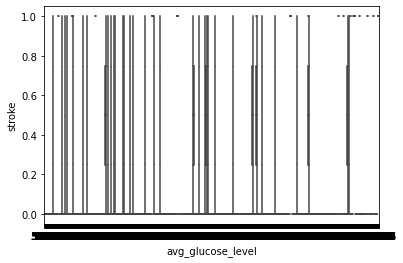

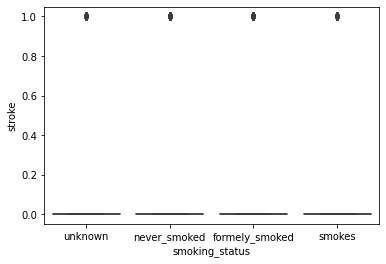

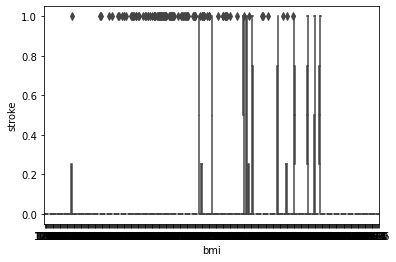

In [23]:
for columns in features:
        sns.boxplot(x=columns, y='stroke', data = train)
        plt.show();

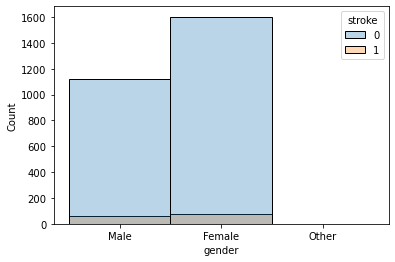

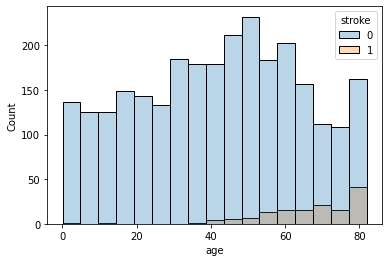

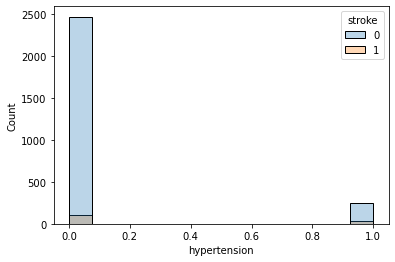

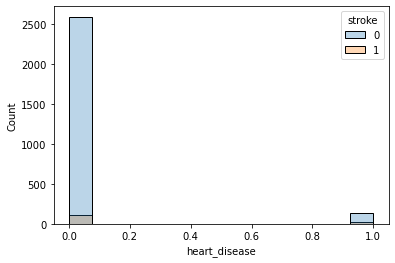

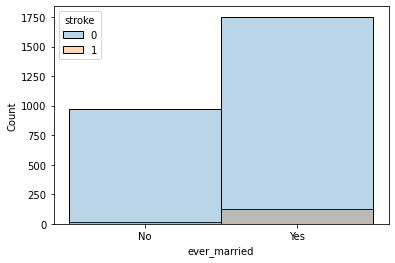

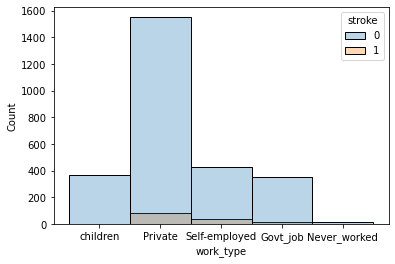

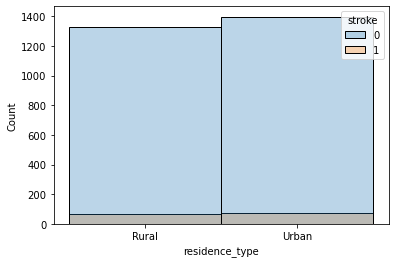

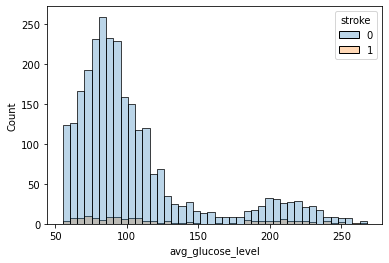

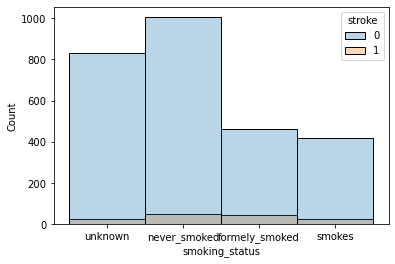

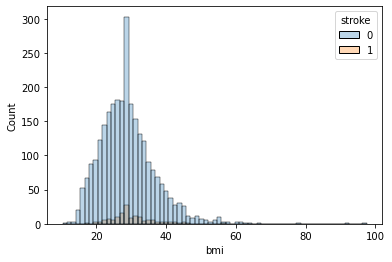

In [24]:
for columns in features:
        sns.histplot(x=columns, data = train,hue='stroke', alpha=0.3)
        plt.show();

# Columns

In [25]:
categorical = ['gender', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 
       'smoking_status', 'stroke']
continuous =['age','avg_glucose_level', 'bmi']

In [26]:
def plot_variable_pair(df,columns):

    for i, col in enumerate(columns):
        sns.lmplot(data=df, x=col, y='stroke', line_kws={'color':'red'})
        plt.show()

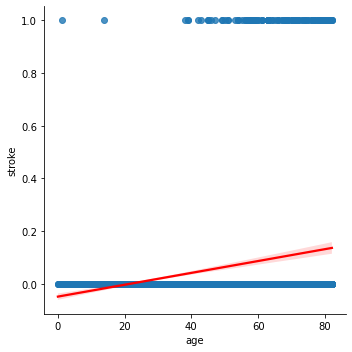

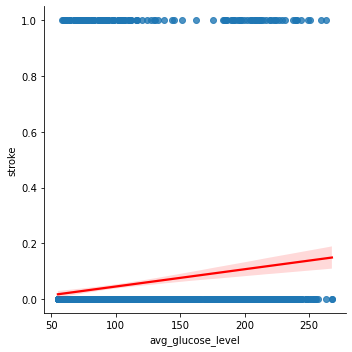

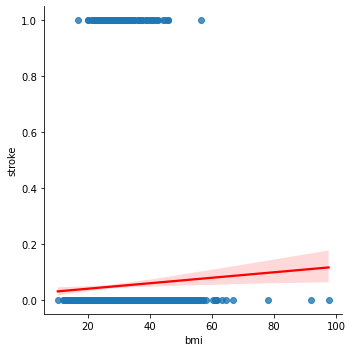

In [27]:
plot_variable_pair(train,continuous)

In [28]:
def plot_categorical_and_continuous_vars2(df):
    categorical =[]
    numerical =[]
    for i in train.columns.to_list():
        if train[i].dtypes == 'O':
            categorical.append(i)
        else:
            numerical.append(i)
    for col in categorical:
        for col2 in numerical:
            fig, (ax1, ax2, ax3,ax4) = plt.subplots(1,4, figsize=(25,5))
            fig.suptitle(f'{col} vs. {col2}')
            sns.boxplot(data=df, x=col, y=col2, ax=ax1)
            sns.violinplot(data=df, x=col, y=col2, ax=ax2)
            sns.barplot(data=df, x=col, y=col2, ax=ax3)
            sns.scatterplot(data=df, x=col, y=col2, ax=ax4)
            plt.show()

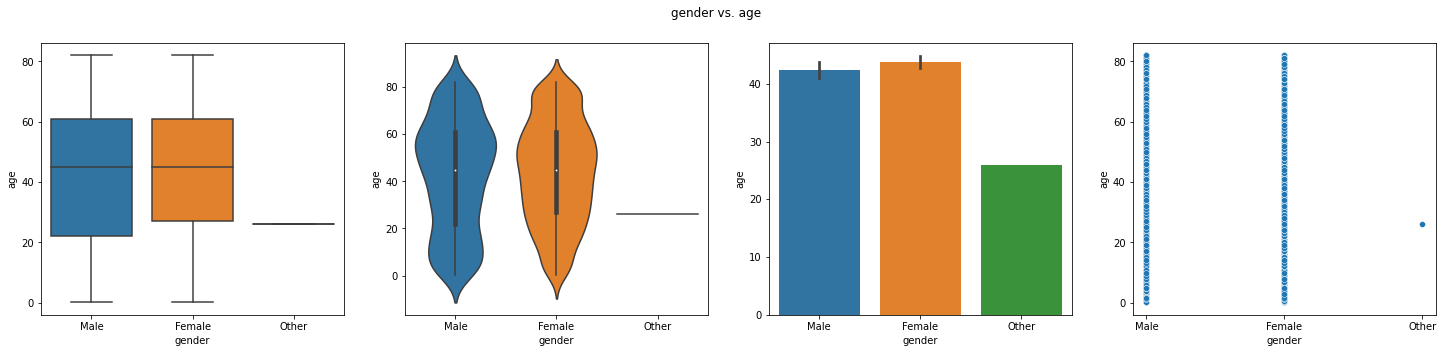

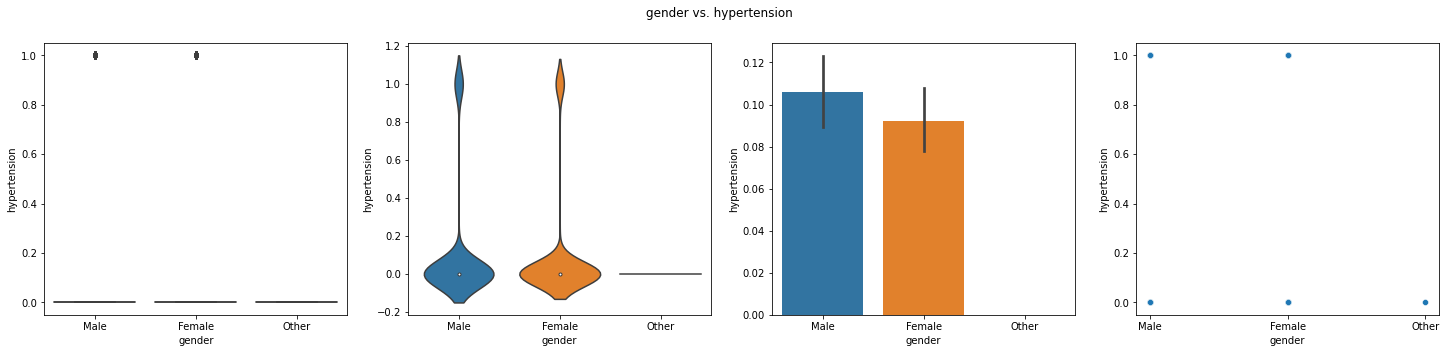

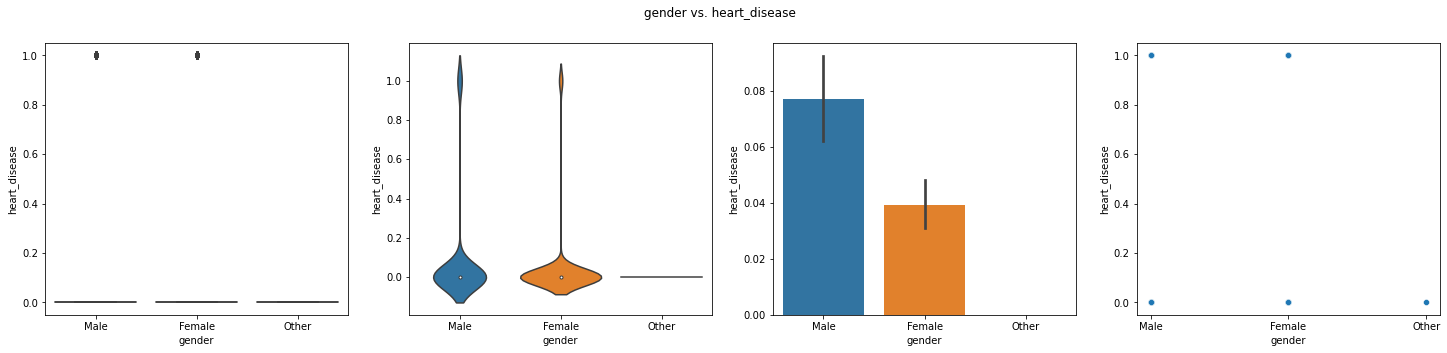

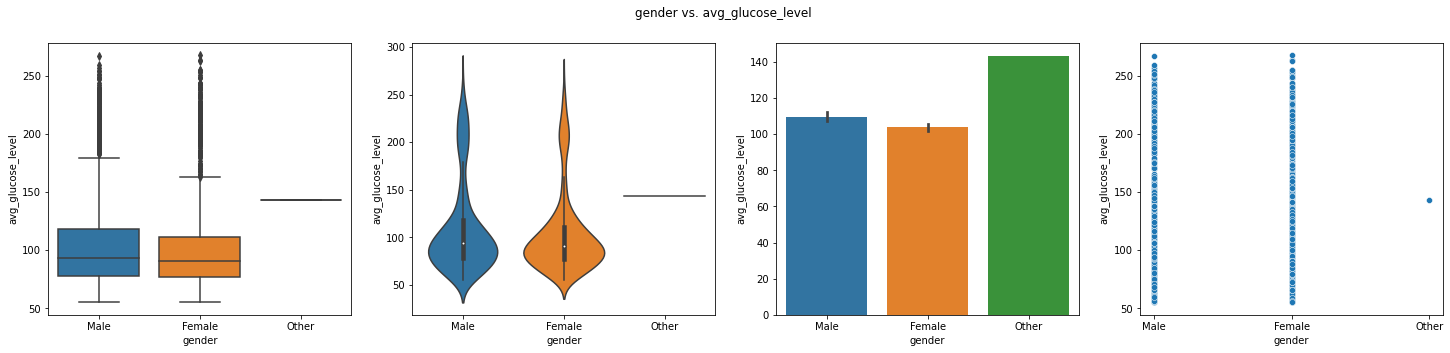

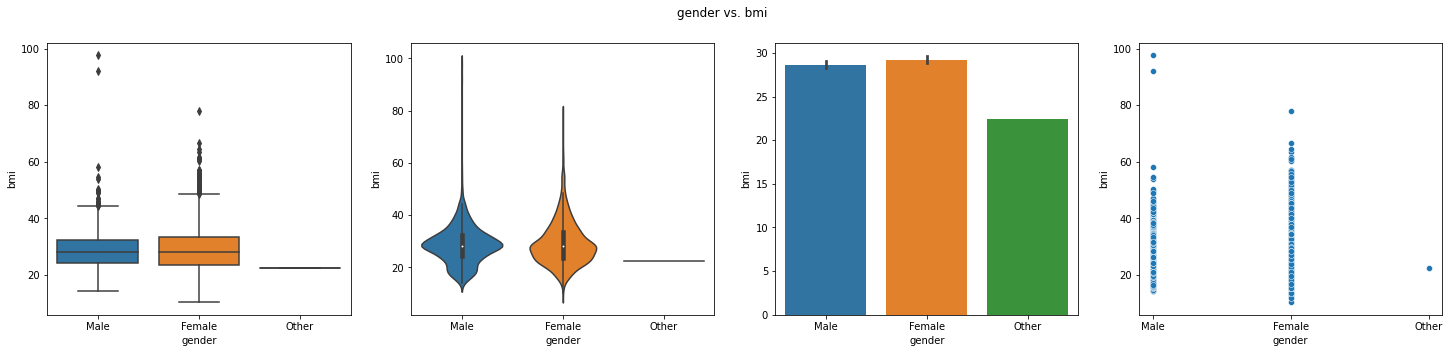

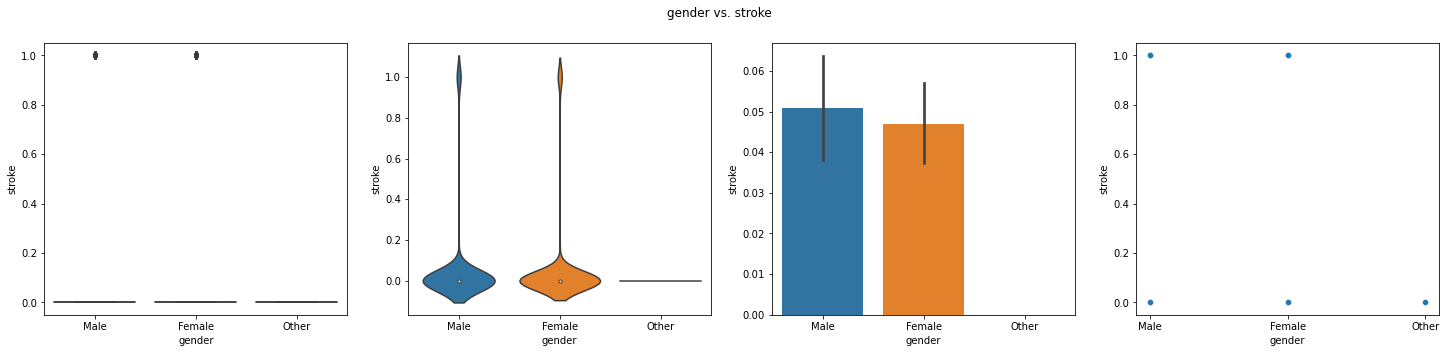

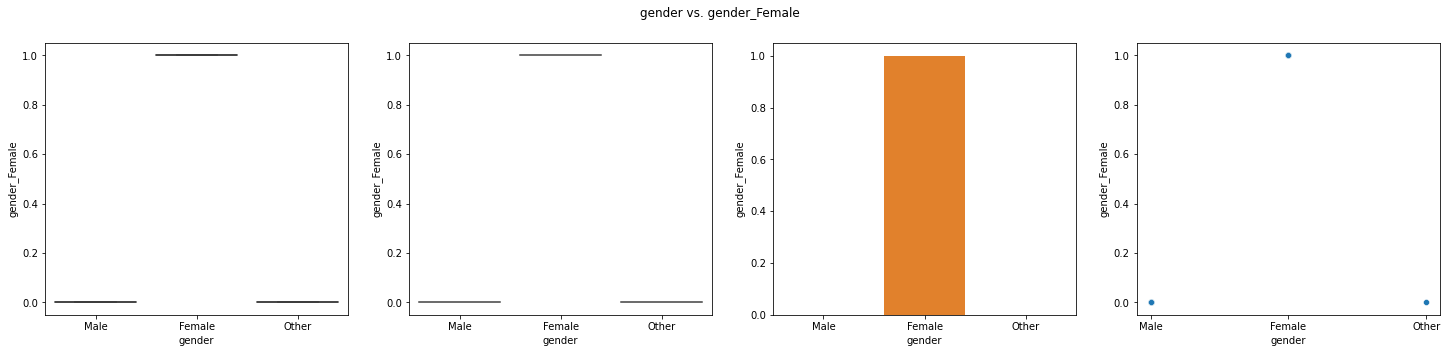

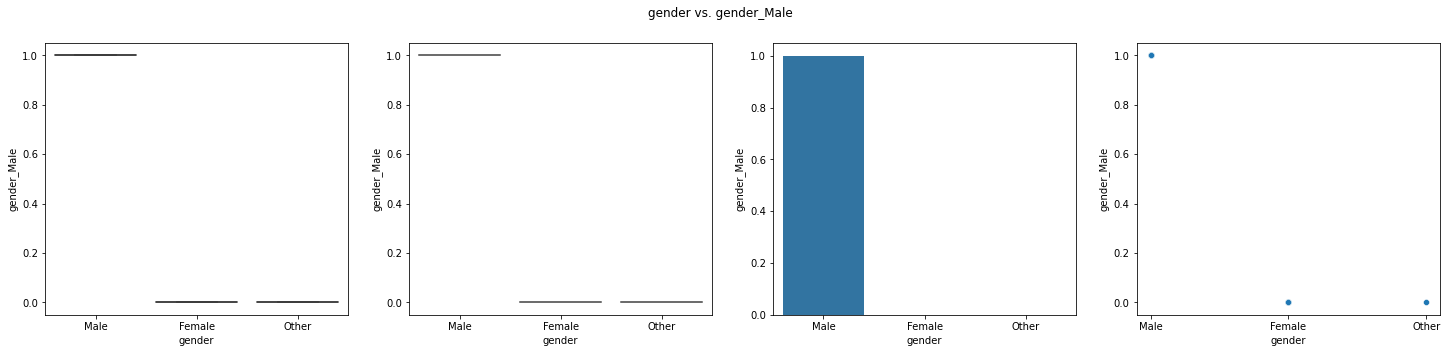

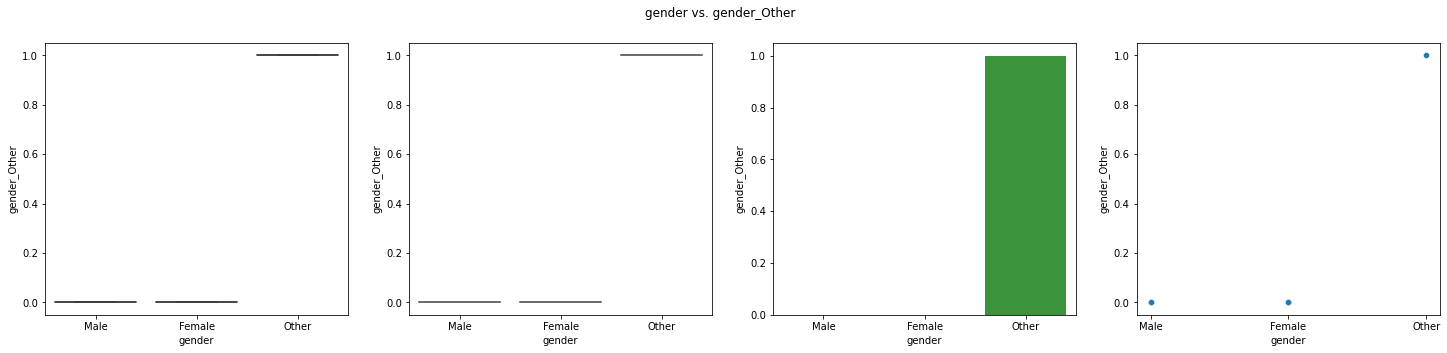

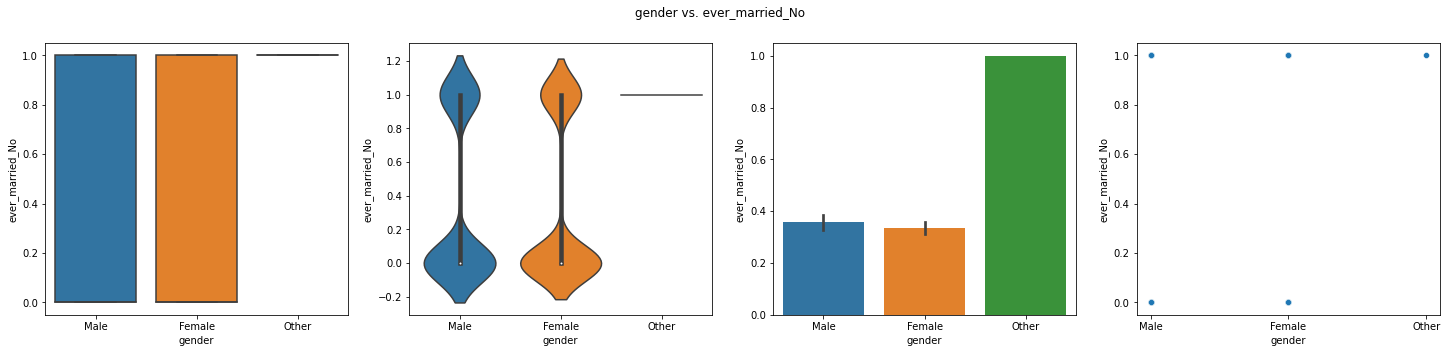

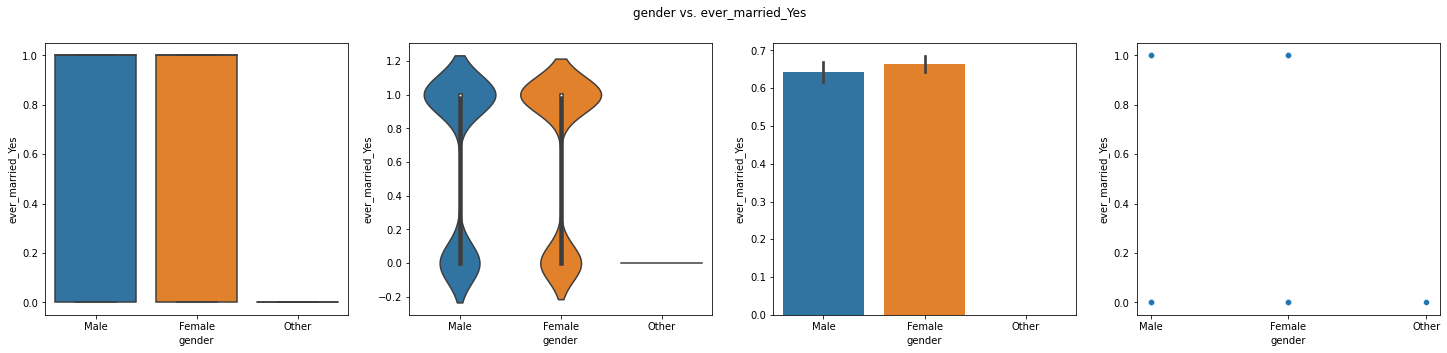

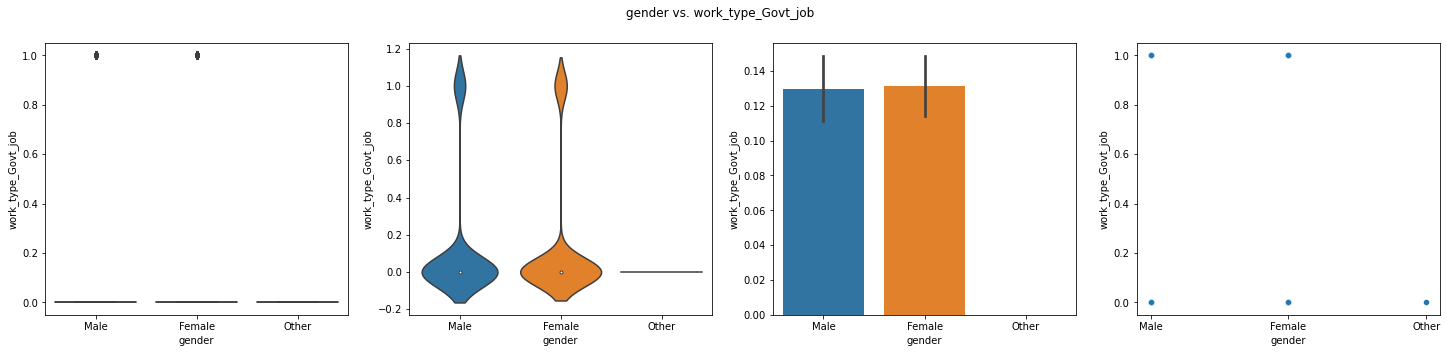

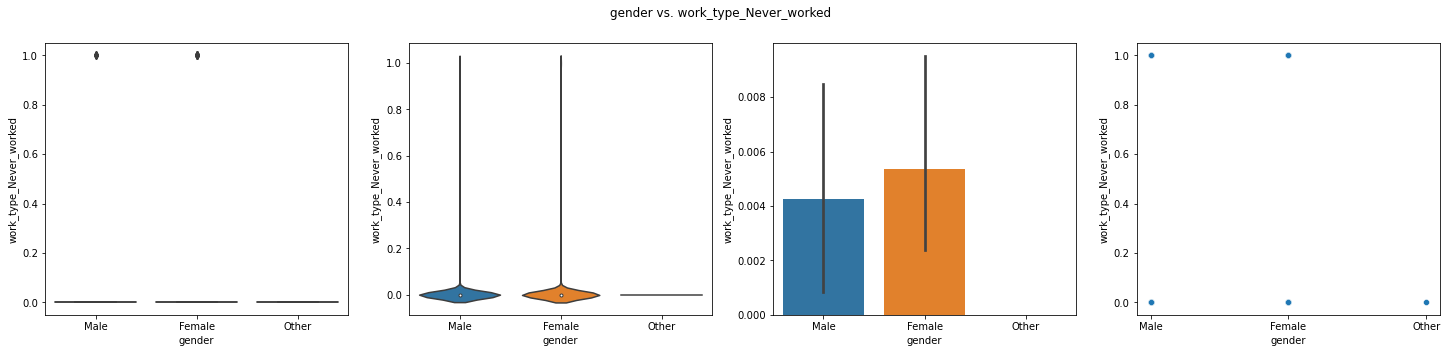

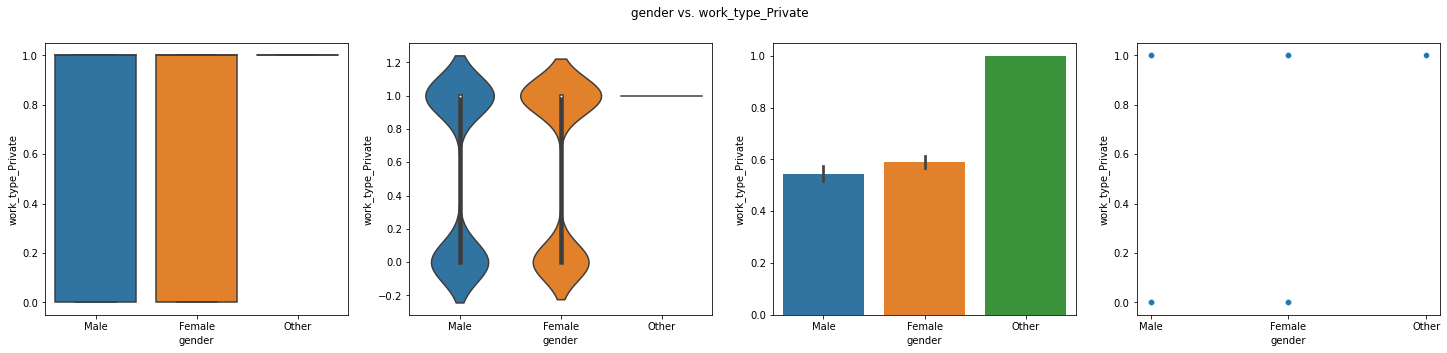

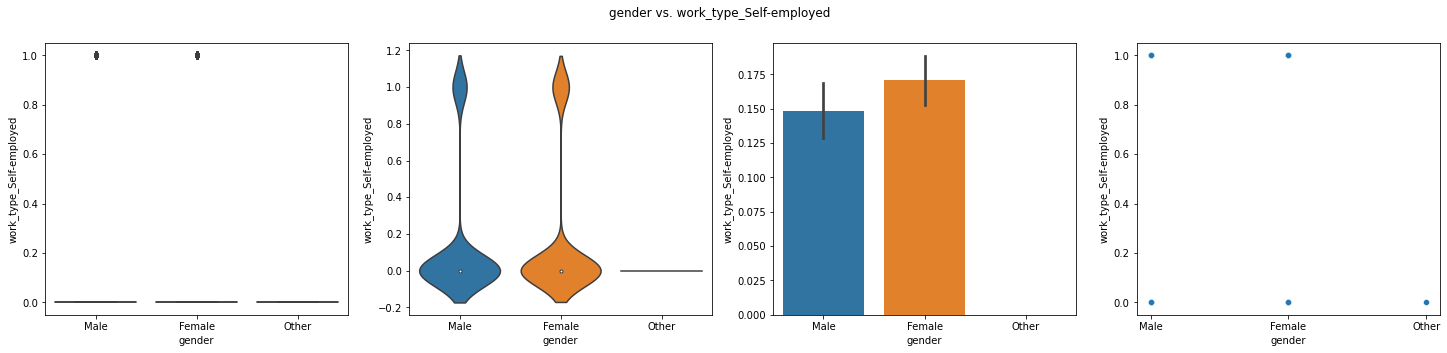

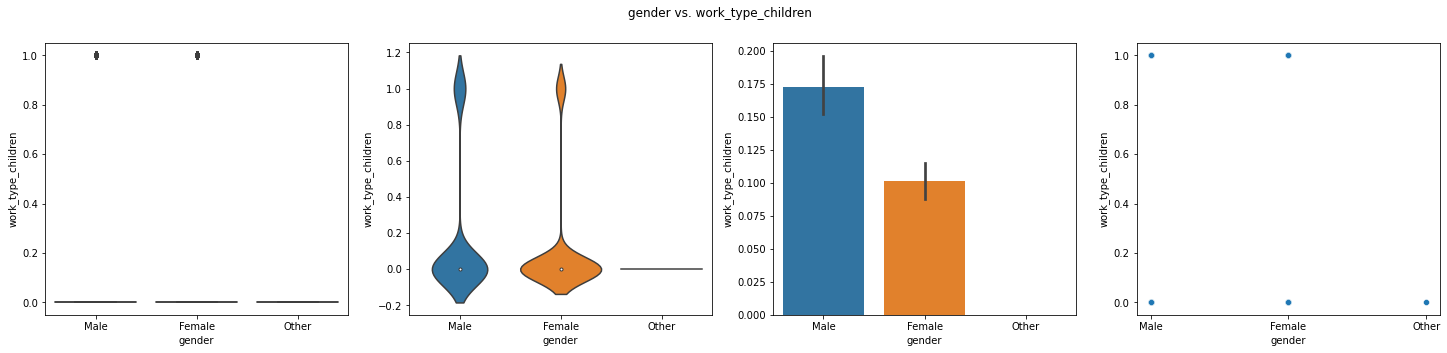

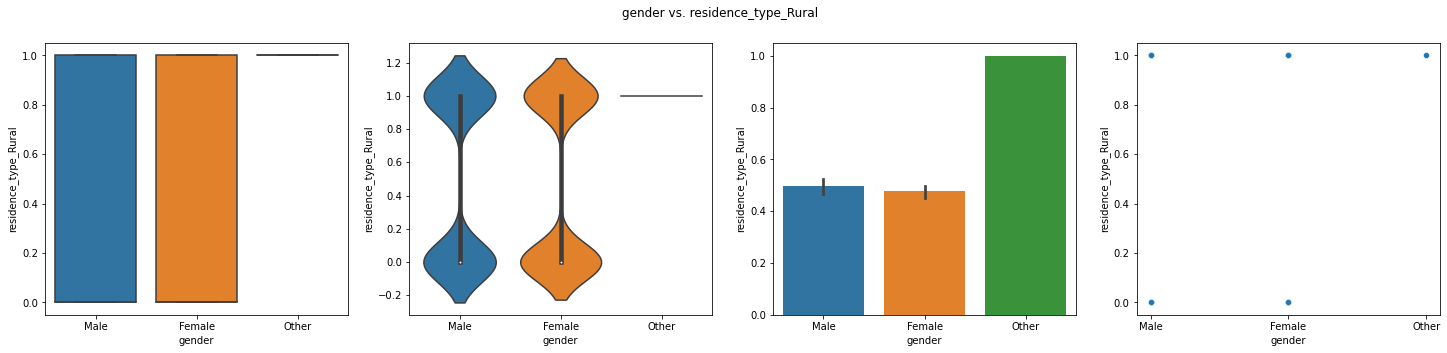

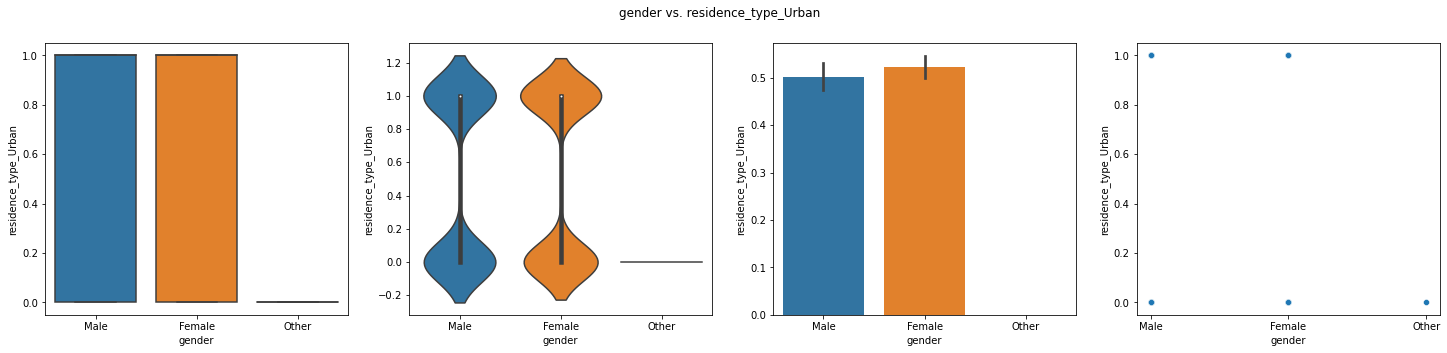

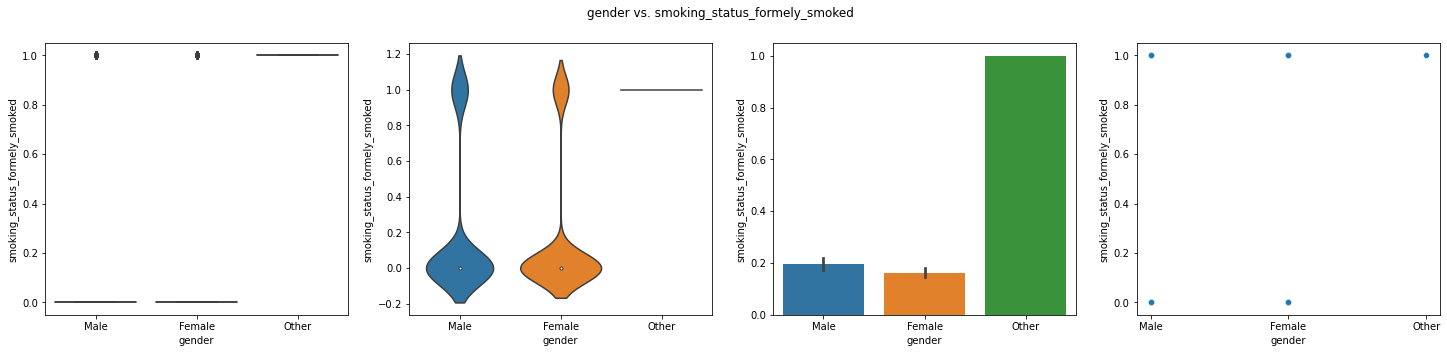

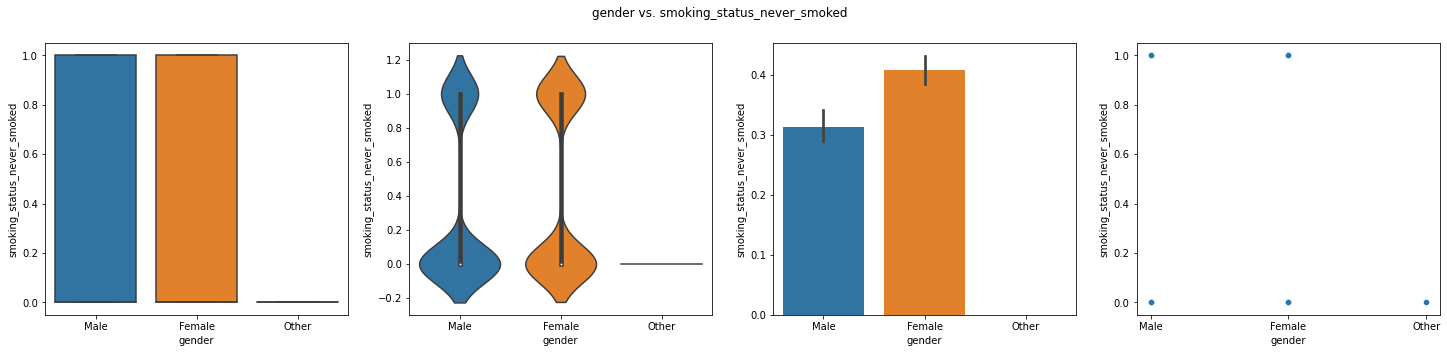

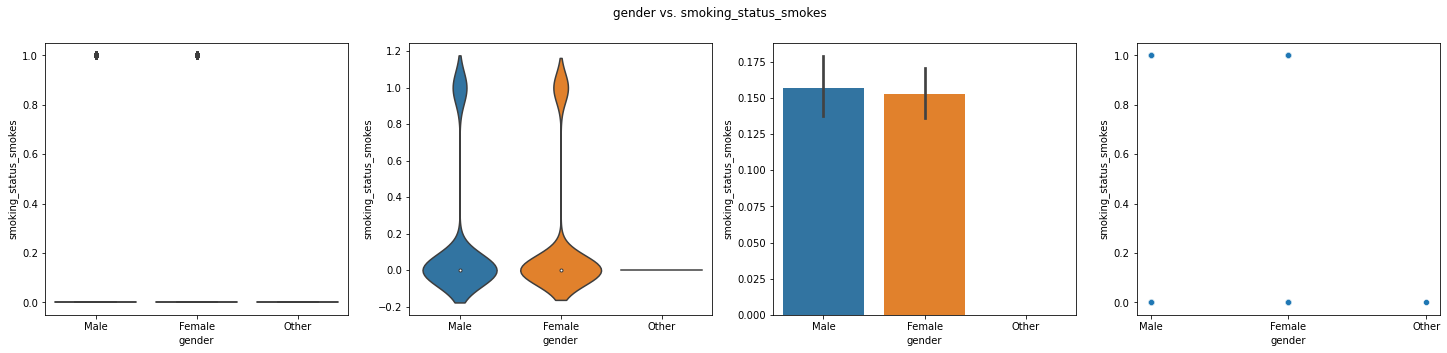

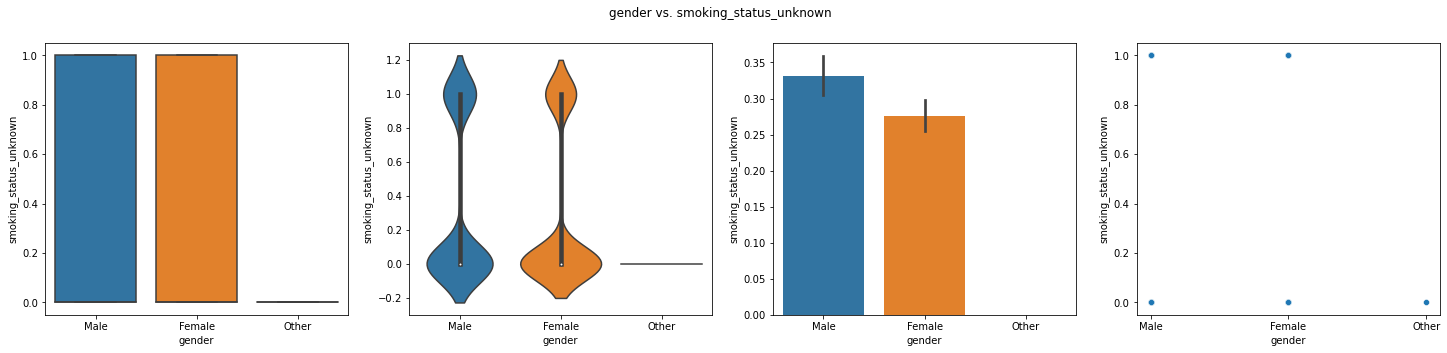

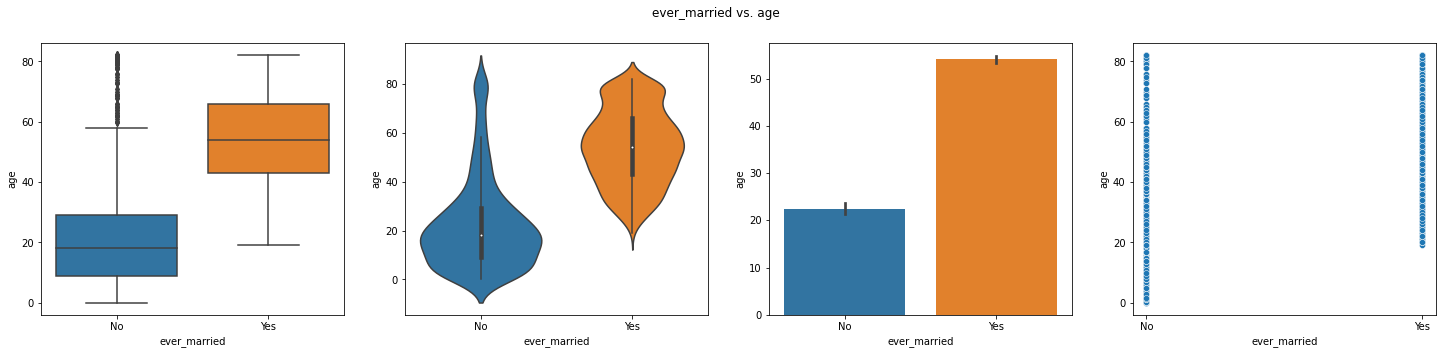

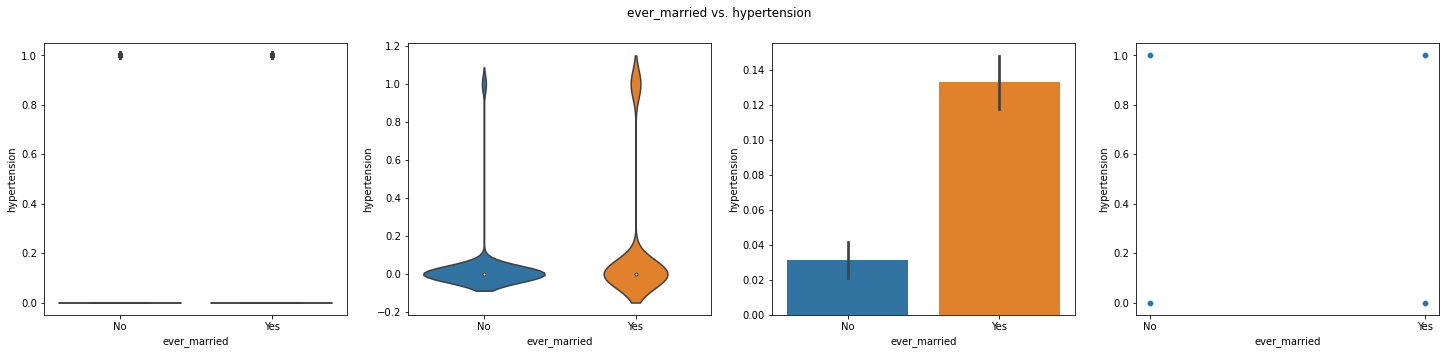

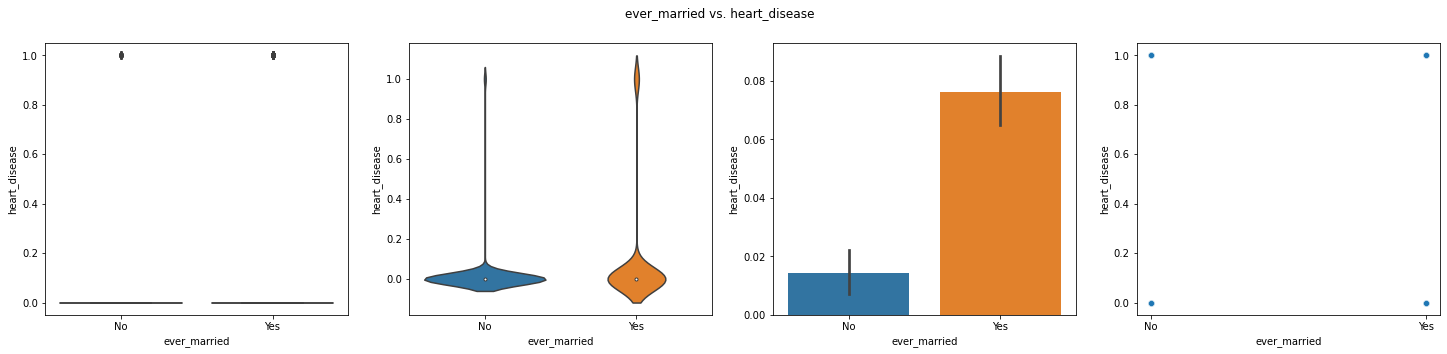

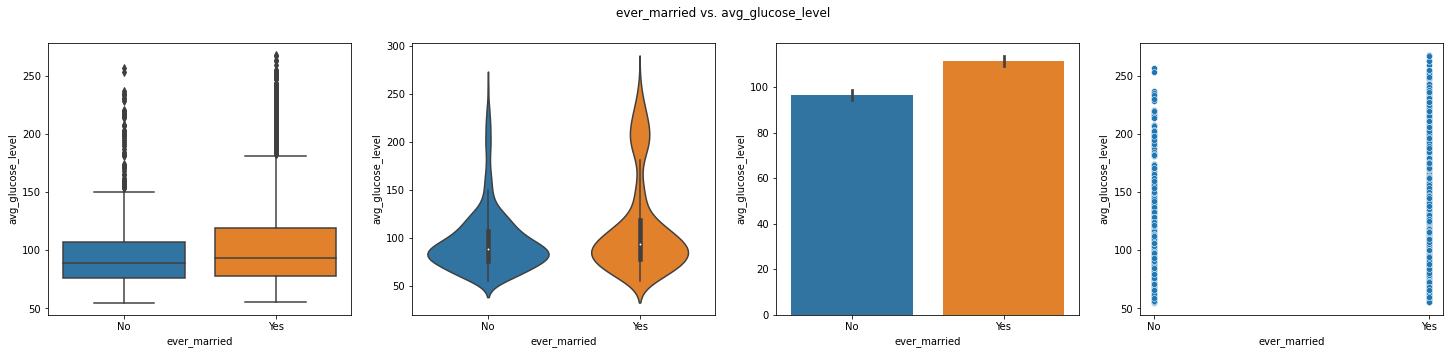

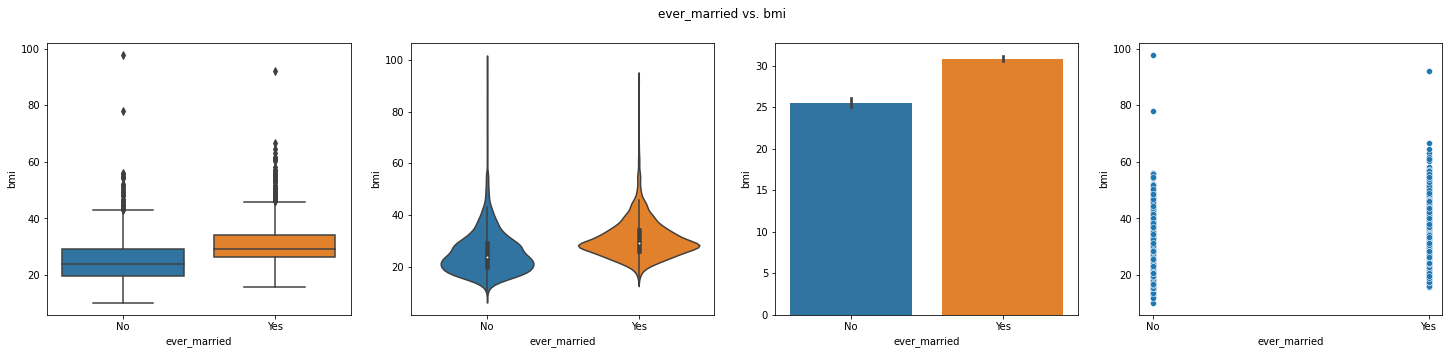

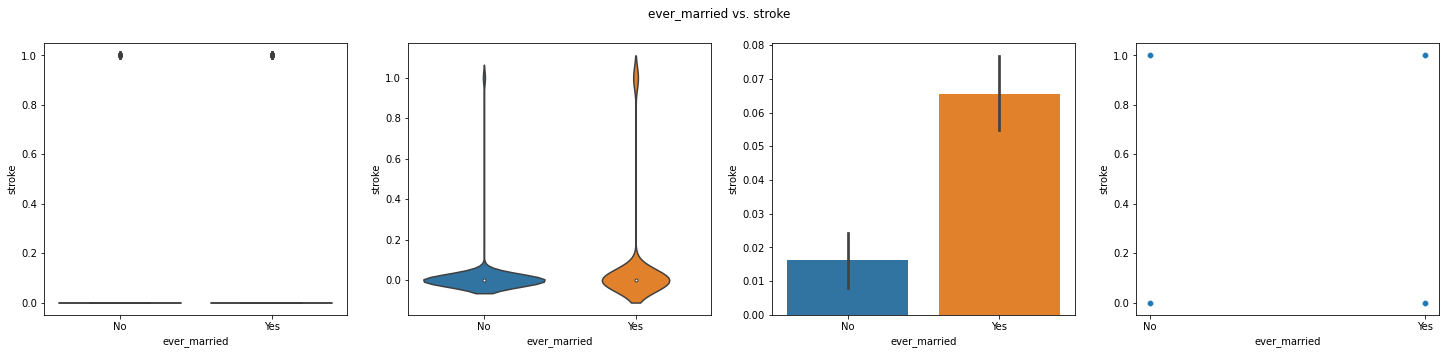

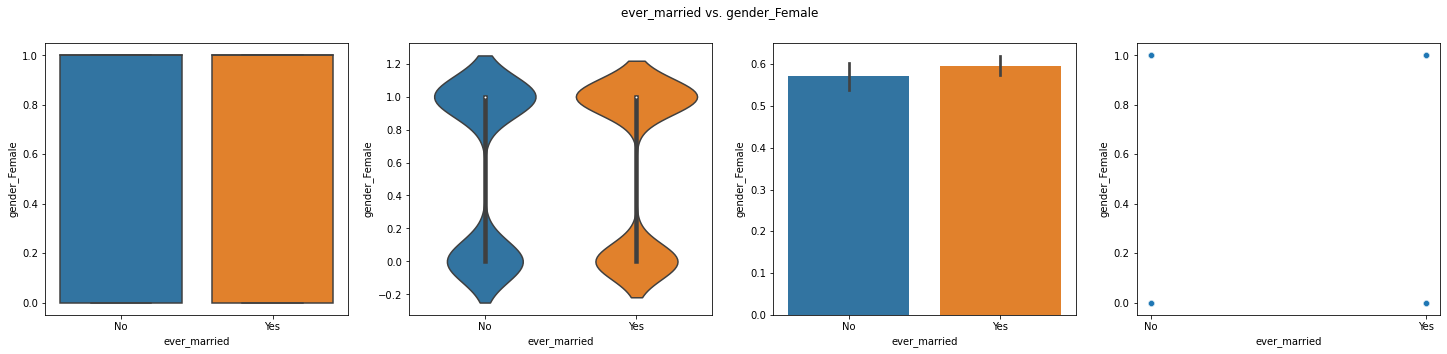

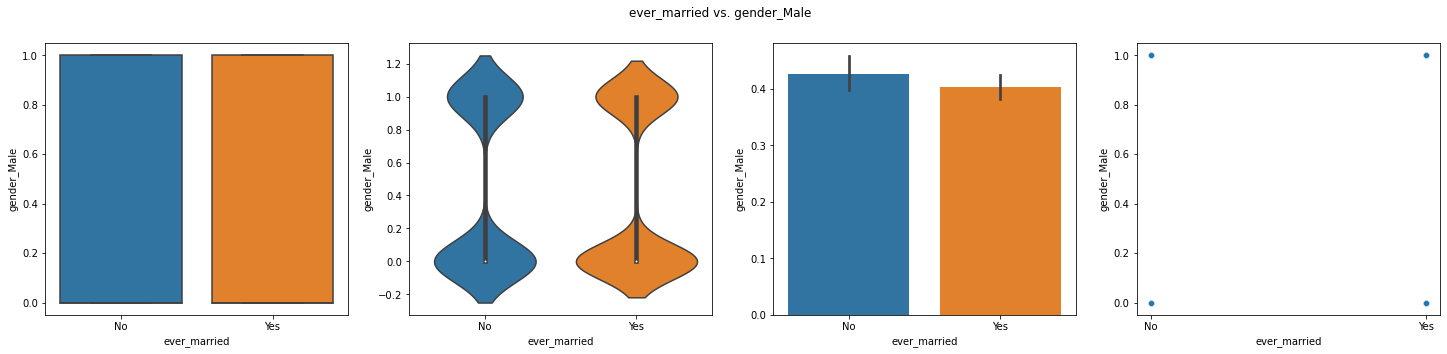

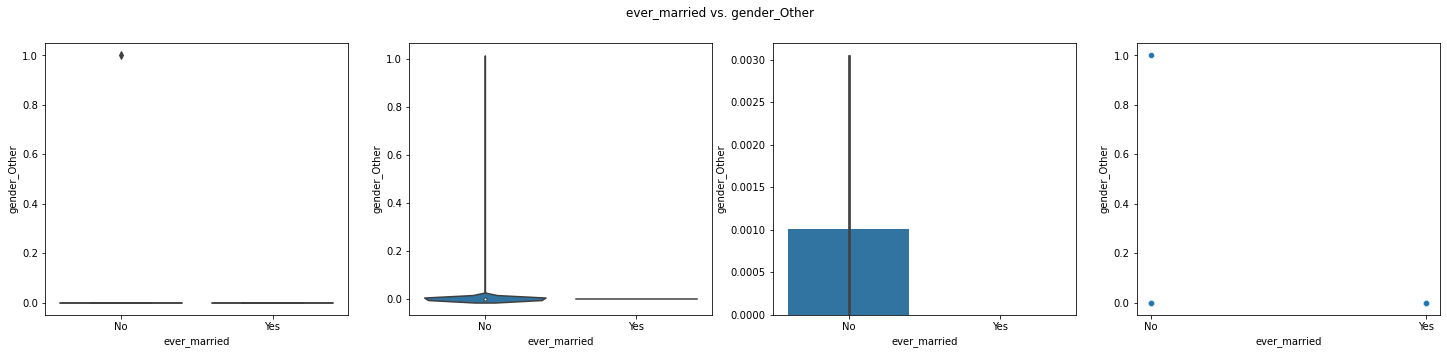

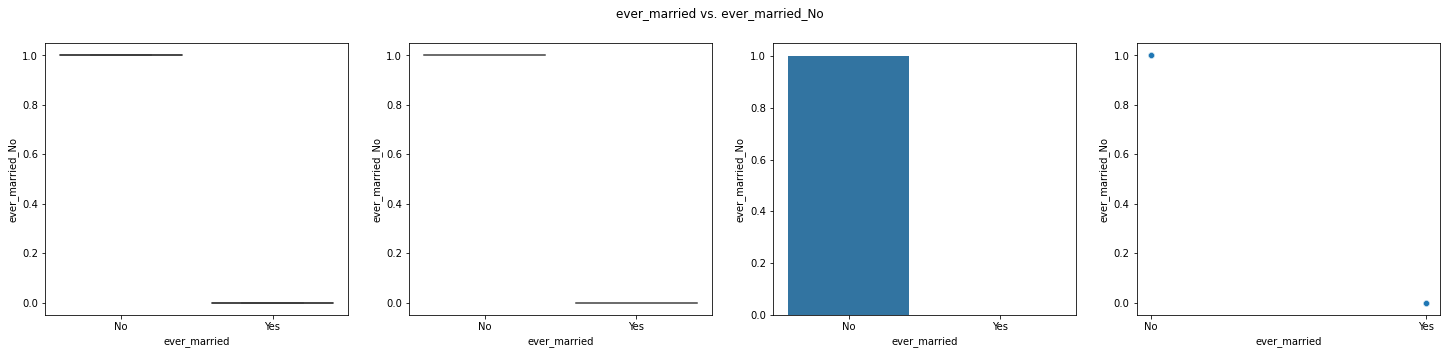

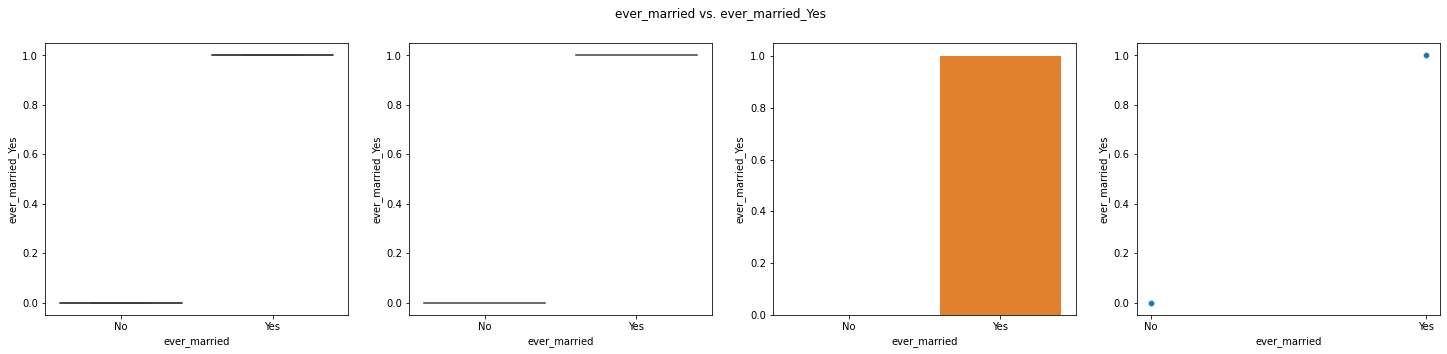

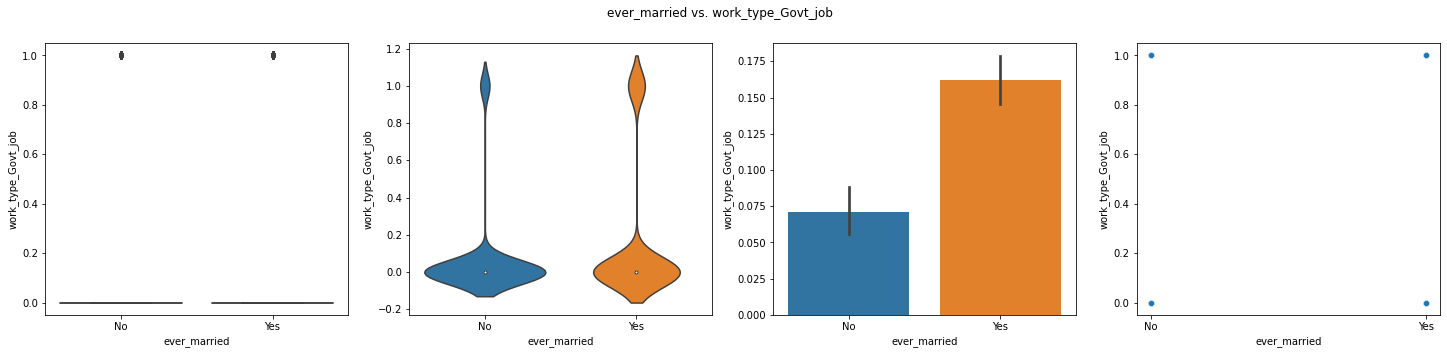

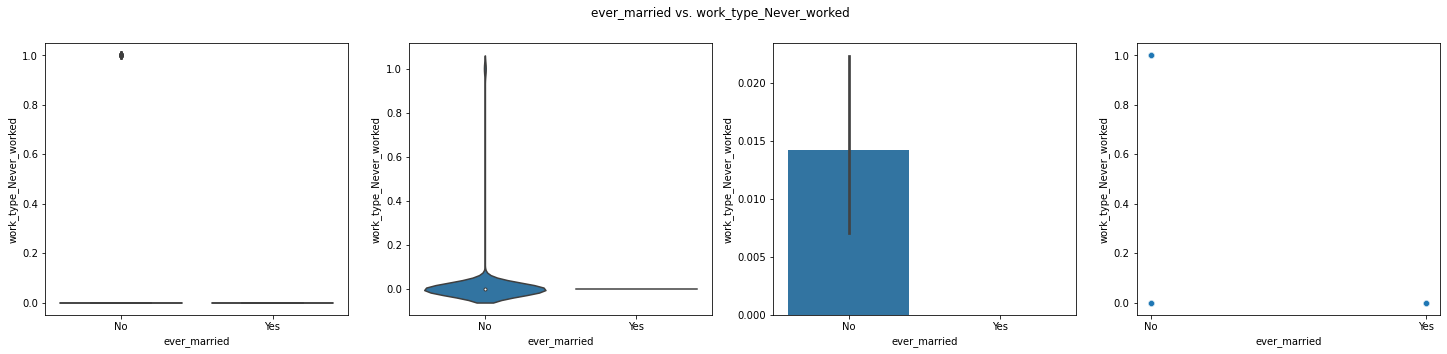

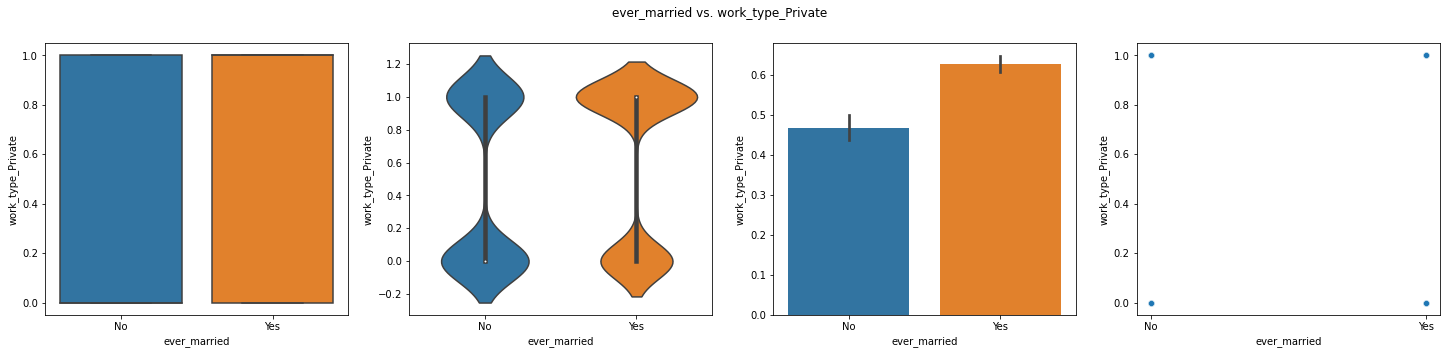

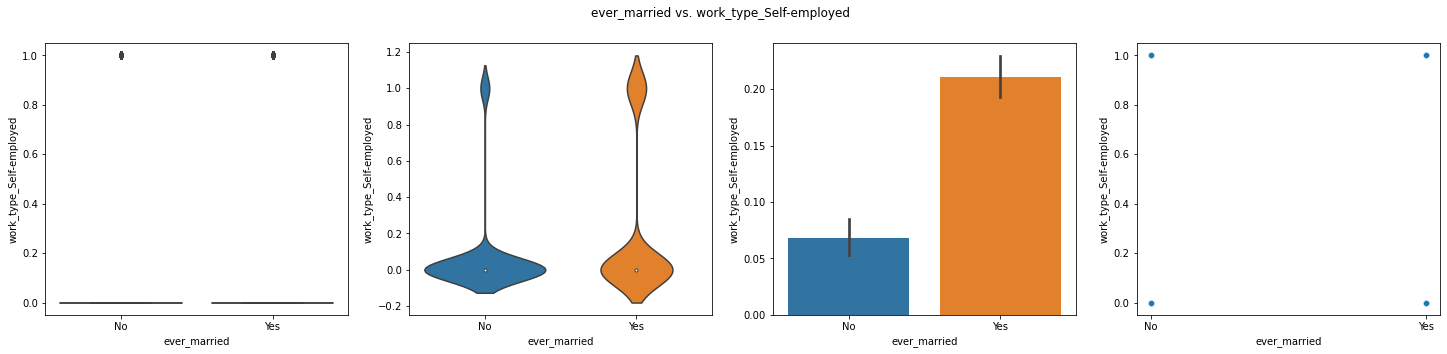

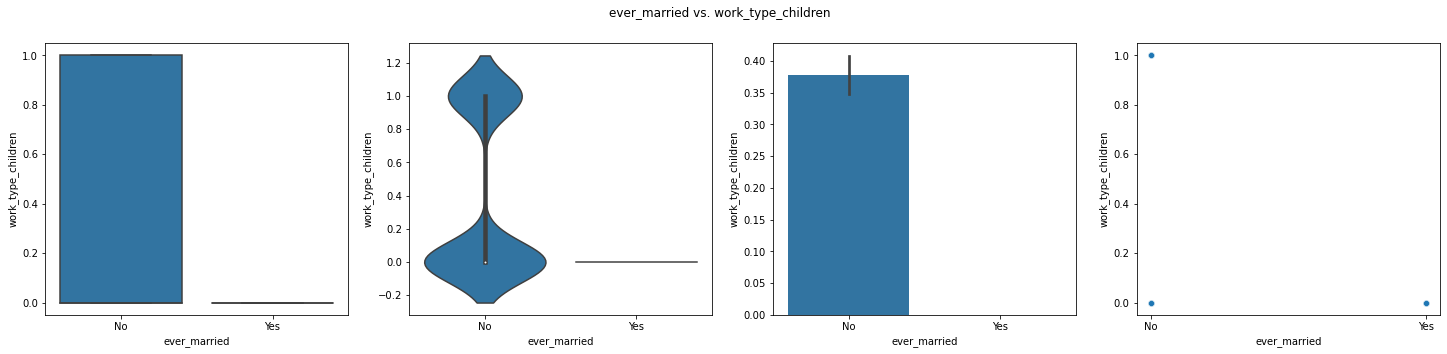

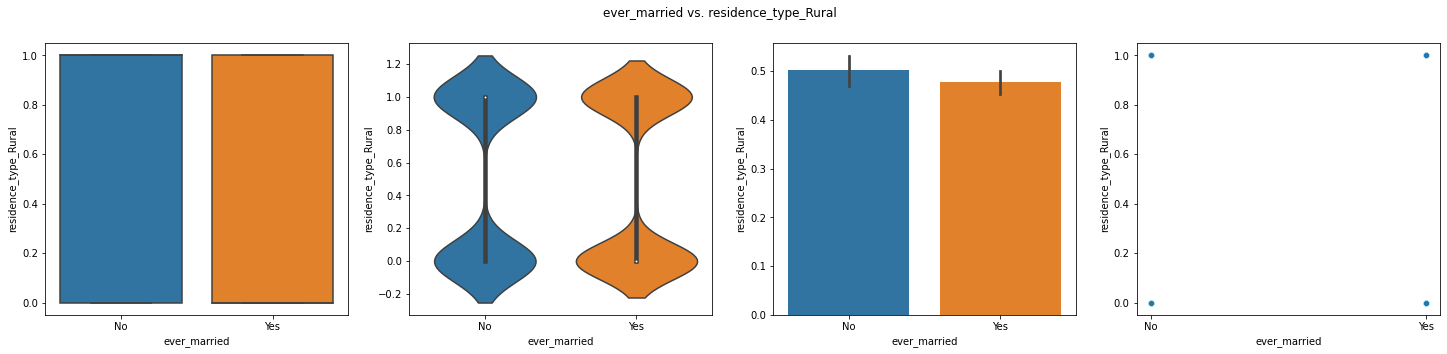

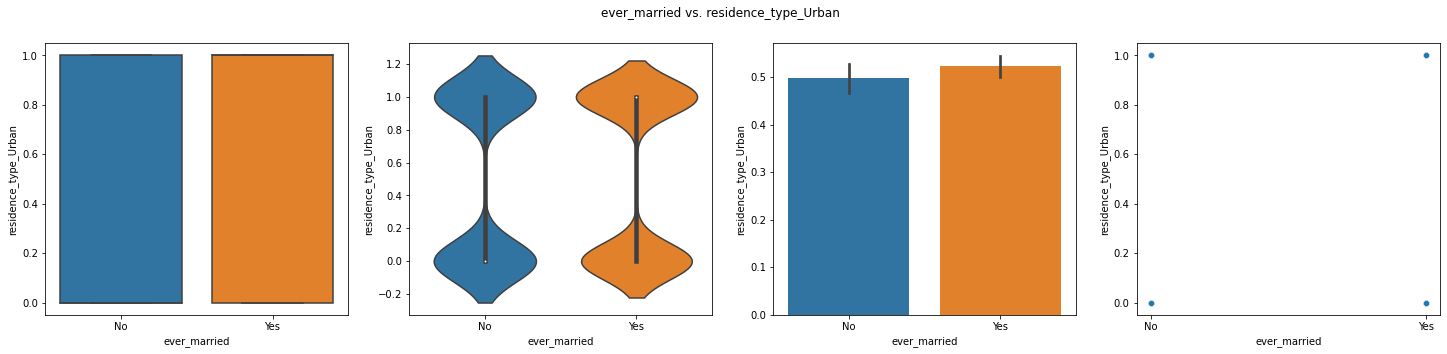

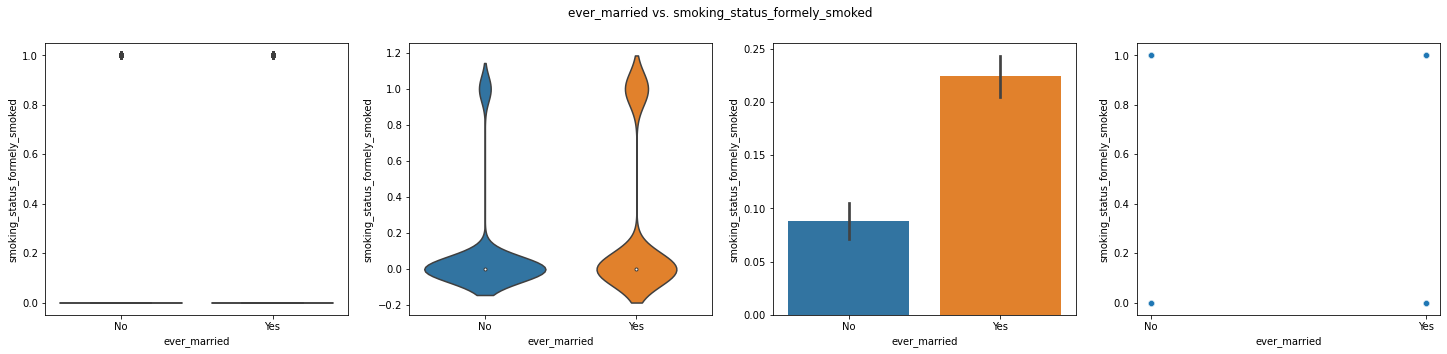

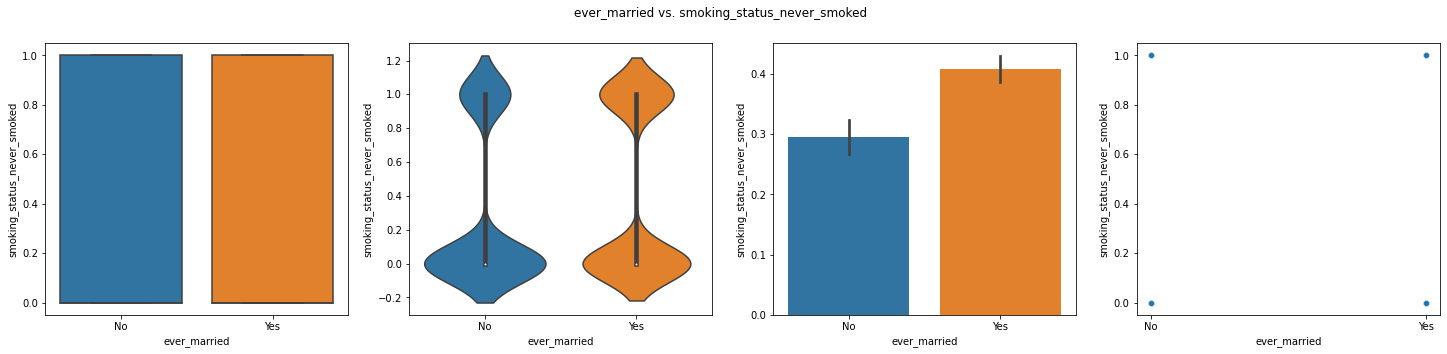

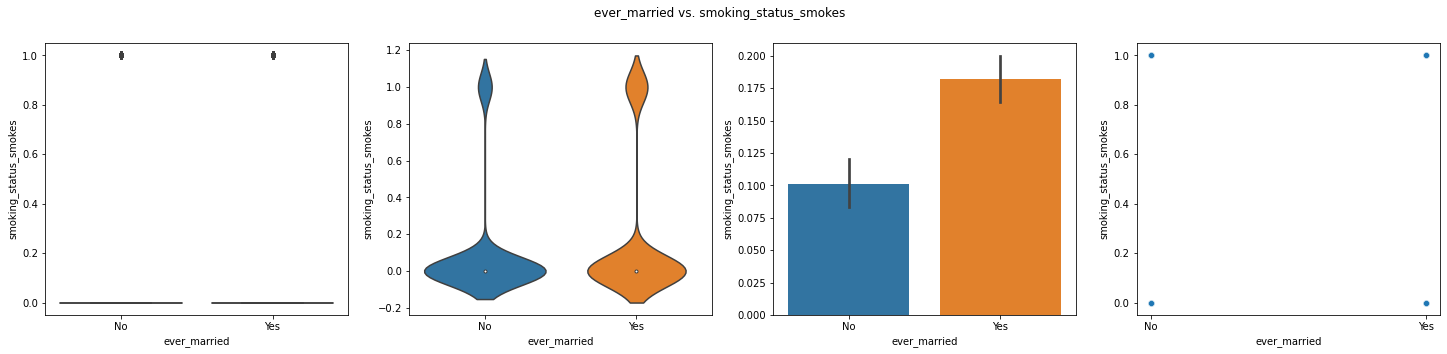

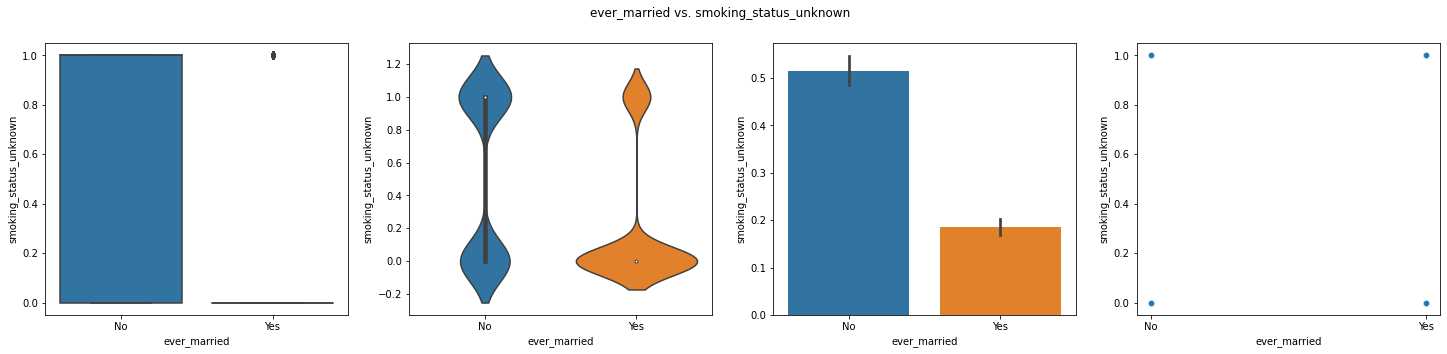

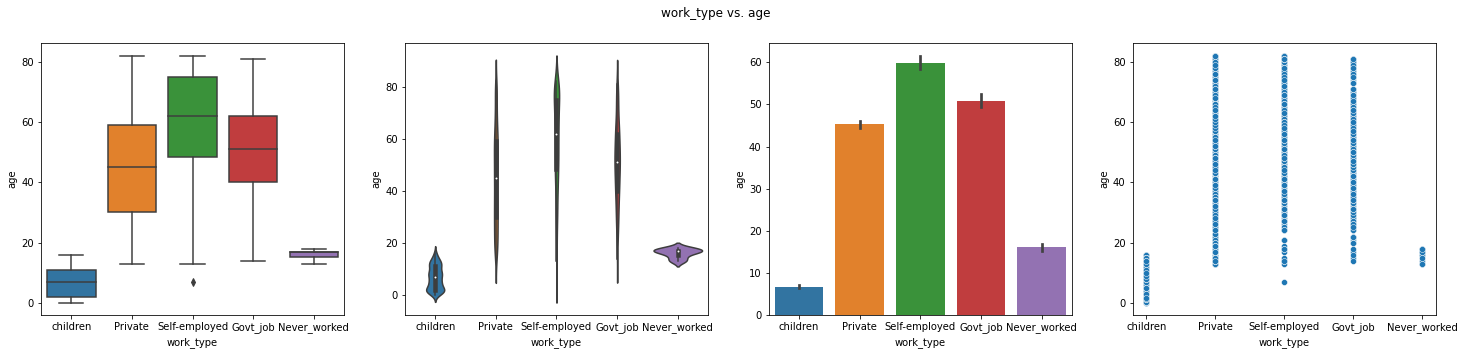

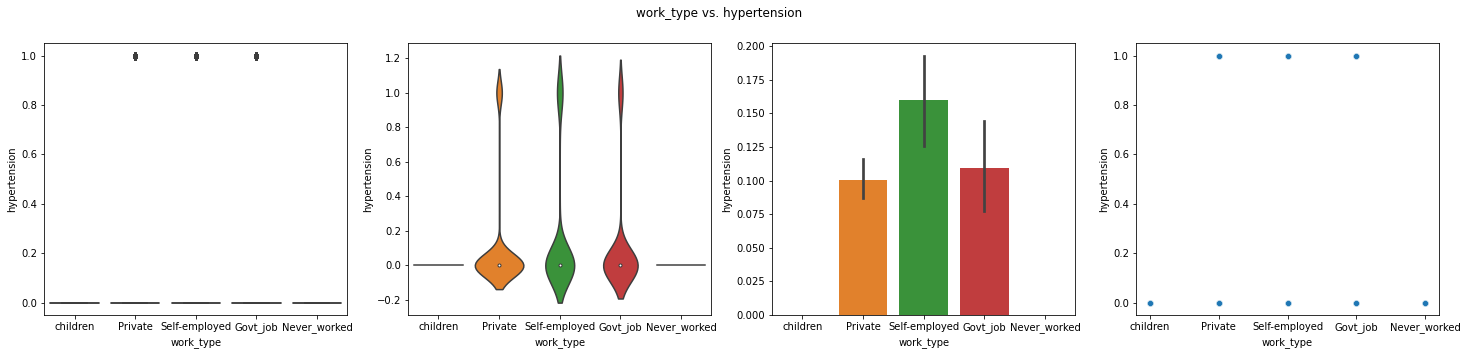

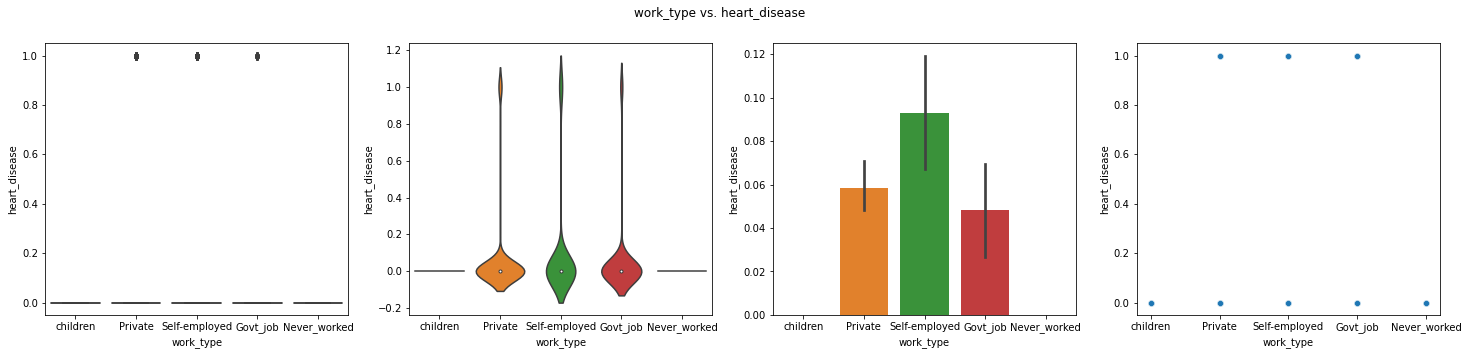

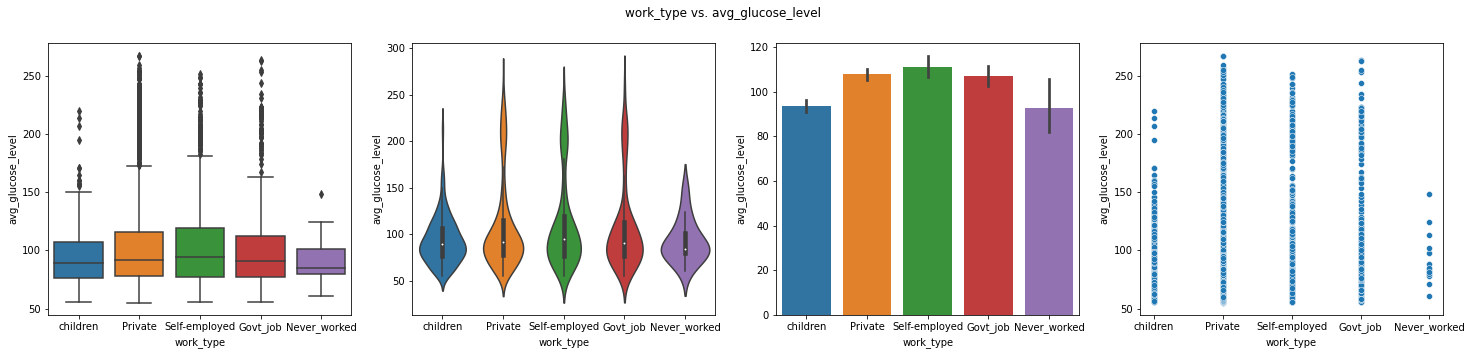

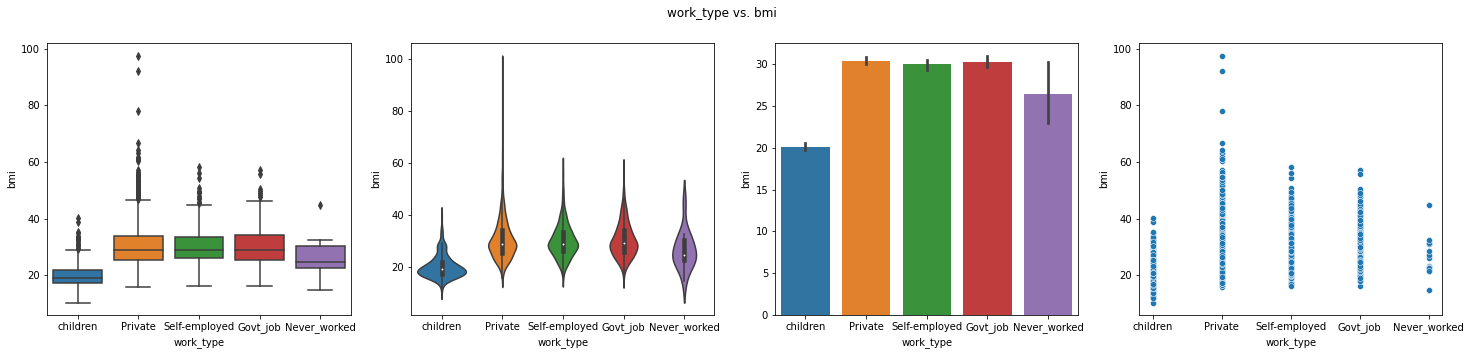

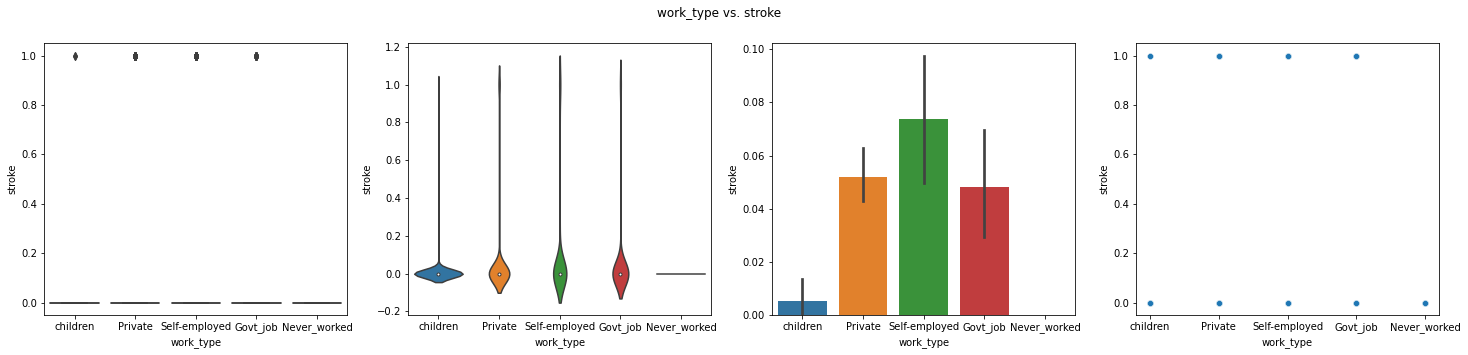

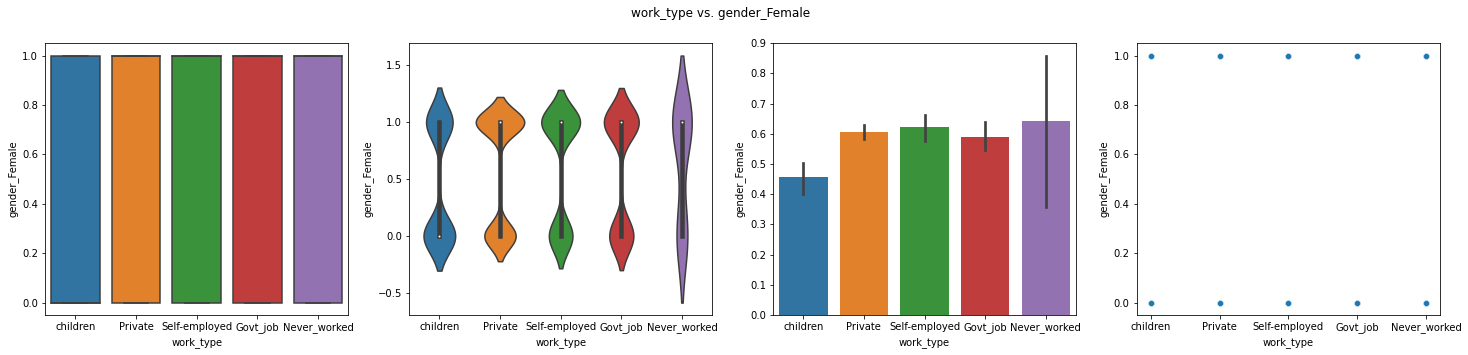

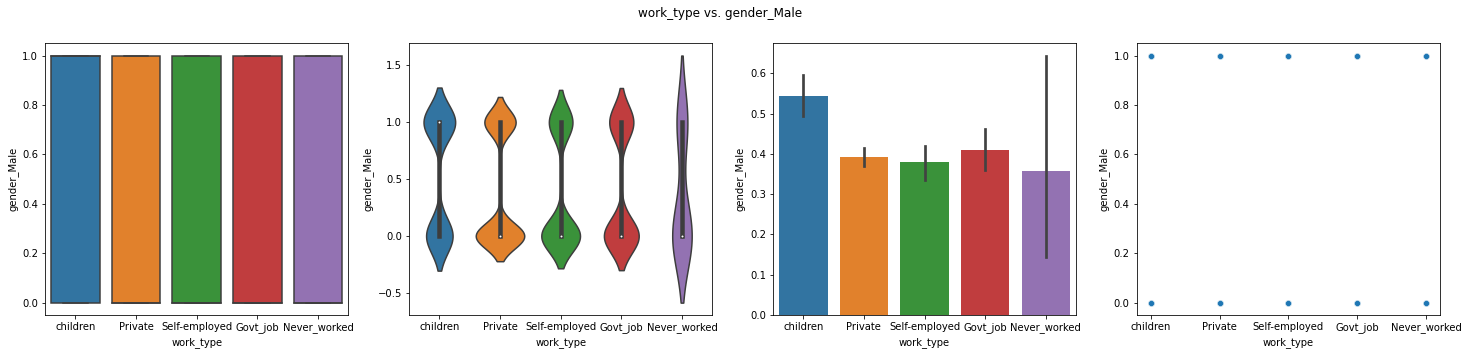

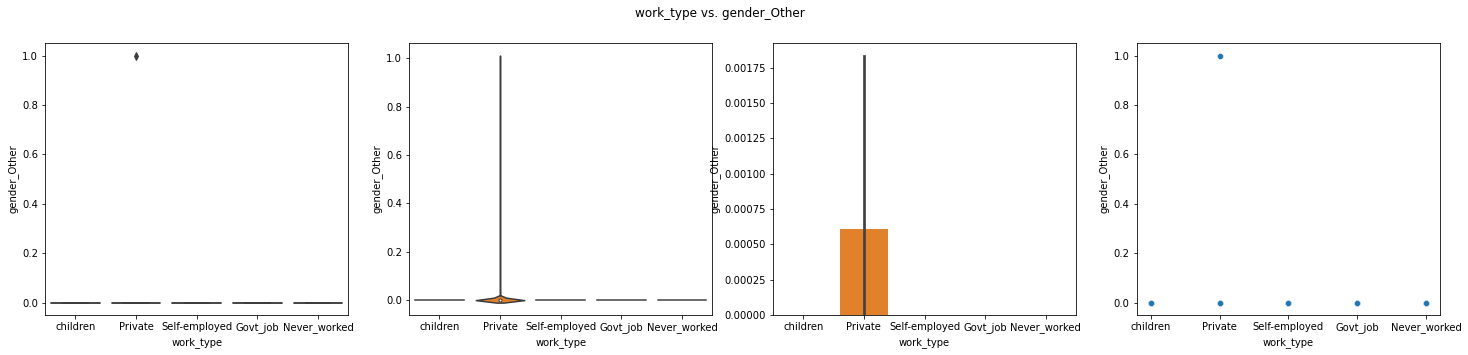

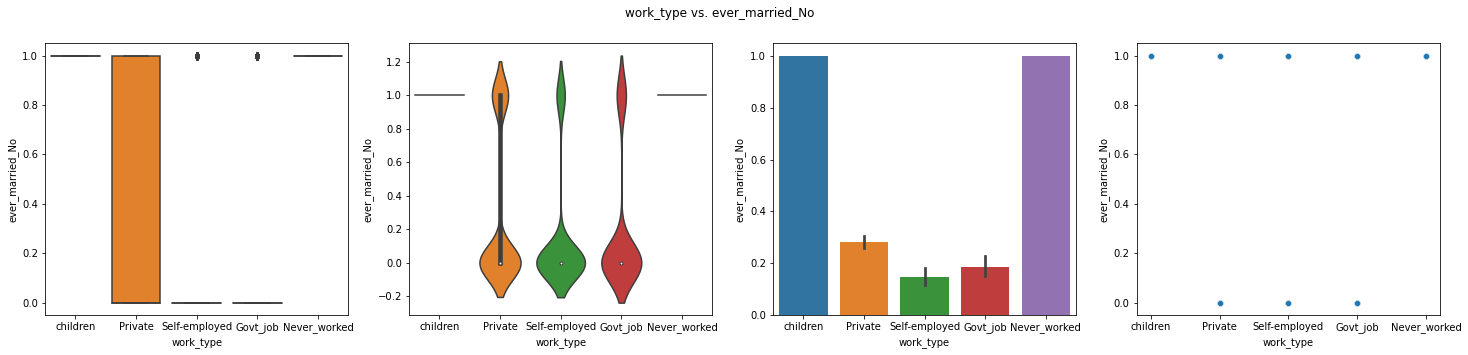

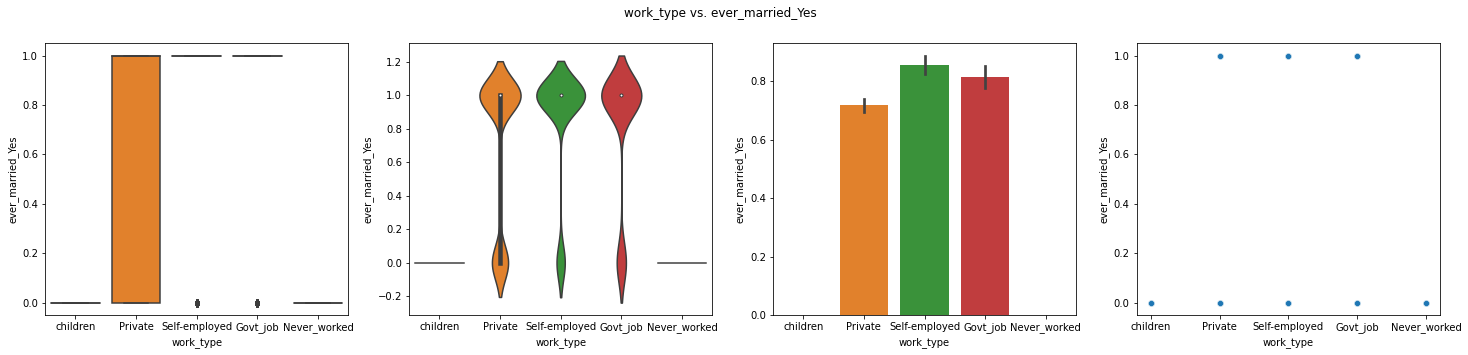

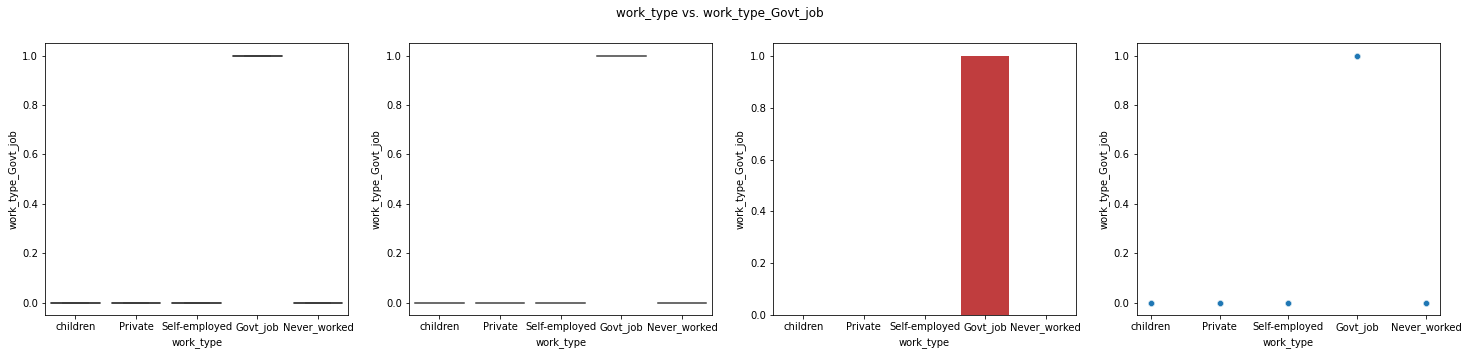

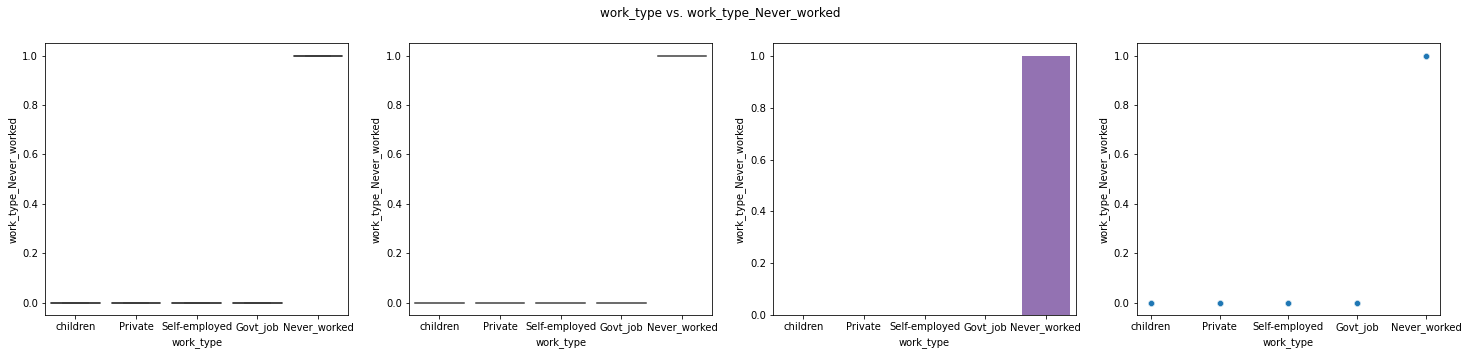

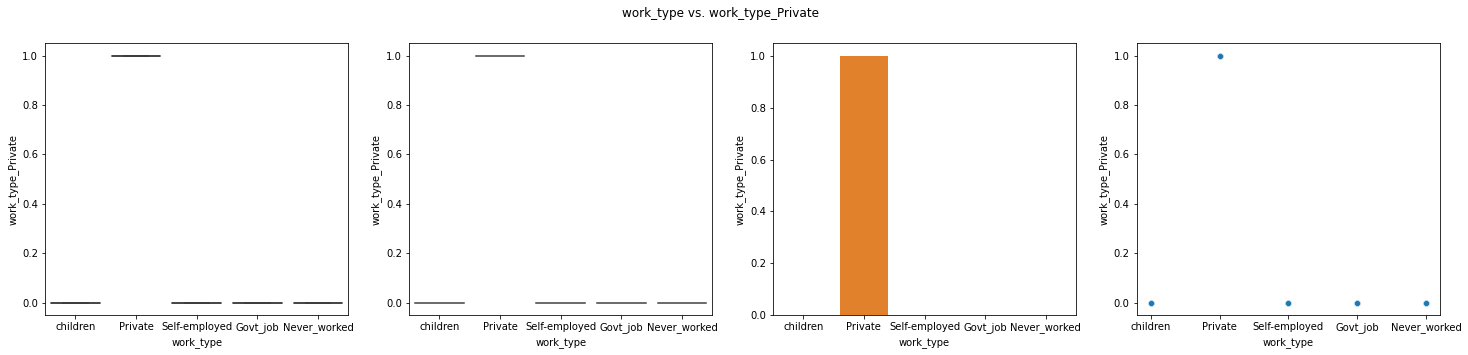

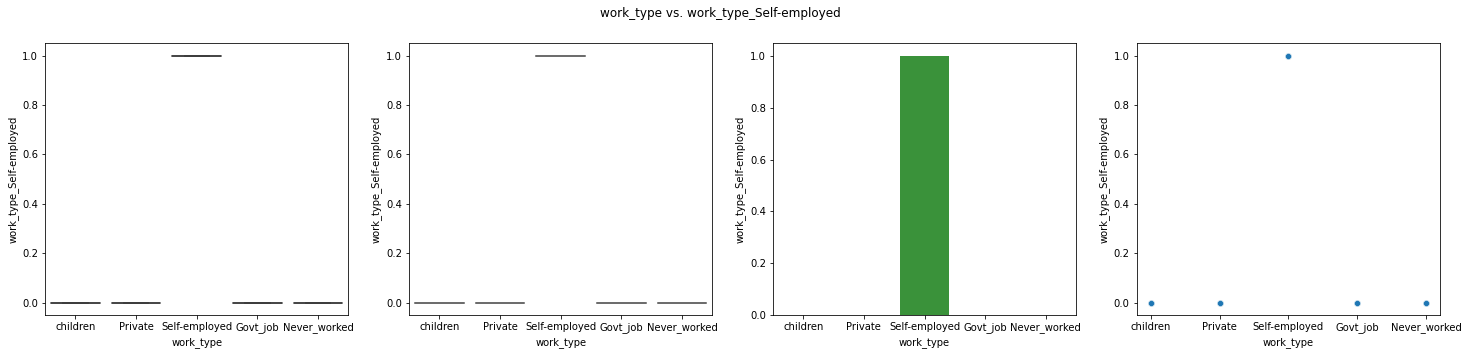

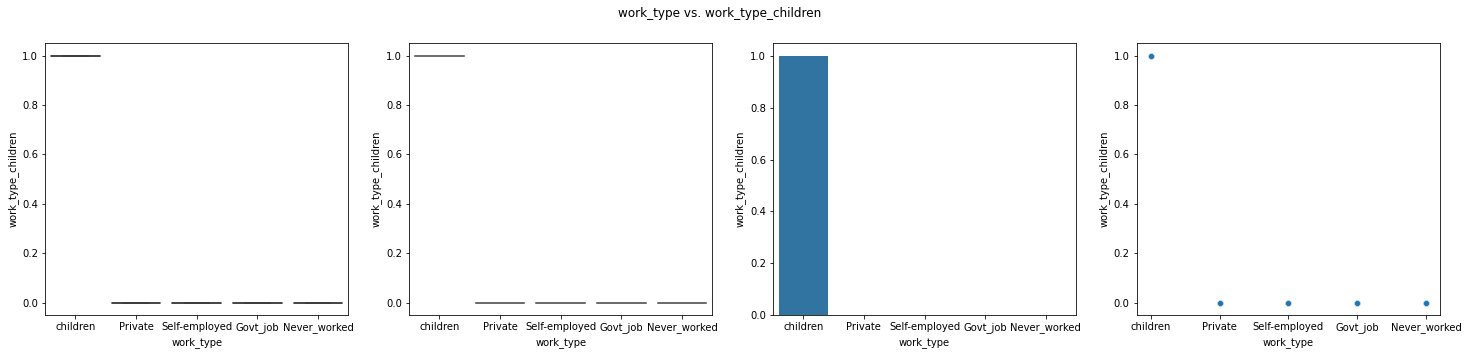

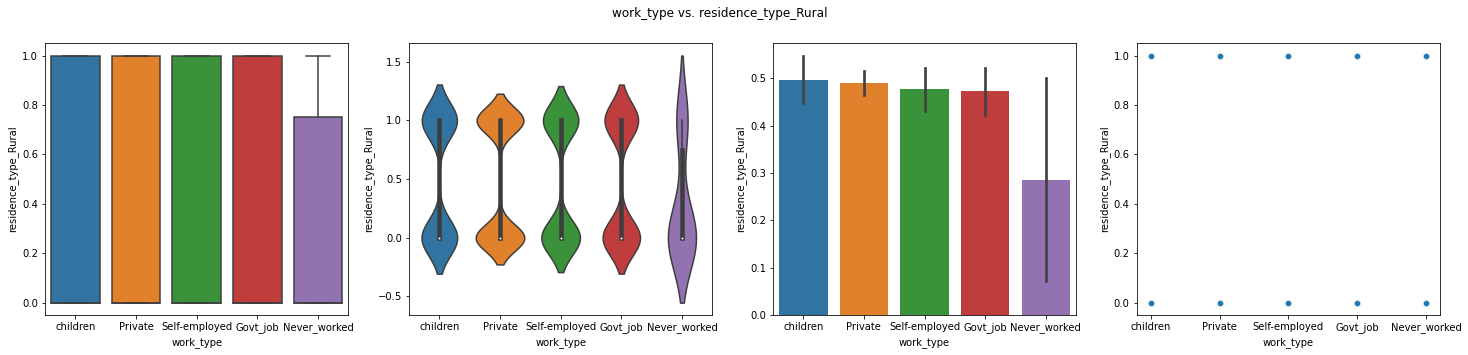

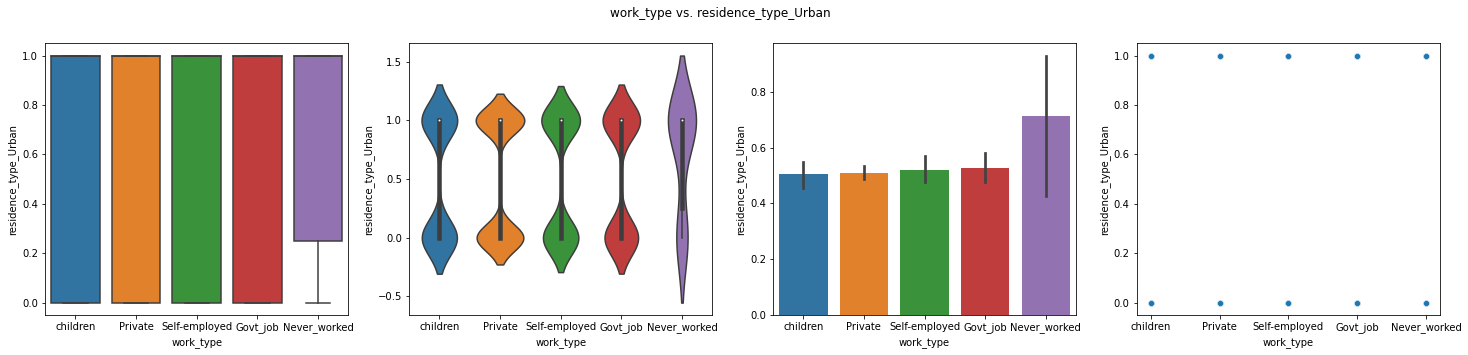

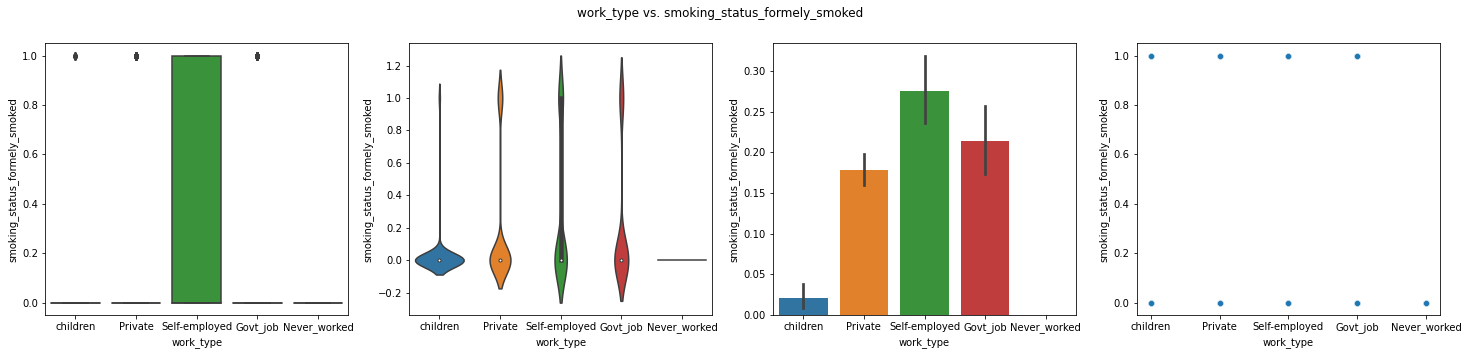

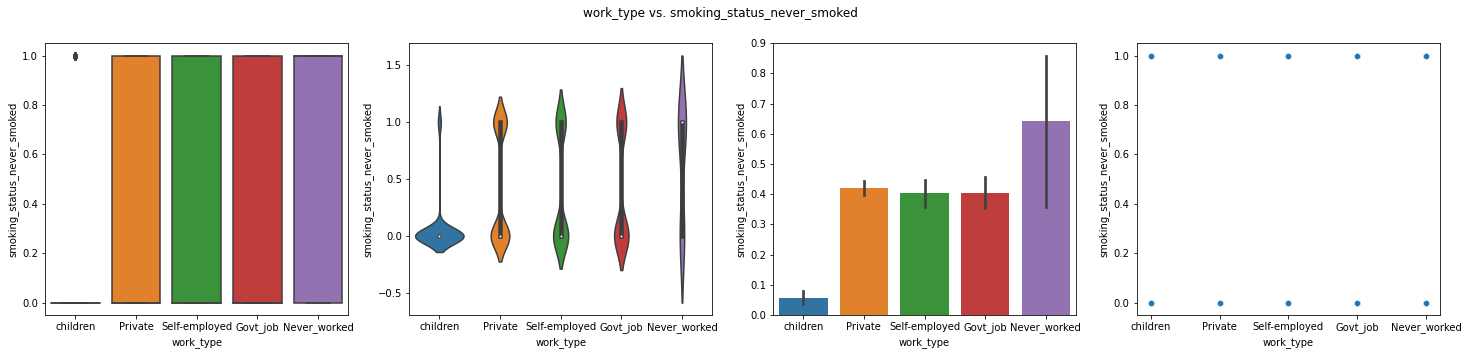

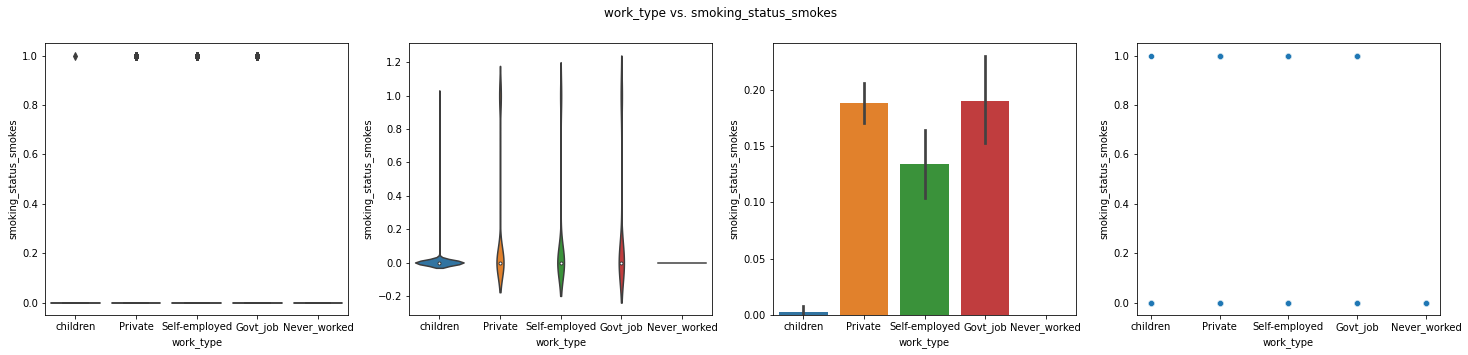

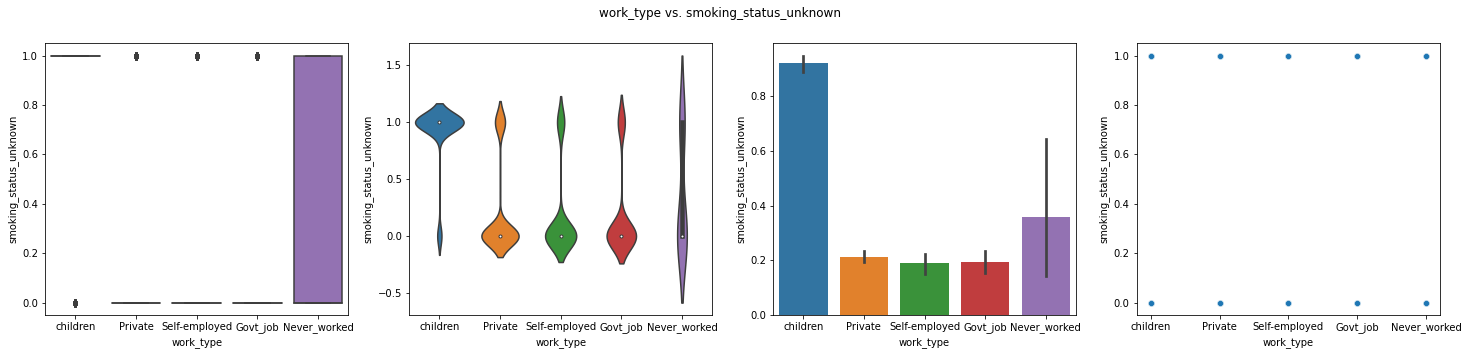

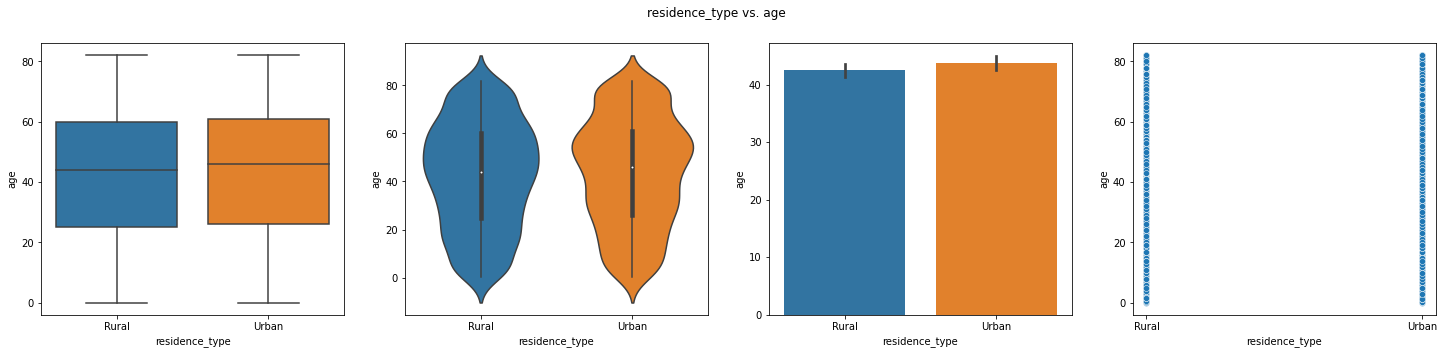

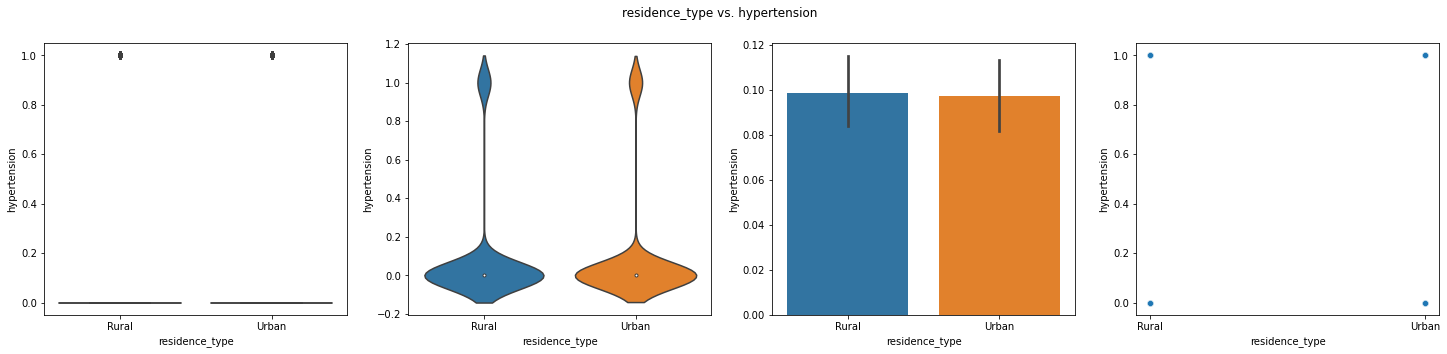

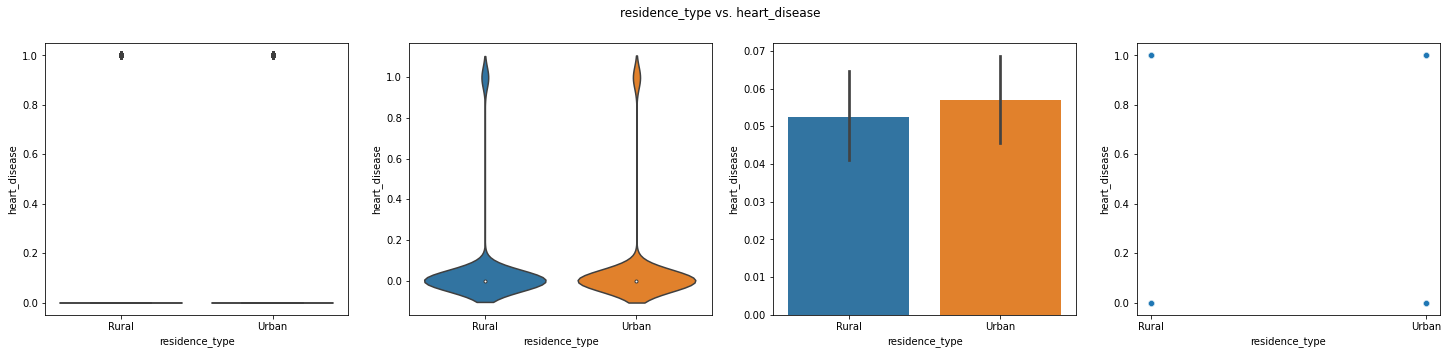

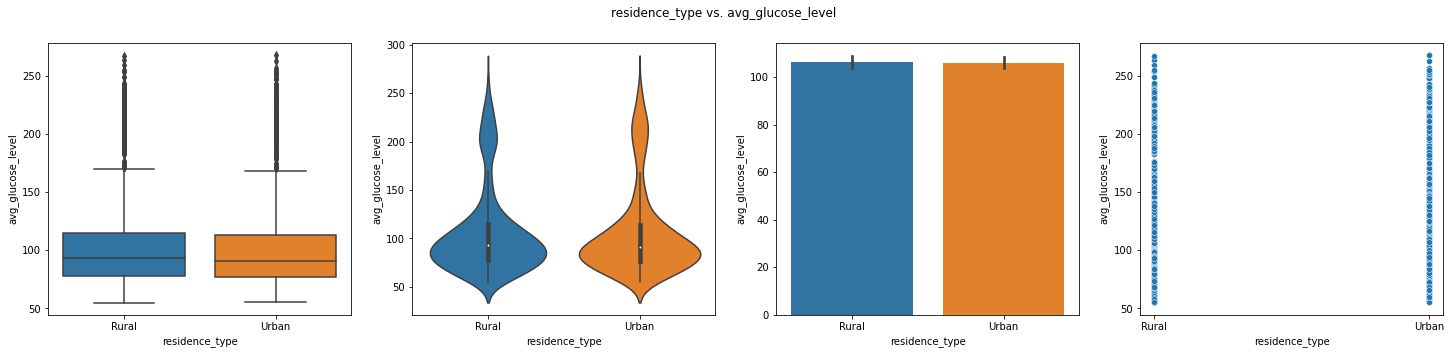

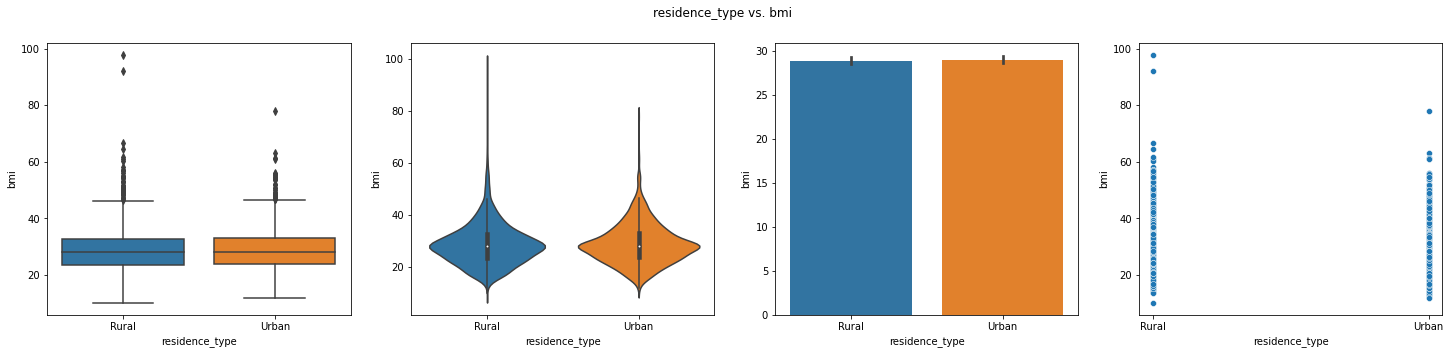

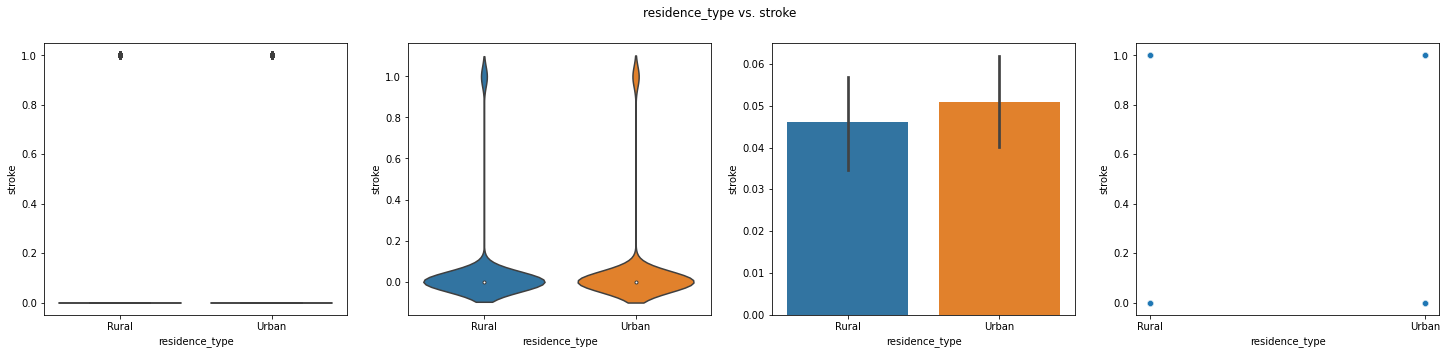

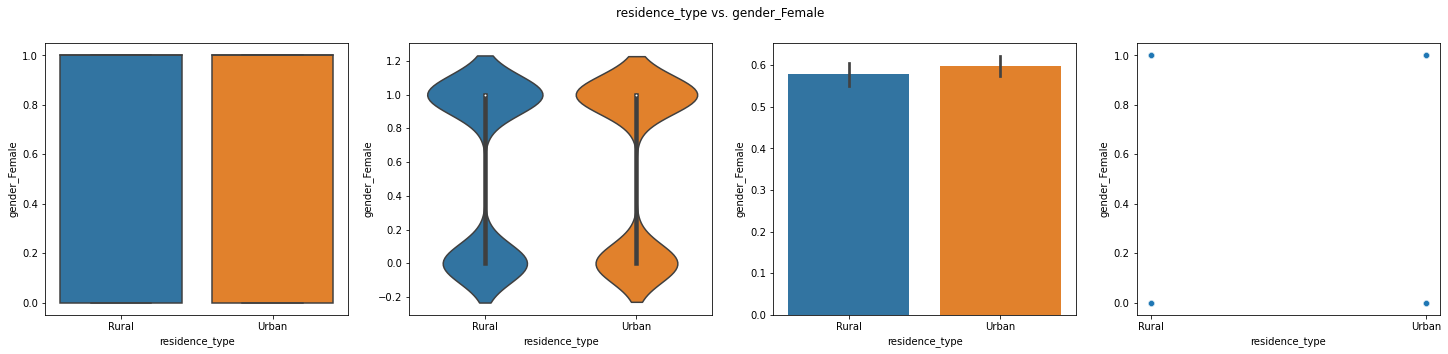

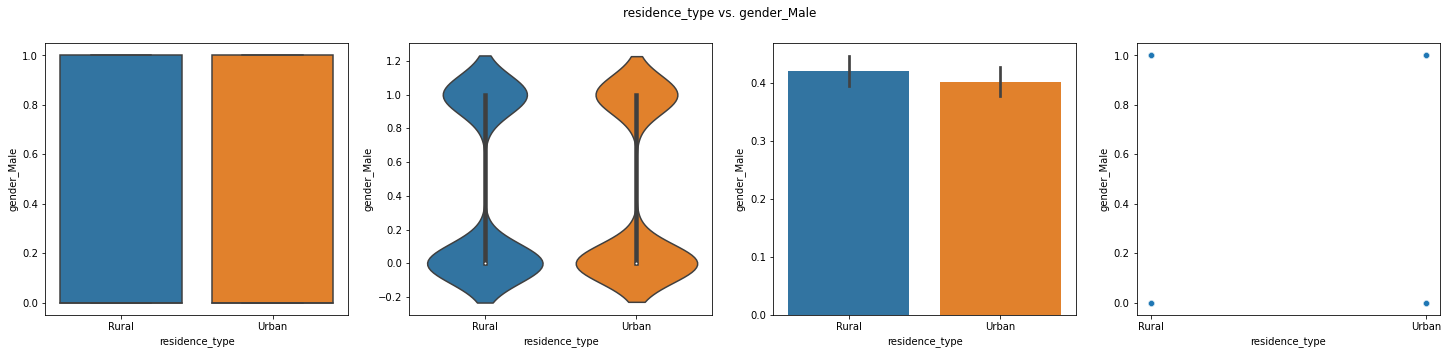

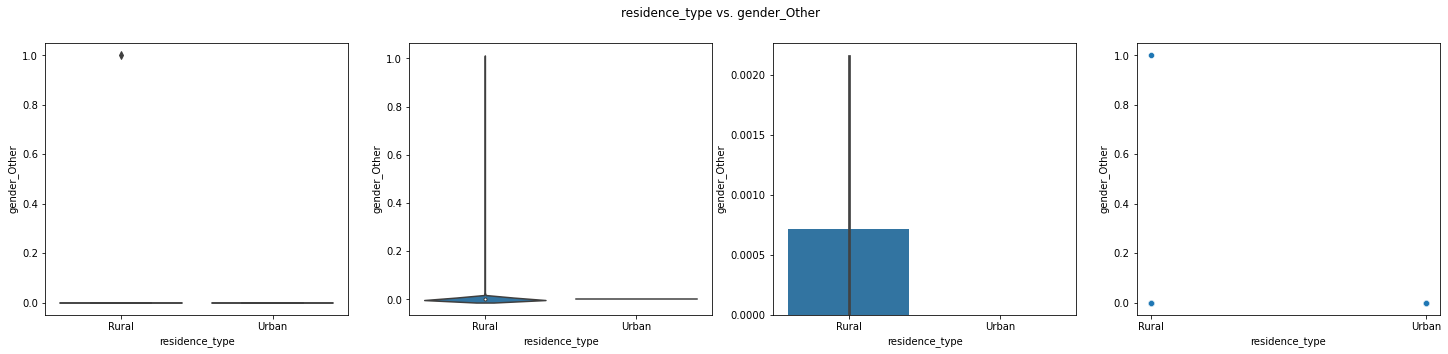

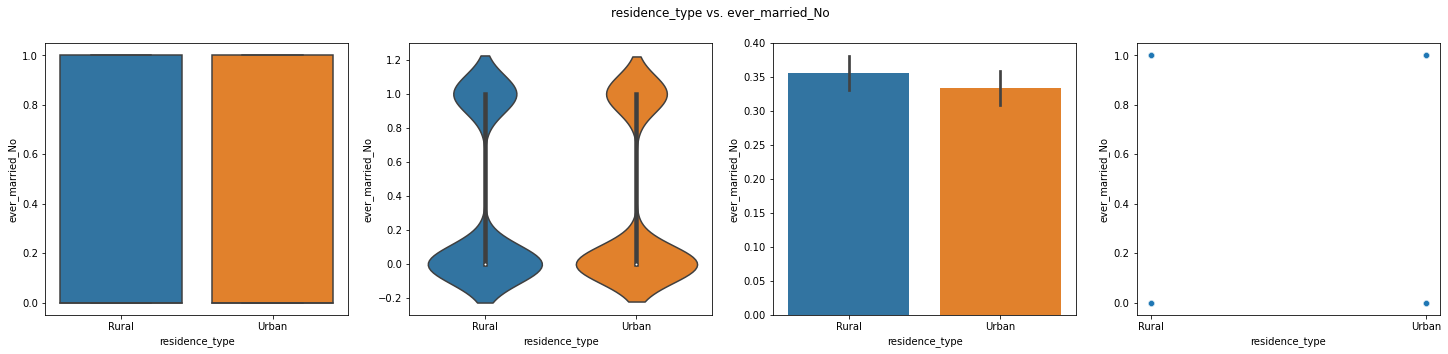

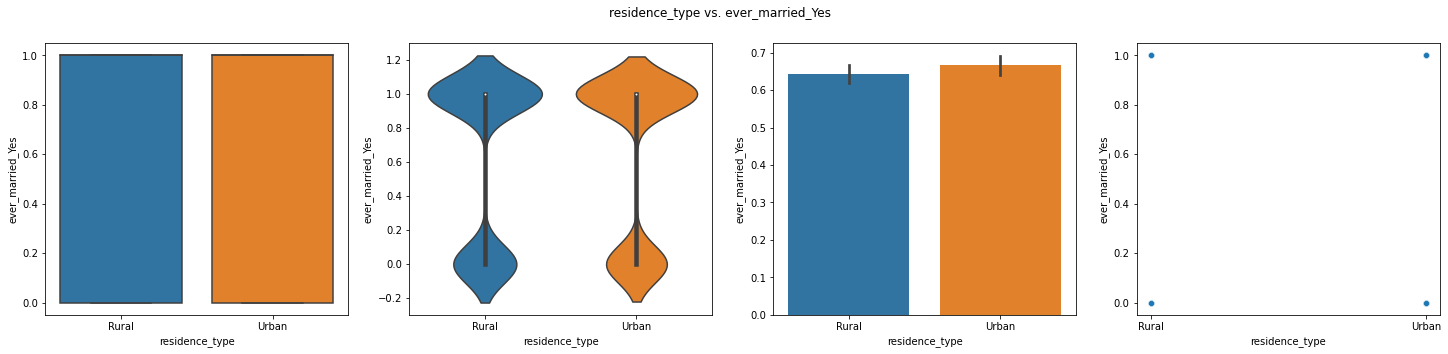

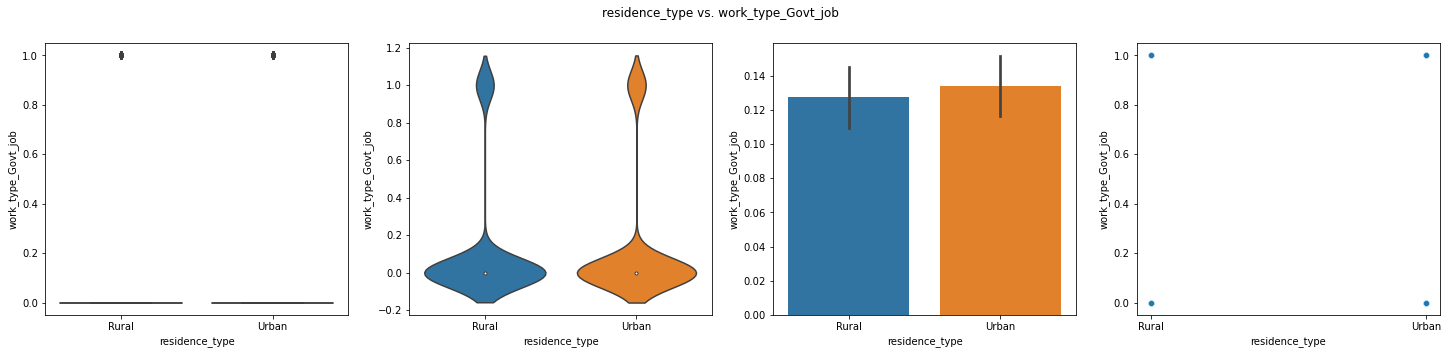

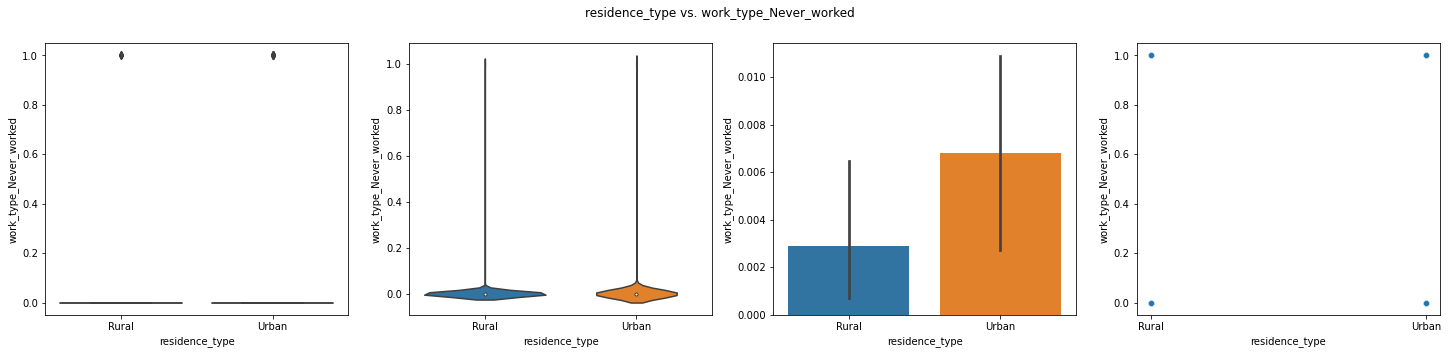

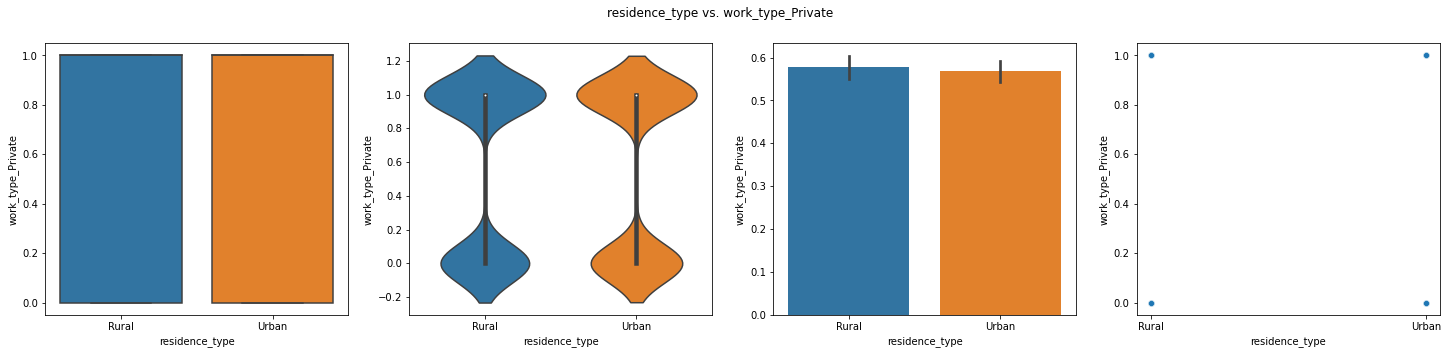

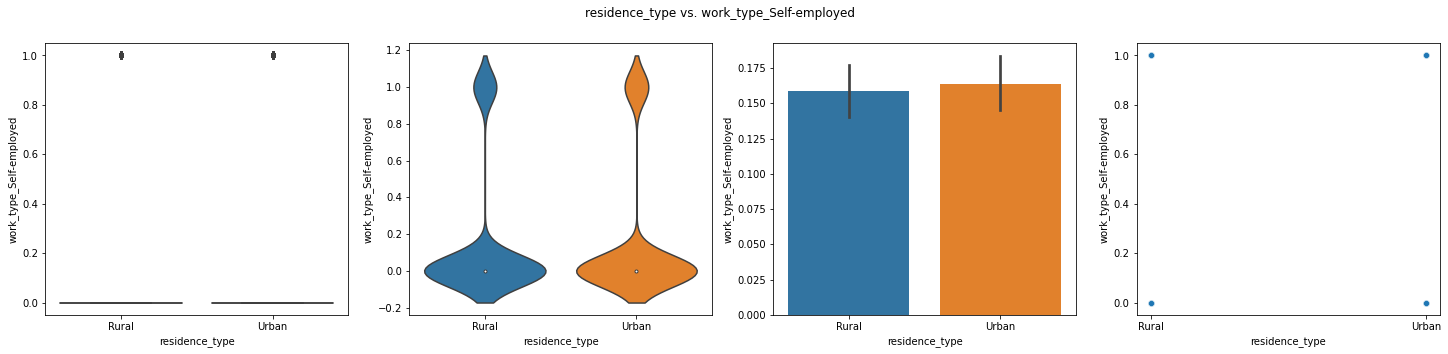

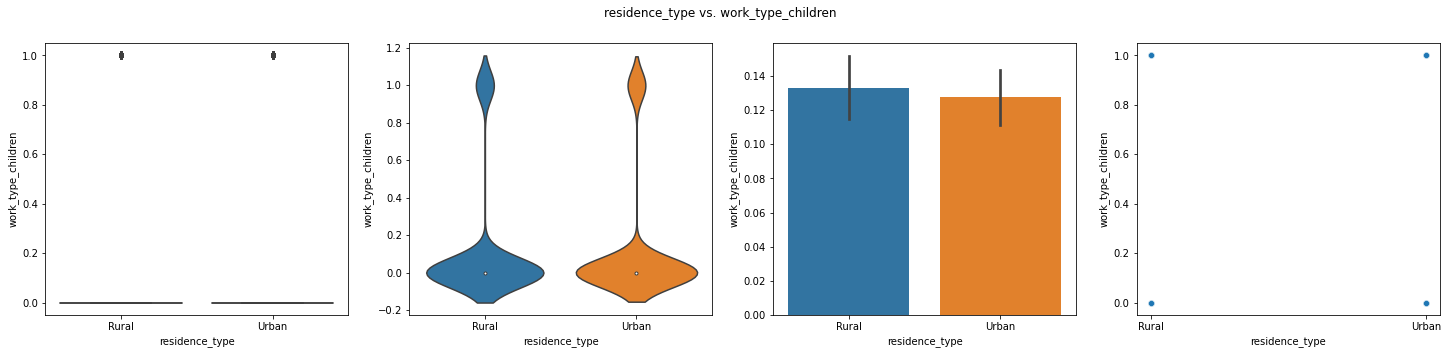

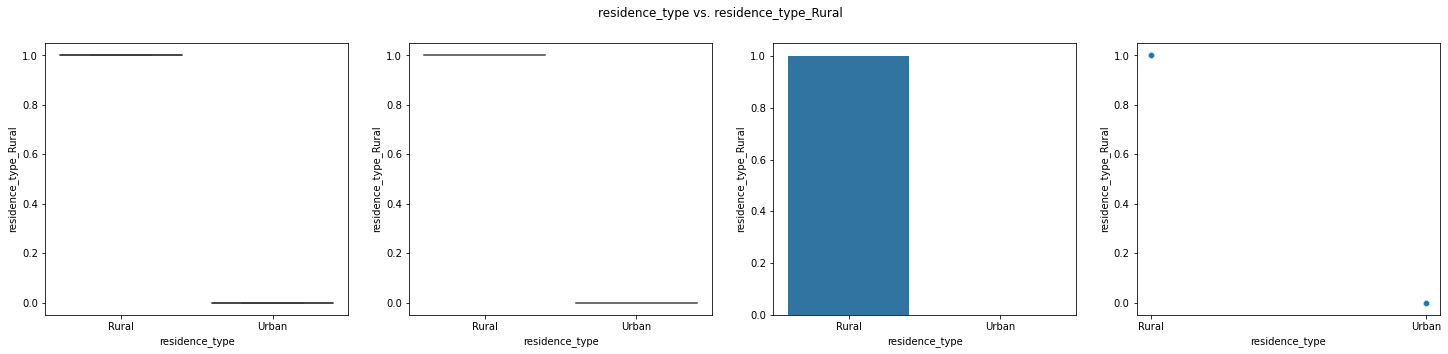

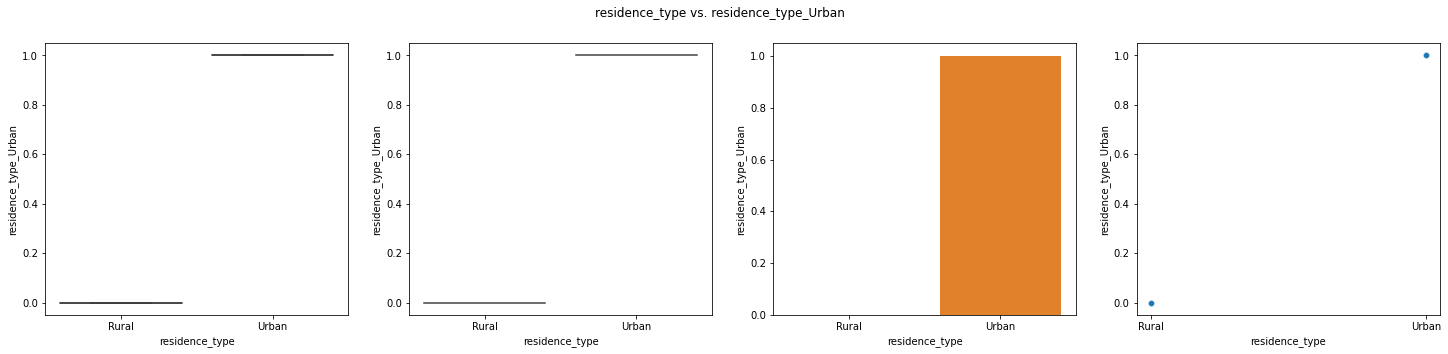

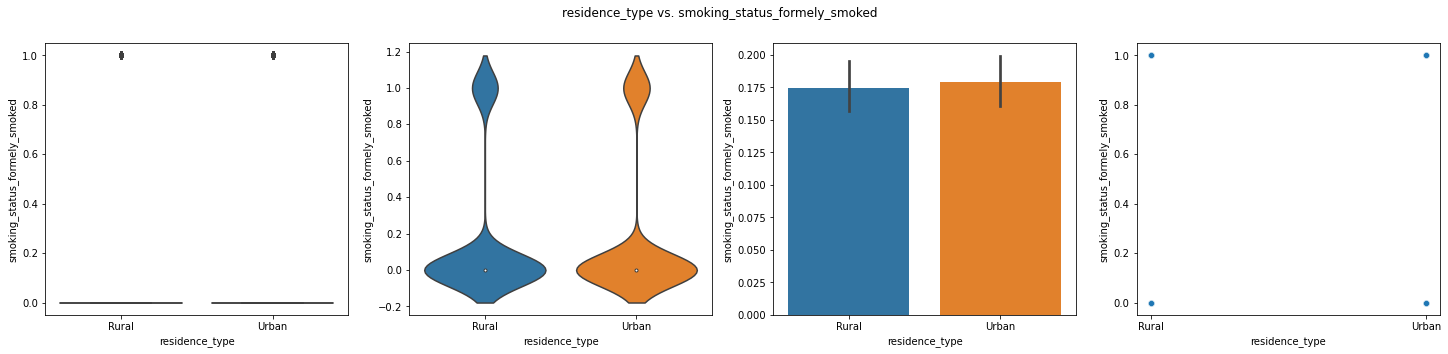

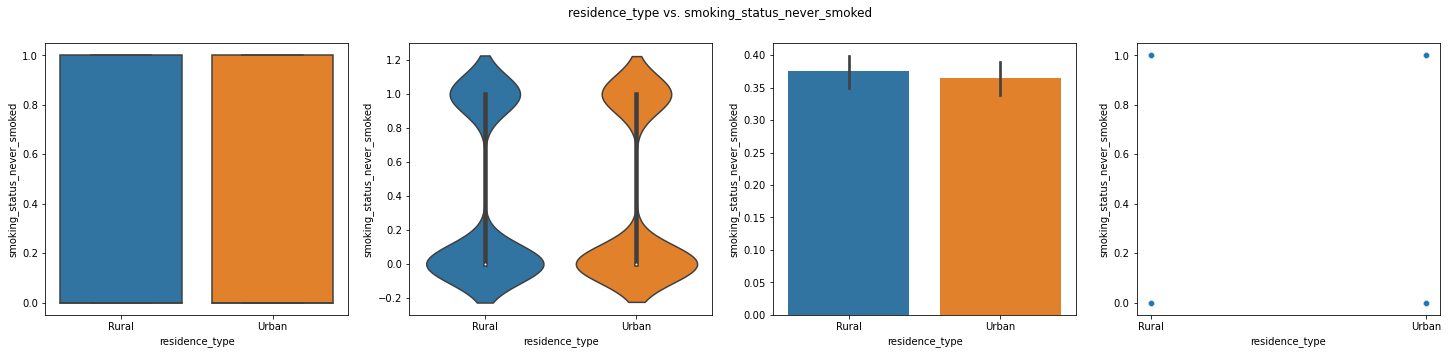

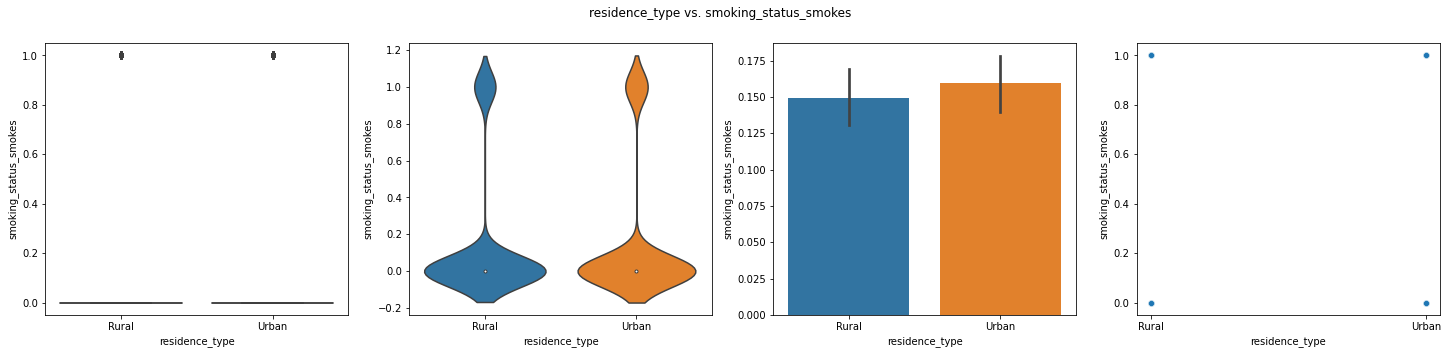

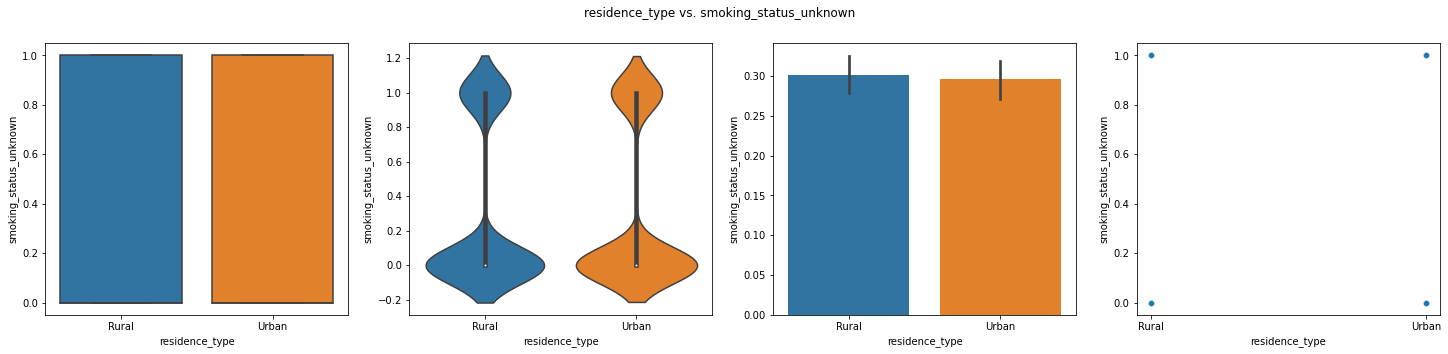

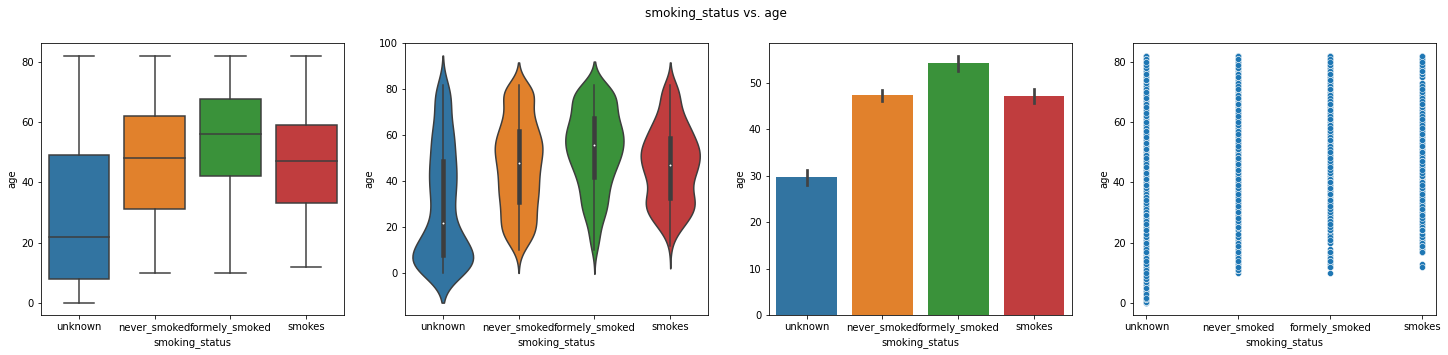

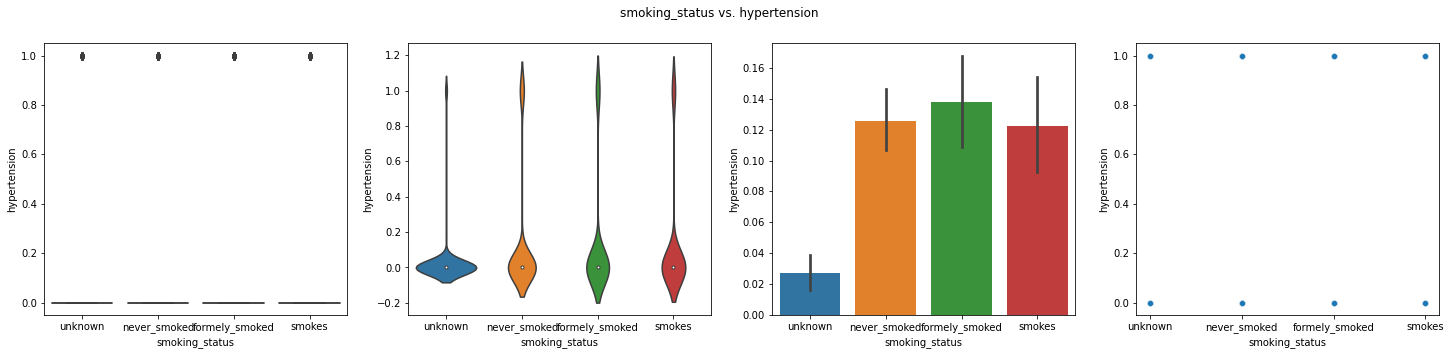

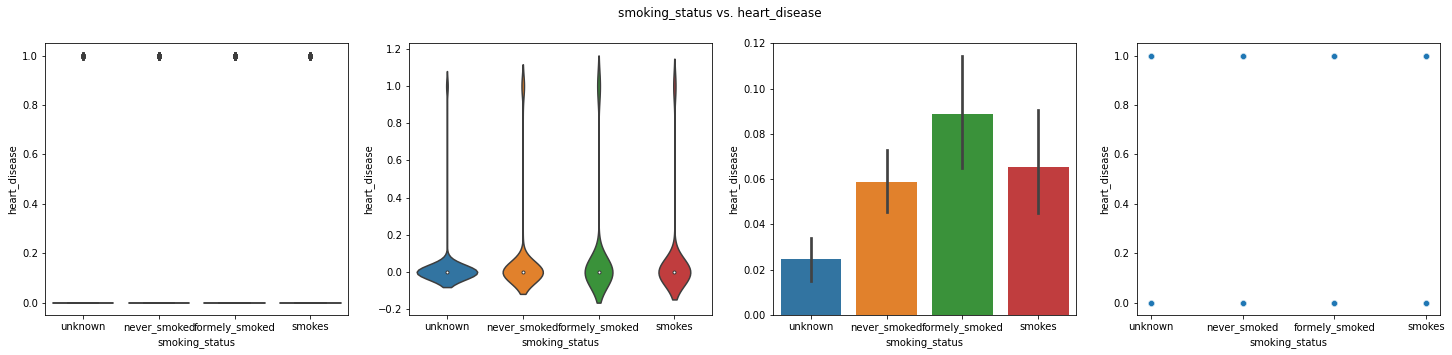

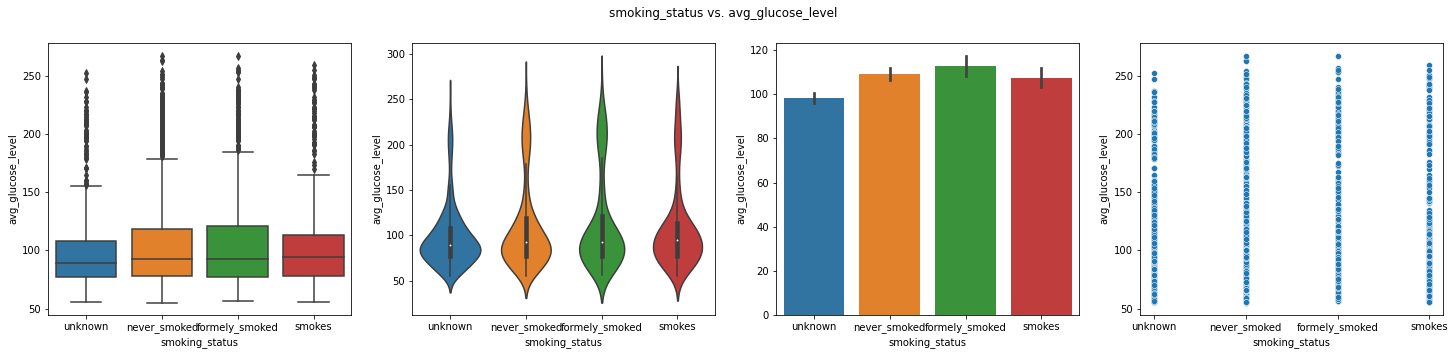

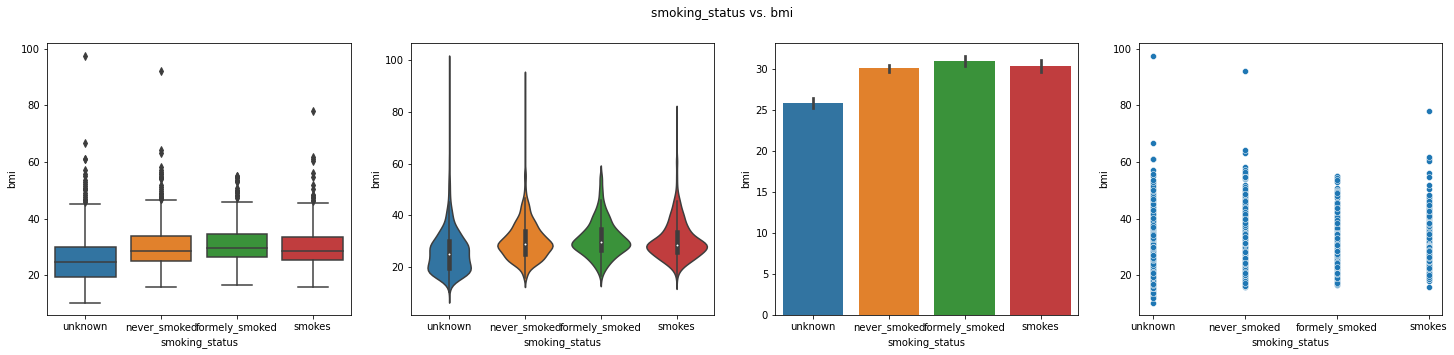

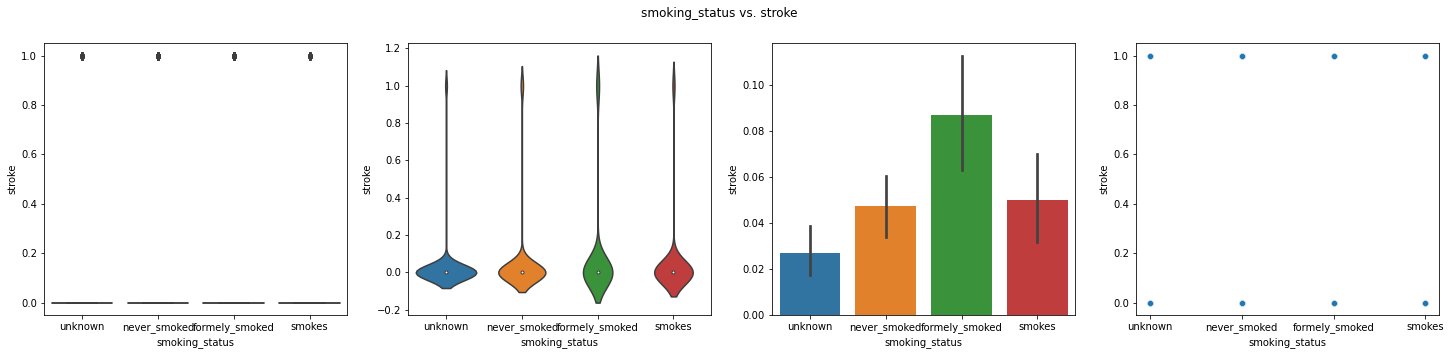

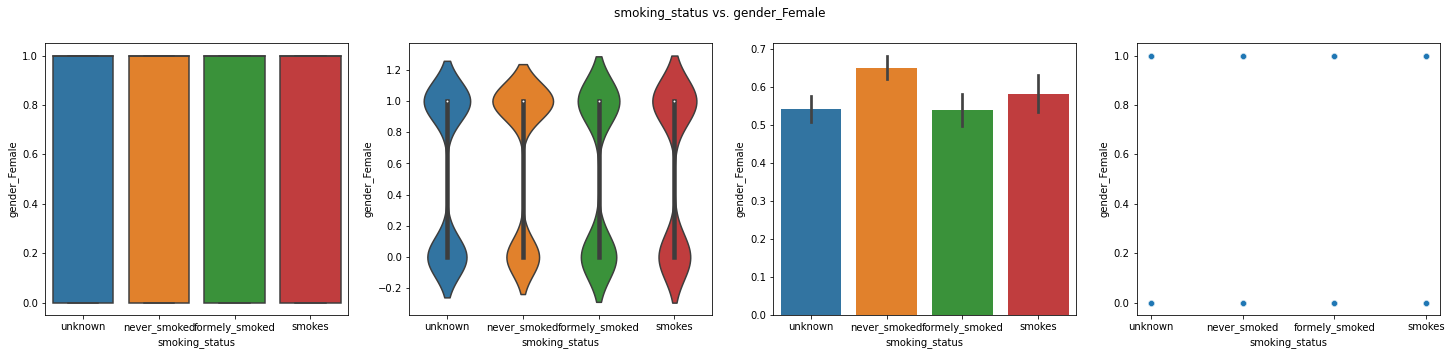

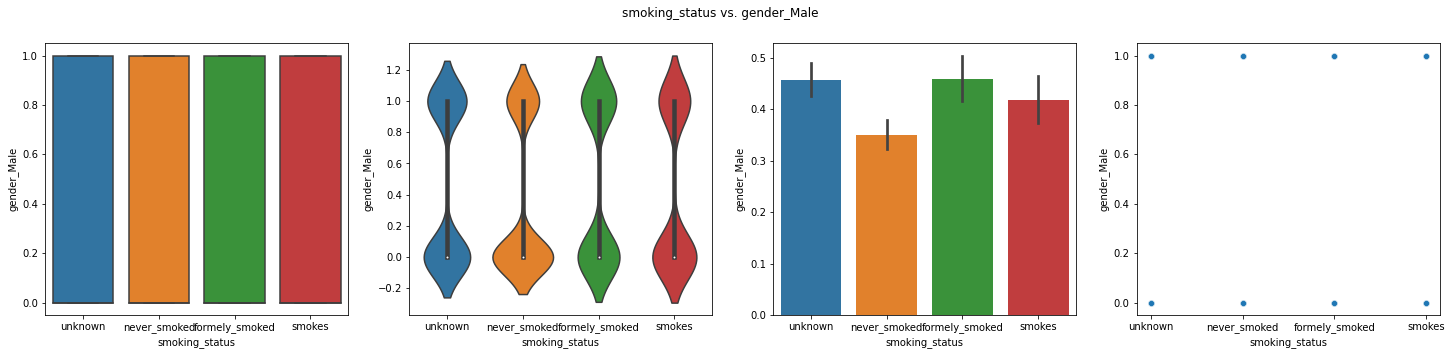

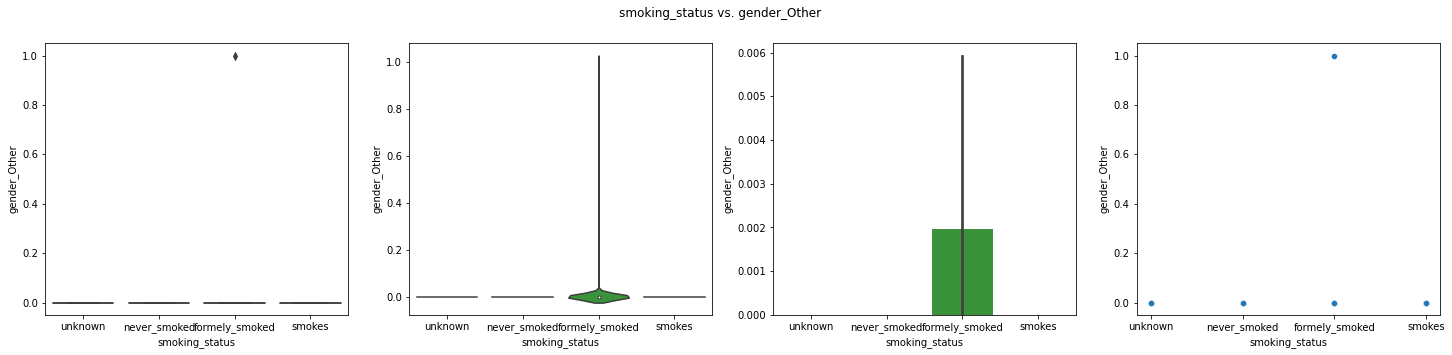

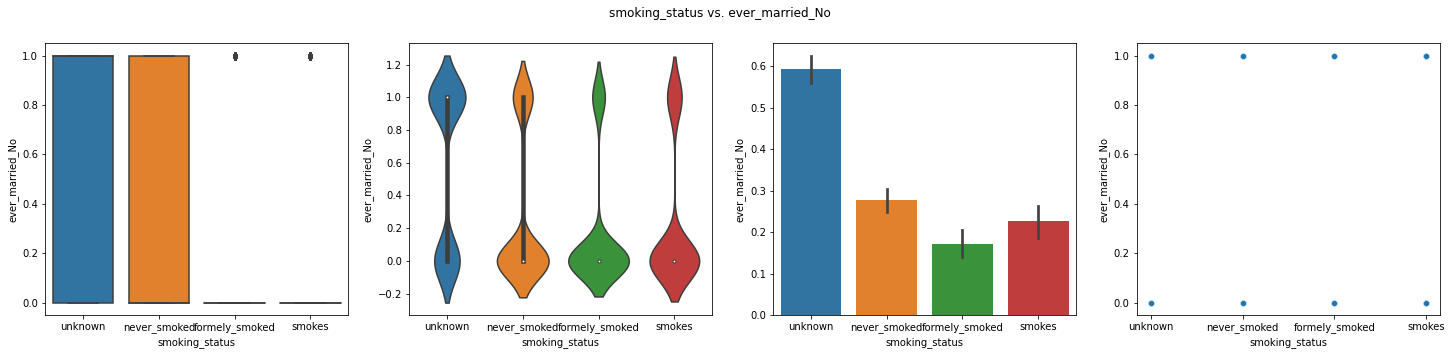

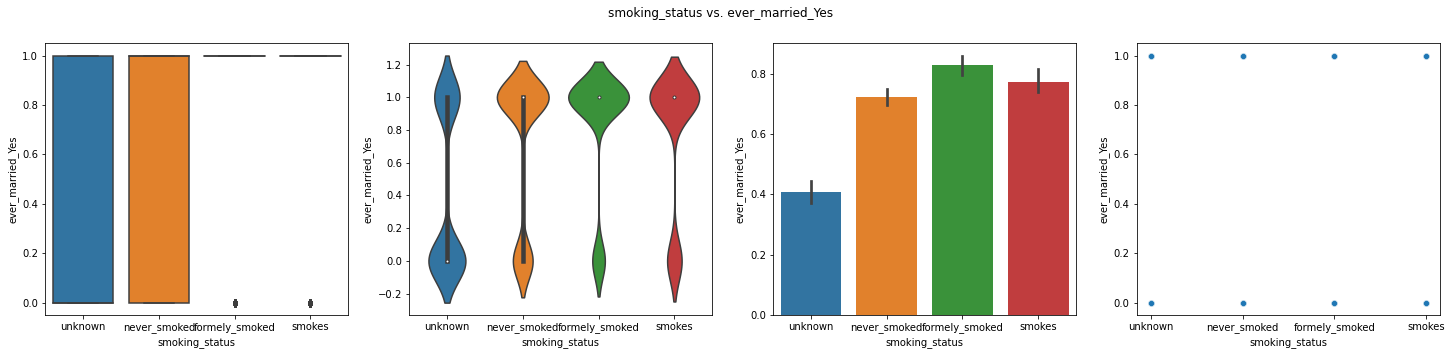

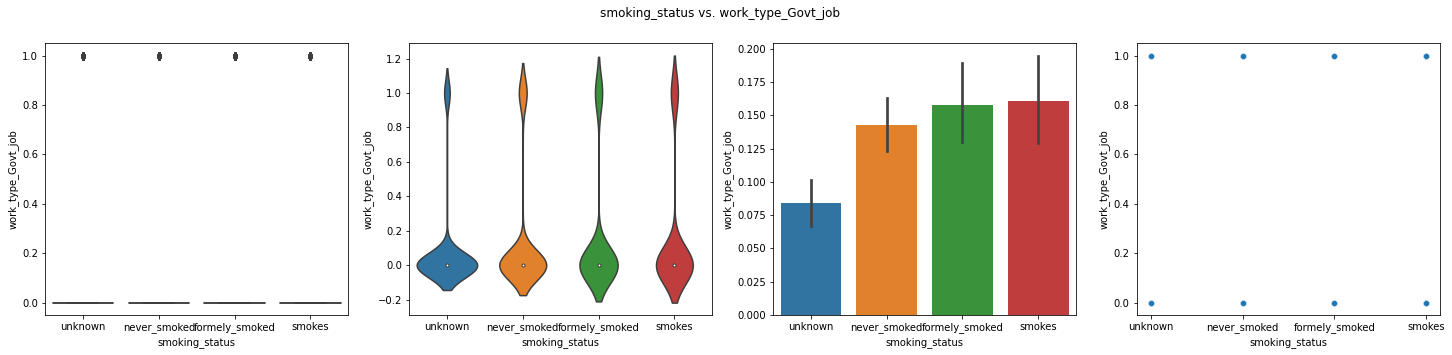

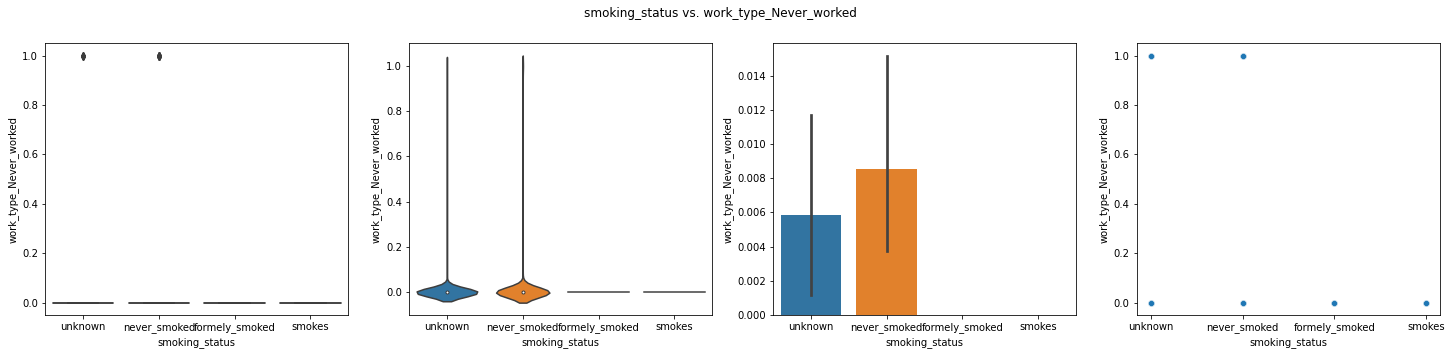

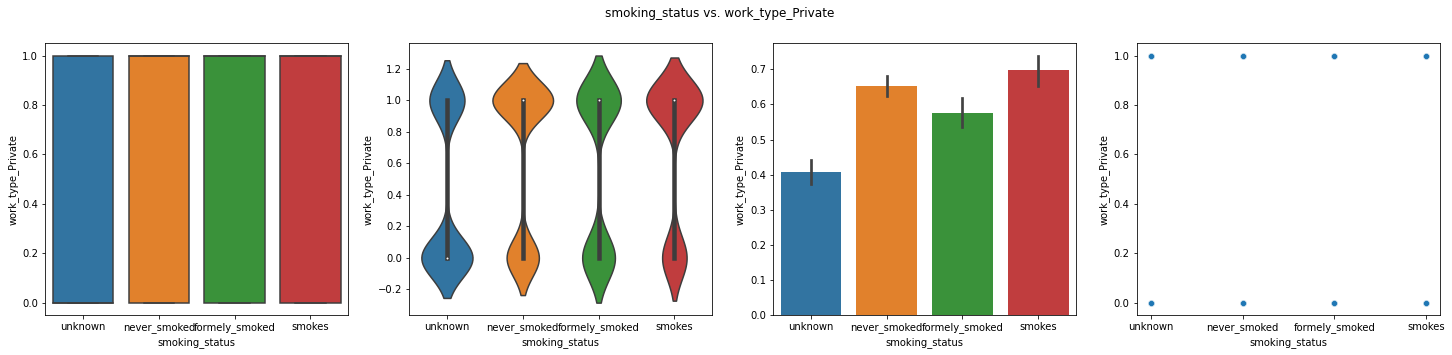

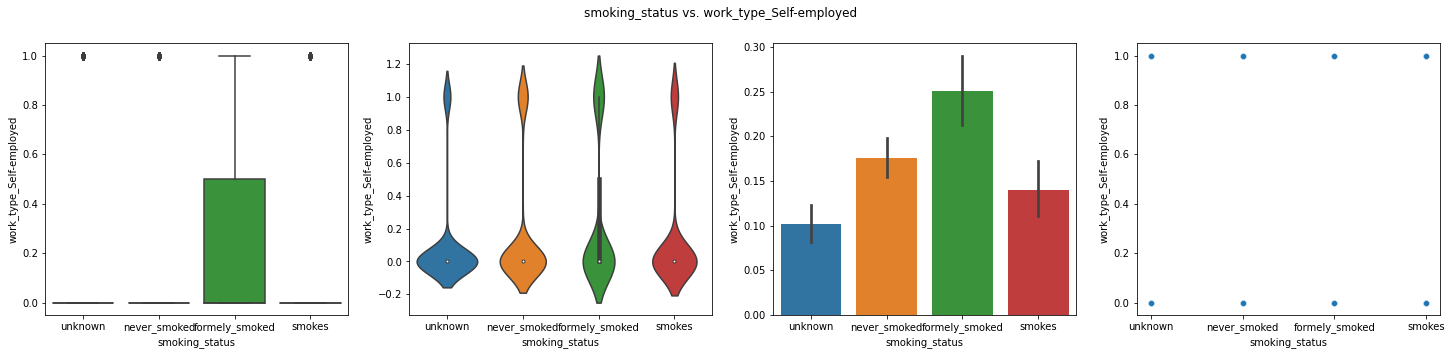

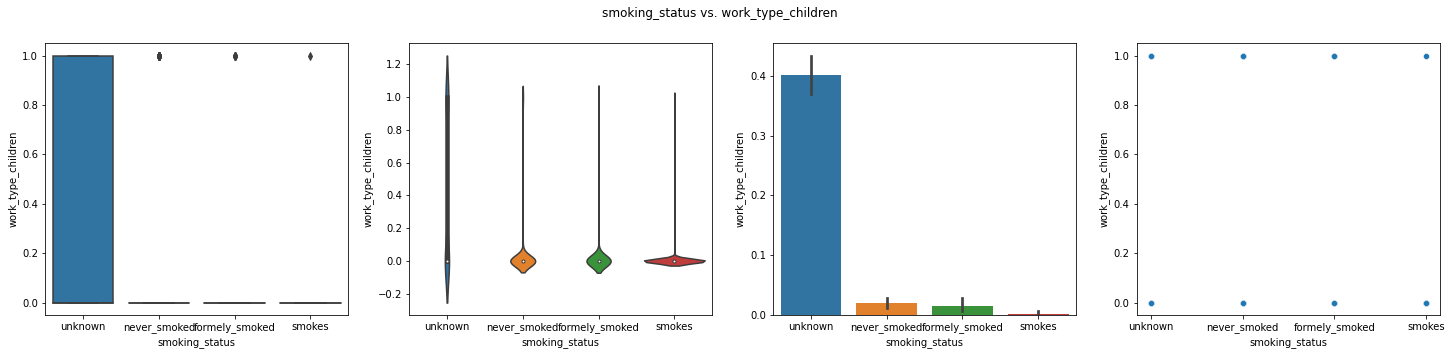

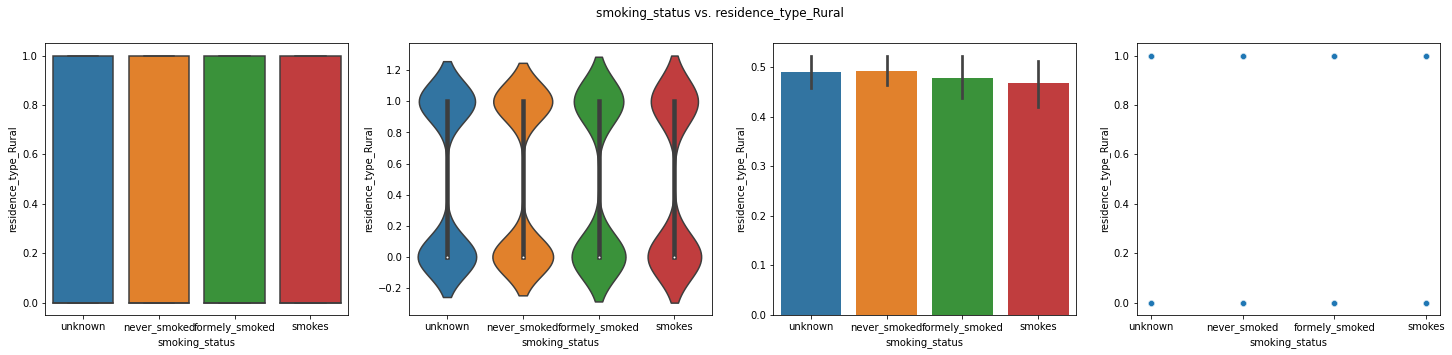

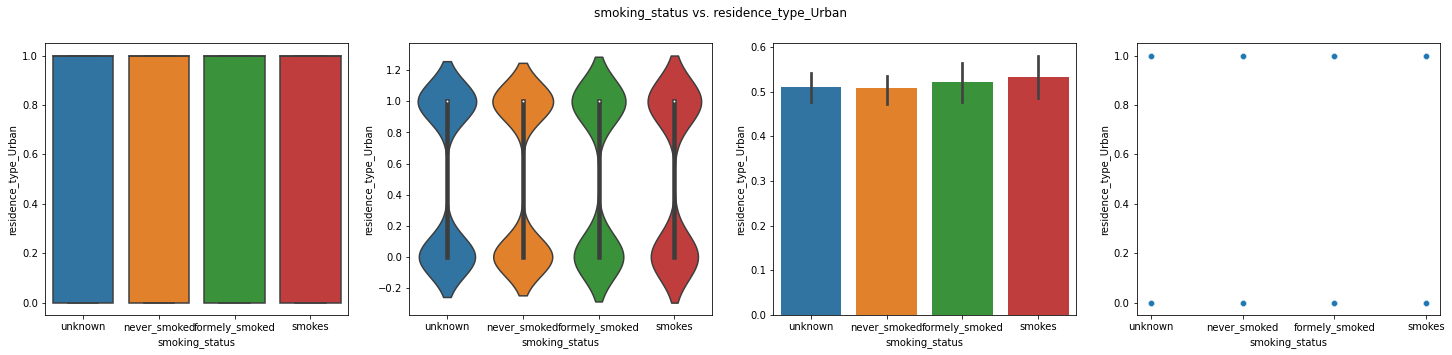

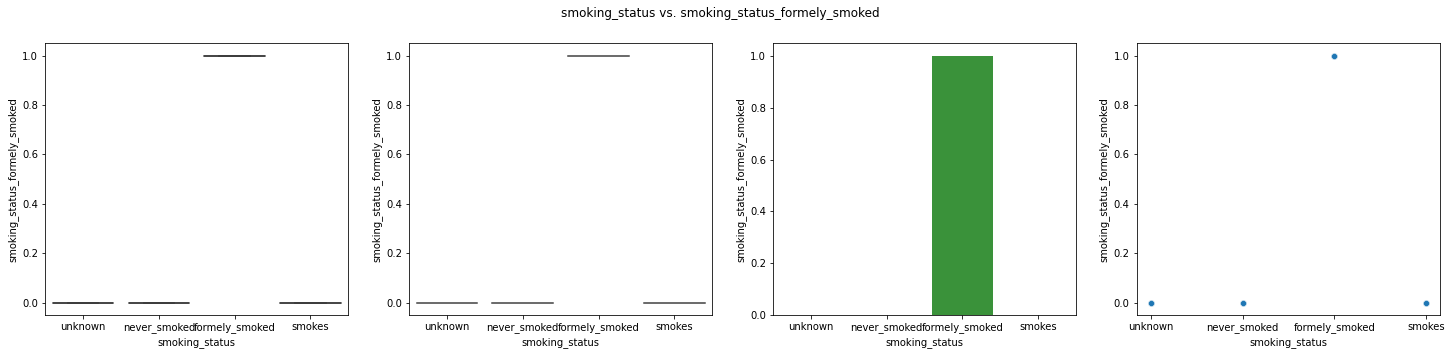

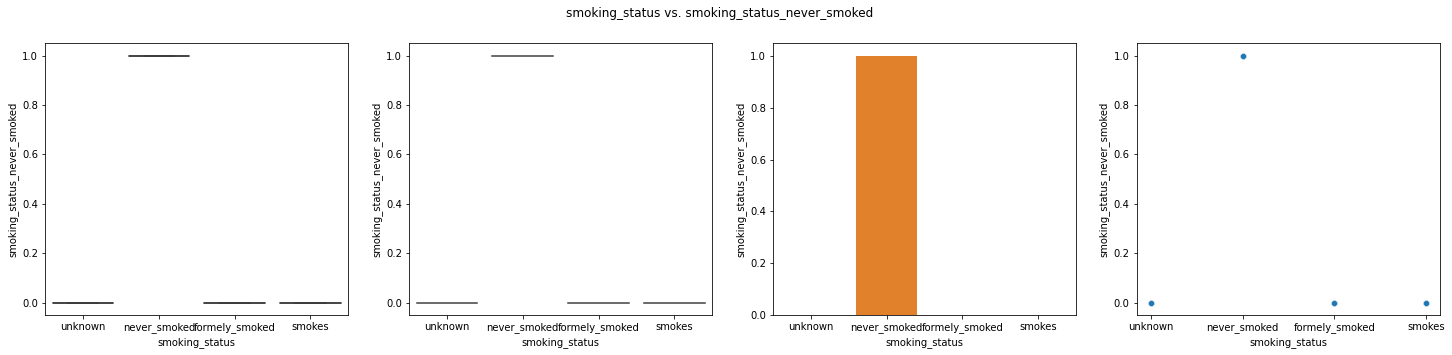

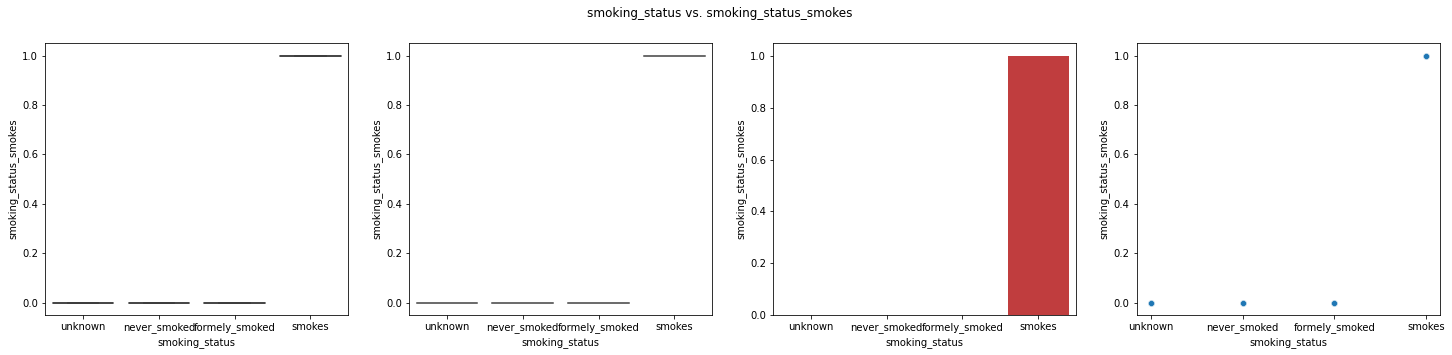

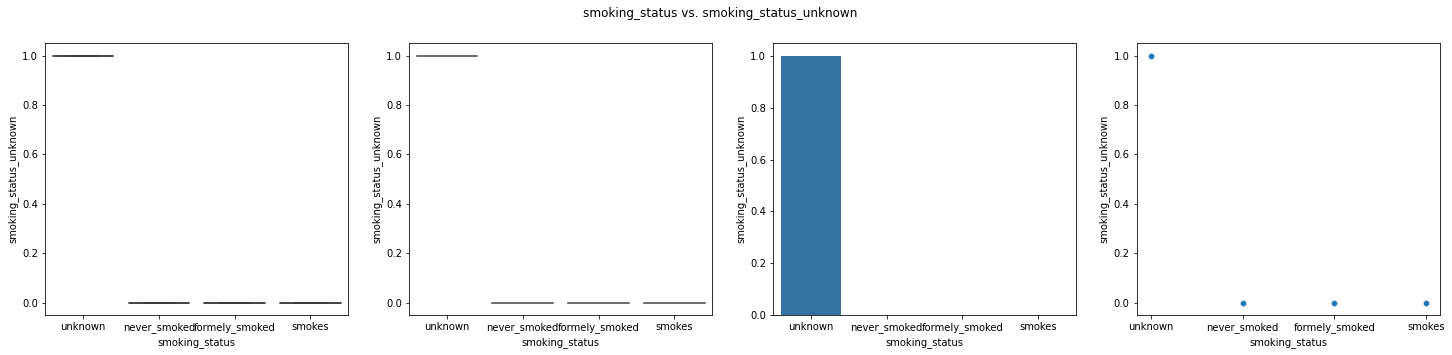

In [29]:
plot_categorical_and_continuous_vars2(train)

<AxesSubplot:xlabel='gender', ylabel='age'>

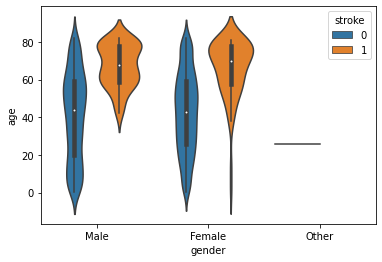

In [30]:
sns.violinplot(data=train, x='gender',y='age',hue='stroke')

<AxesSubplot:xlabel='gender', ylabel='age'>

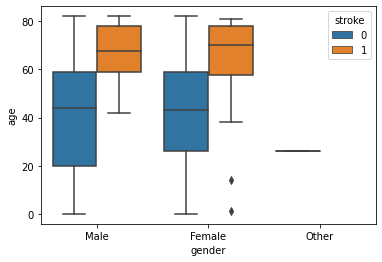

In [31]:
sns.boxplot(data=train, x='gender',y='age',hue='stroke')

<AxesSubplot:xlabel='ever_married', ylabel='age'>

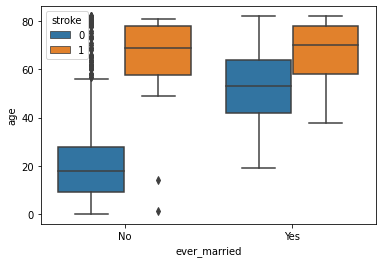

In [32]:
sns.boxplot(data=train, x='ever_married',y='age',hue='stroke')

# second set stroke as hue

In [33]:
def plot_categorical_and_continuous_vars(df, cat_vars, cont_vars):
    for col in cat_vars:
        for col2 in cont_vars:
            fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,6))
            fig.suptitle(f'{col} vs. {col2}')
            sns.boxplot(data=df, x=col, y=col2, ax=ax1,hue='stroke')
            sns.violinplot(data=df, x=col, y=col2, ax=ax2,hue='stroke')
            sns.barplot(data=df, x=col, y=col2, ax=ax3,hue='stroke')
            plt.show()

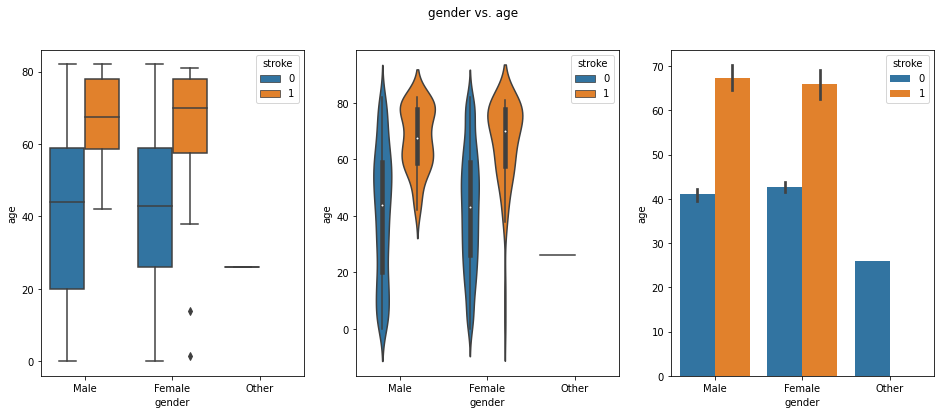

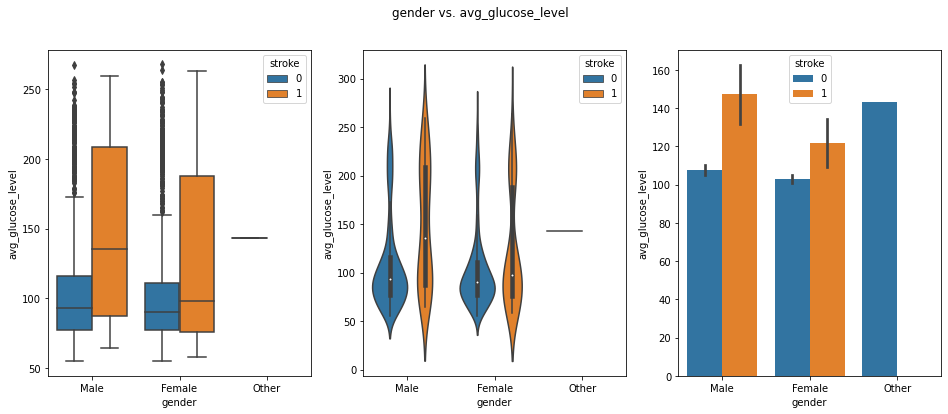

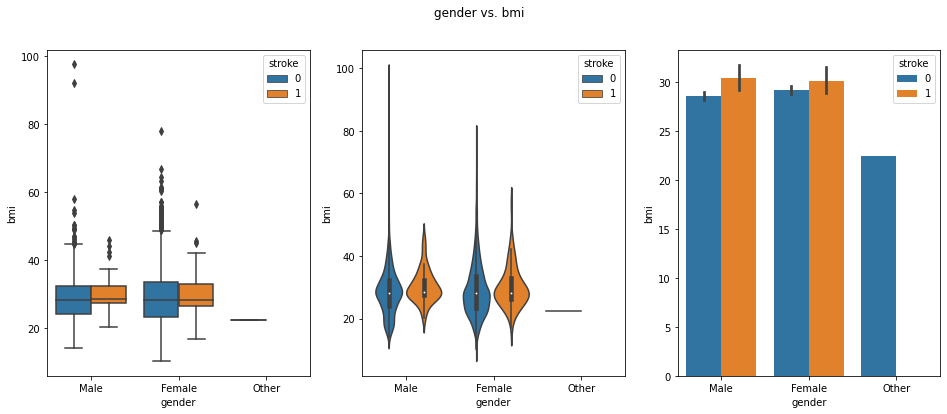

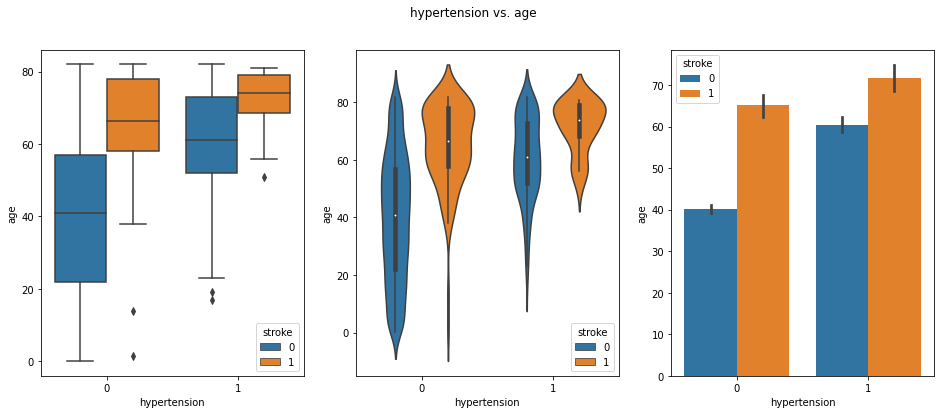

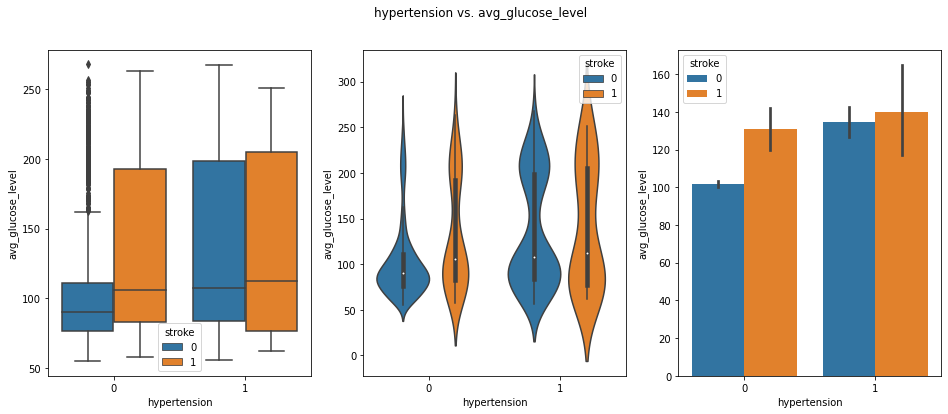

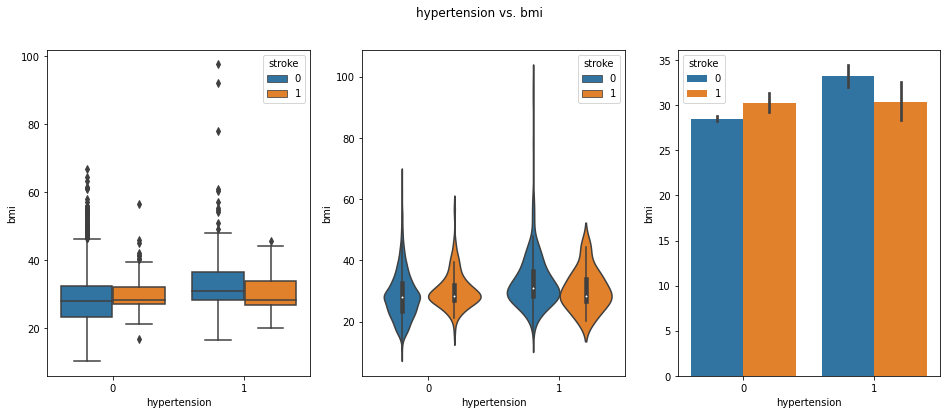

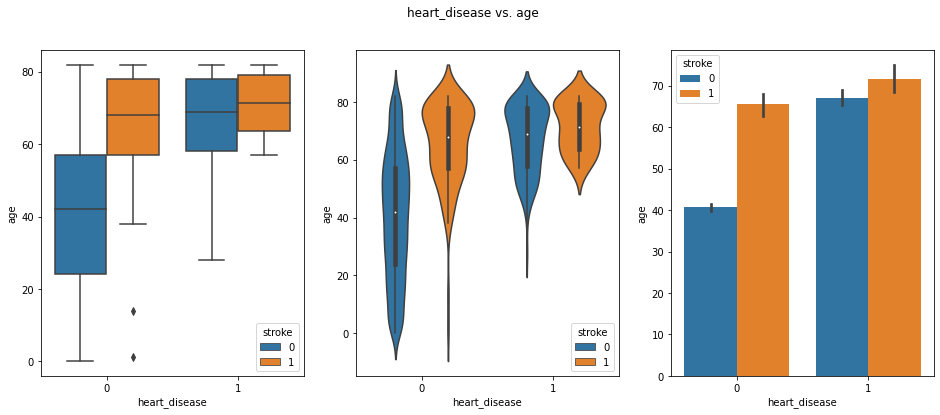

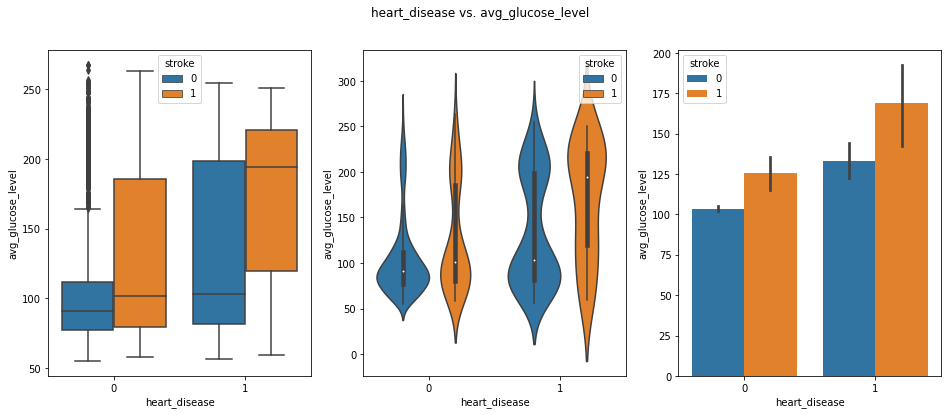

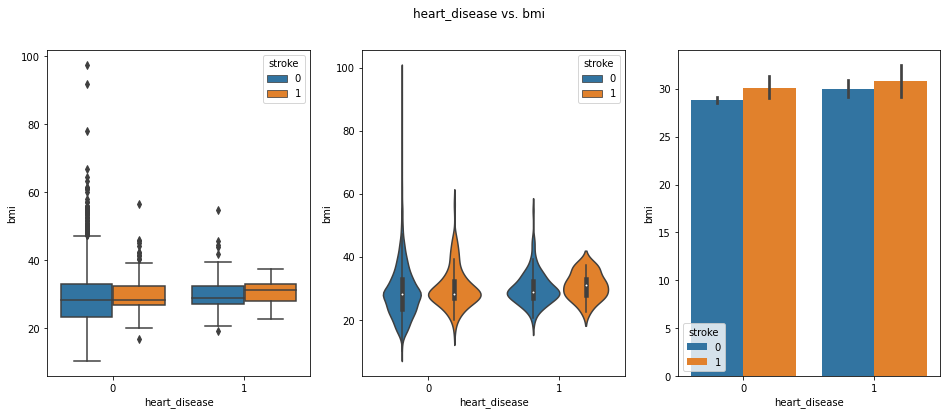

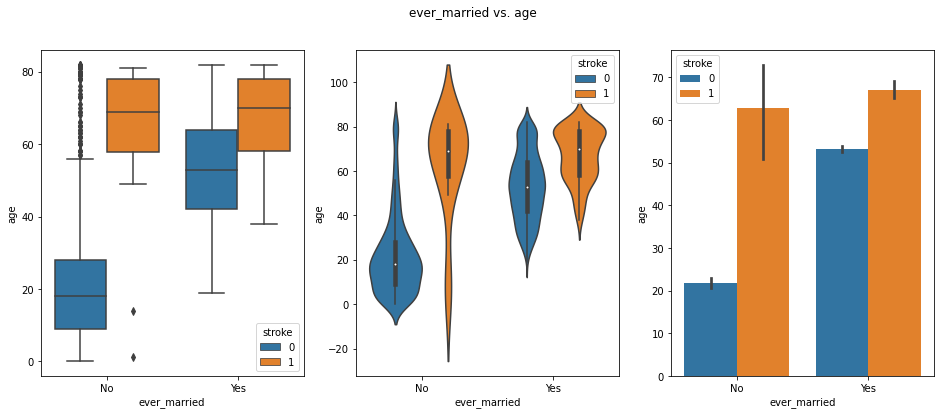

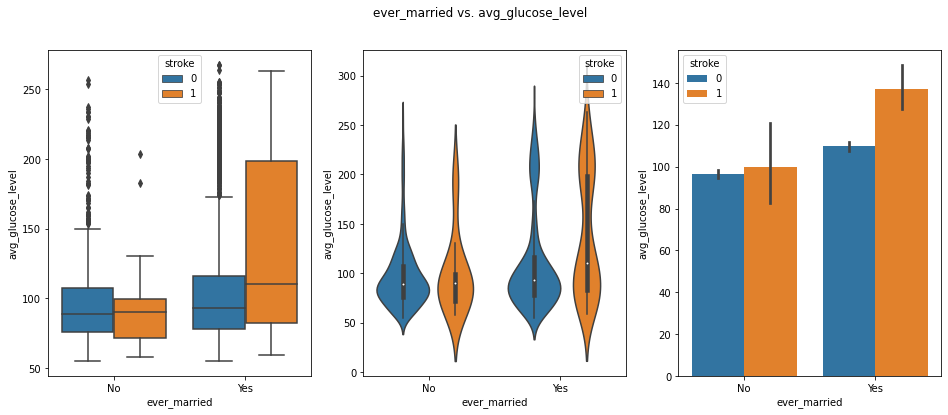

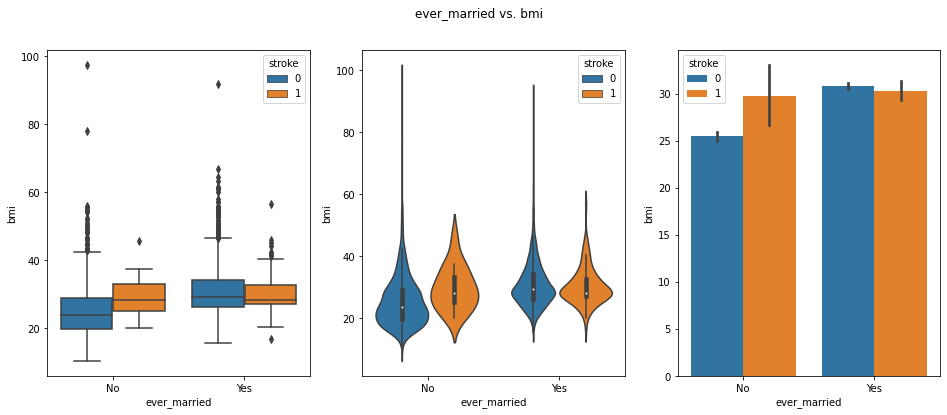

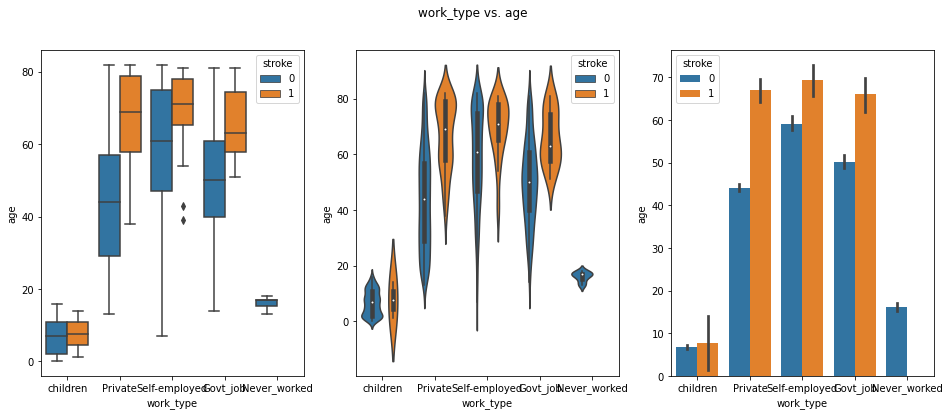

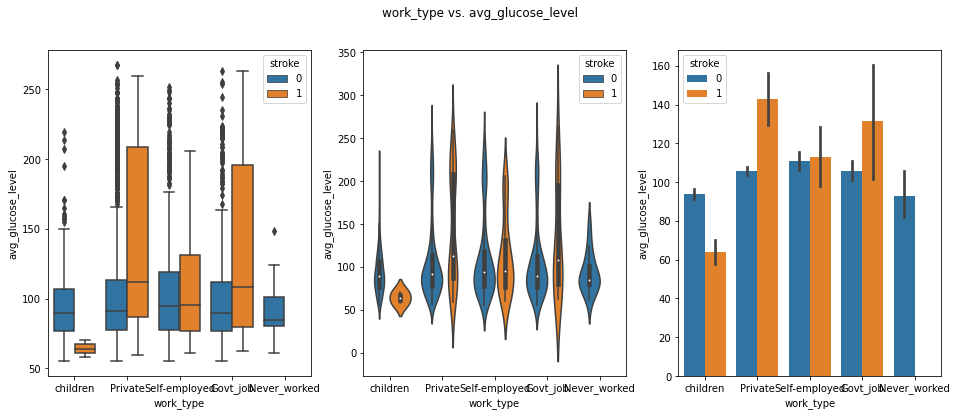

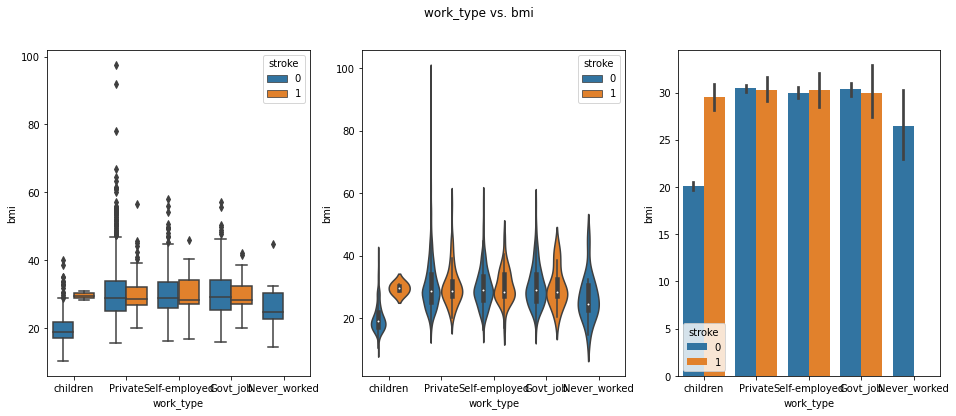

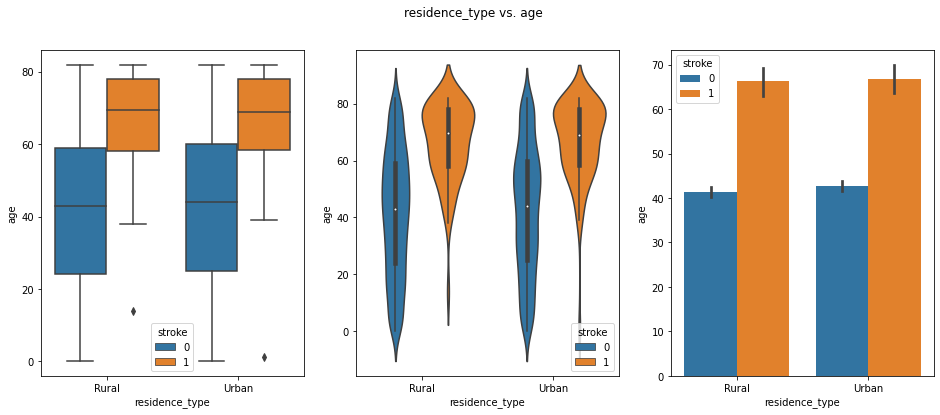

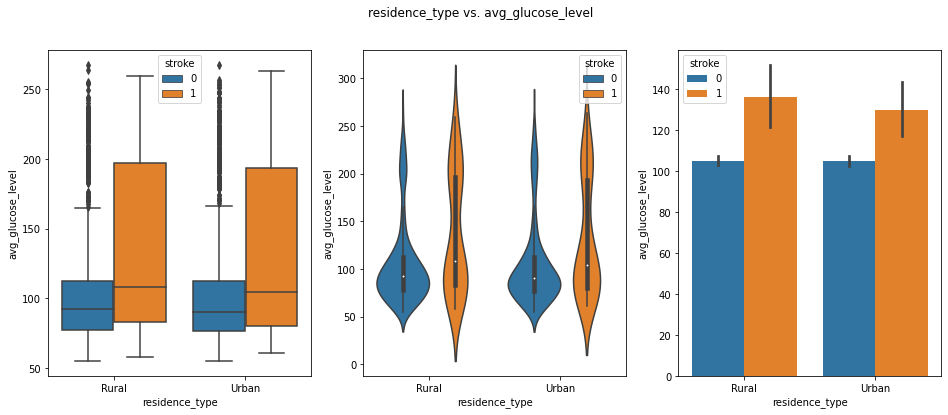

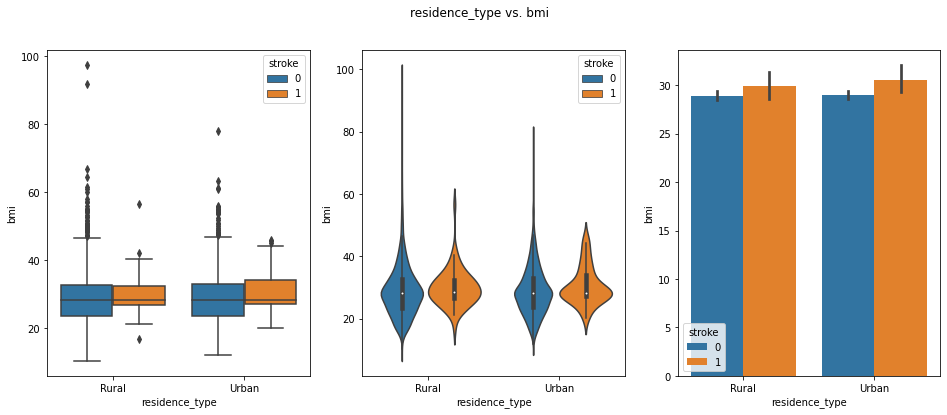

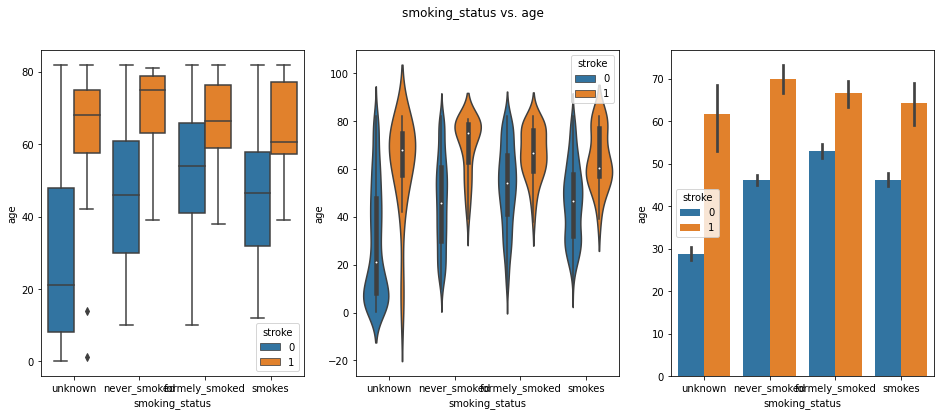

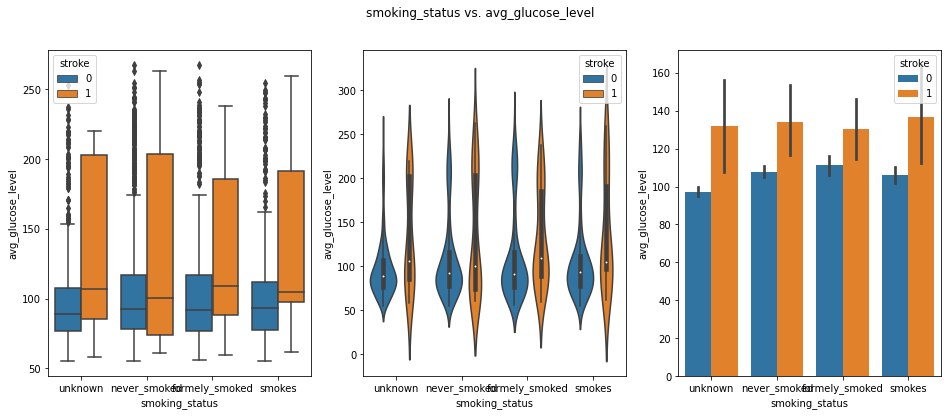

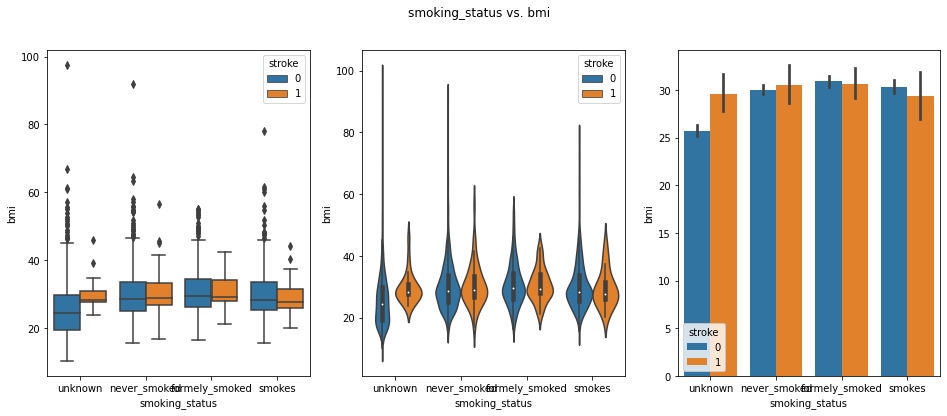

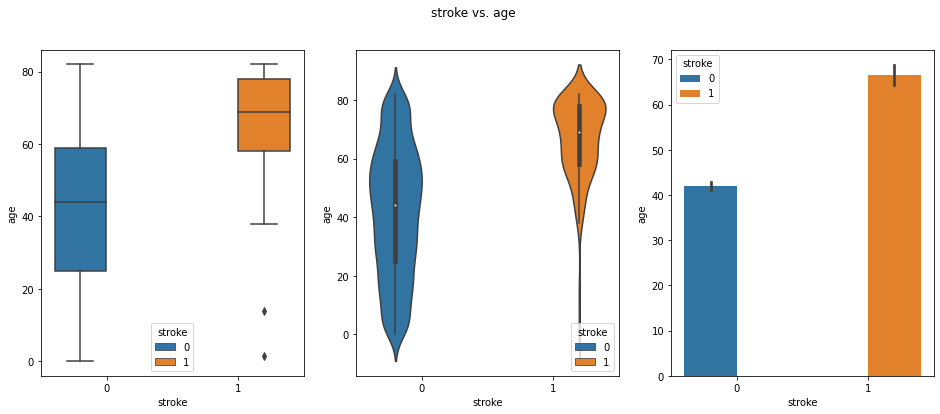

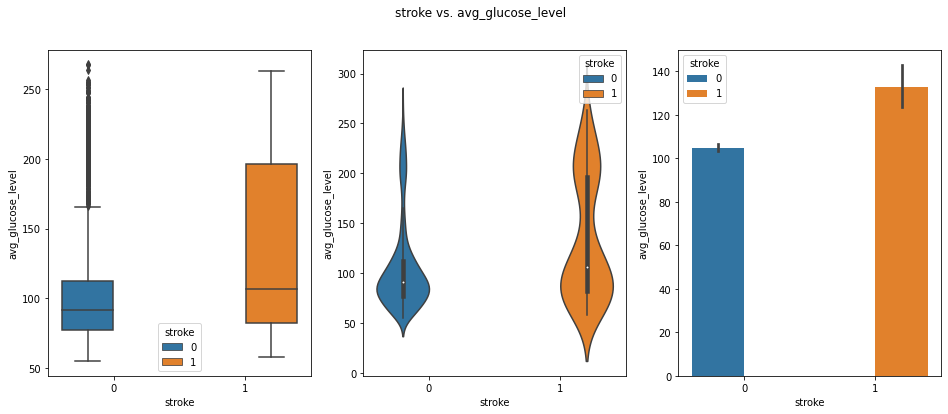

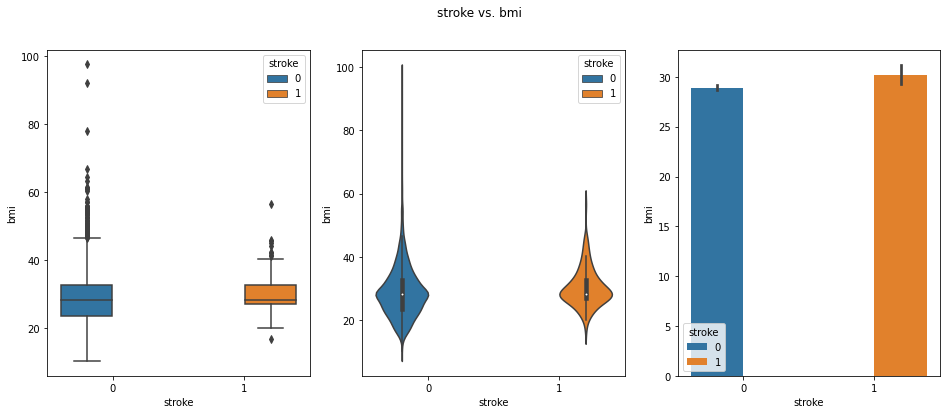

In [34]:
plot_categorical_and_continuous_vars(train, categorical, continuous)

<AxesSubplot:title={'center':'storke and age'}, xlabel='age', ylabel='Count'>

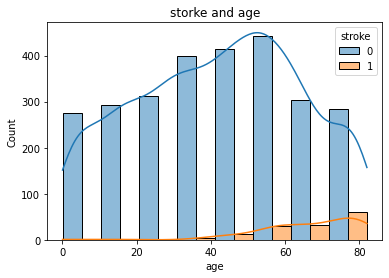

In [35]:
plt.title('storke and age')
sns.histplot(x='age', data=train, hue='stroke',multiple='dodge', kde= True, bins = 8)

<AxesSubplot:title={'center':'storke and age'}, xlabel='age', ylabel='Percent'>

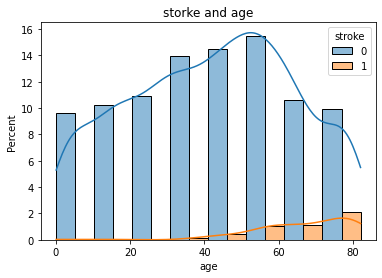

In [36]:
plt.title('storke and age')
sns.histplot(x='age', data=train, hue='stroke',multiple='dodge', kde= True, bins = 8,stat='percent')

# Stats

In [37]:
# pearsonr r for continuous variables
for i in continuous:
    α =0.05
    corr, p = stats.pearsonr(train[i], train.stroke)
    print('_____________________________________________________')
    print('HYPOTHESIS')
    print(f'H0: There is no significant difference between stroke in different {i}')
    print(f'Ha:(There is a significant difference between stroke in different {i}')
    print(f'{i} correlation {corr}, p-val{p}')
    if p < α:
        print('We reject the null hypothesis.')
        print(f'There is a correlation between stroke and {i}')
    else:
        print('We fail to reject the null hypothesis.')
        print(f'There is no correlation between stroke and {i}')

_____________________________________________________
HYPOTHESIS
H0: There is no significant difference between stroke in different age
Ha:(There is a significant difference between stroke in different age
age correlation 0.235579153113306, p-val2.248722003303099e-37
We reject the null hypothesis.
There is a correlation between stroke and age
_____________________________________________________
HYPOTHESIS
H0: There is no significant difference between stroke in different avg_glucose_level
Ha:(There is a significant difference between stroke in different avg_glucose_level
avg_glucose_level correlation 0.13174680273110426, p-val1.497808221989955e-12
We reject the null hypothesis.
There is a correlation between stroke and avg_glucose_level
_____________________________________________________
HYPOTHESIS
H0: There is no significant difference between stroke in different bmi
Ha:(There is a significant difference between stroke in different bmi
bmi correlation 0.035820768297477434, p-val0.0

### BMI is not correlated with stroke, age and avg_glucose are correlated with stroke

In [38]:
def get_chi_significance_level(train,variable):    
    # Chi-Square test to compare two categorical variables (senior citizen status, churn)

    alpha = 0.05

    # Setup a crosstab of observed 
    observed = pd.crosstab(train[variable]== 1, train.stroke)

    chi2, p, degf, expected = stats.chi2_contingency(observed)

    chi2 = chi2
    p = p
    print(f' Chi-Square:{chi2}')
    print(f' p-value:{1-p}')

In [39]:
def get_chi(train,variable):    
    # Chi-Square test to compare two categorical variables (senior citizen status, churn)

    alpha = 0.05

    # Setup a crosstab of observed 
    observed = pd.crosstab(train[variable]== 1, train.stroke)

    chi2, p, degf, expected = stats.chi2_contingency(observed)

    chi2 = chi2
    p = p
    print(f' Chi-Square:{chi2}')
    print(f' p-value:{p}')
    

In [40]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'gender_Female', 'gender_Male',
       'gender_Other', 'ever_married_No', 'ever_married_Yes',
       'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'residence_type_Rural',
       'residence_type_Urban', 'smoking_status_formely_smoked',
       'smoking_status_never_smoked', 'smoking_status_smokes',
       'smoking_status_unknown'],
      dtype='object')

In [41]:
train.smoking_status_unknown

4600    1
3431    1
1557    0
3899    0
1212    0
       ..
336     1
4449    0
1760    0
42      0
1152    0
Name: smoking_status_unknown, Length: 2861, dtype: uint8

In [42]:
chi_columns =['gender', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 
       'smoking_status', 'stroke', 'gender_Female', 'gender_Male', 'gender_Other',
       'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'residence_type_Rural',
       'residence_type_Urban', 'smoking_status_formely_smoked',
       'smoking_status_never_smoked', 'smoking_status_smokes',
       'smoking_status_unknown']

for i in chi_columns:
    print(i)
    get_chi(train,i)
    print('_____________')

gender
 Chi-Square:0.0
 p-value:1.0
_____________
hypertension
 Chi-Square:24.45069324334392
 p-value:7.623607564219725e-07
_____________
heart_disease
 Chi-Square:36.73001998146243
 p-value:1.356740136221253e-09
_____________
ever_married
 Chi-Square:0.0
 p-value:1.0
_____________
work_type
 Chi-Square:0.0
 p-value:1.0
_____________
residence_type
 Chi-Square:0.0
 p-value:1.0
_____________
smoking_status
 Chi-Square:0.0
 p-value:1.0
_____________
stroke
 Chi-Square:2839.4070974444367
 p-value:0.0
_____________
gender_Female
 Chi-Square:0.15368001278299137
 p-value:0.6950431230790826
_____________
gender_Male
 Chi-Square:0.16052411046216272
 p-value:0.6886744388602318
_____________
gender_Other
 Chi-Square:0.0
 p-value:1.0
_____________
ever_married_No
 Chi-Square:33.01784652416314
 p-value:9.131679279313294e-09
_____________
ever_married_Yes
 Chi-Square:33.01784652416314
 p-value:9.131679279313294e-09
_____________
work_type_Govt_job
 Chi-Square:0.0
 p-value:1.0
_____________
work_typ

### Columns that have a relationship with stroke
hypertension, heart_disease,ever_married_No, ever_married_Yes,work_type_Self-employed, 
* work_type_children? not sure why being a child increases chances of stroke

* smoking_status_(unknonw, formerly smoked, )

### Columns that have no relationship with stroke
gender,worktype(govt, never_worked, private),never_smoked
smoking status_smokes is .999 so not related to stroke?

In [43]:
train[train.work_type_children==1].stroke.mean(),train[train.smoking_status_Unknown==1].stroke.mean(),train[train['smoking_status_formerly smoked']==1].stroke.mean()

AttributeError: 'DataFrame' object has no attribute 'smoking_status_Unknown'

In [ ]:
chi_columns =['gender','hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 
       'smoking_status', 'stroke', 'gender_Female', 'gender_Male',
       'gender_Other', 'ever_married_No', 'ever_married_Yes',
       'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',
       'Residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes']

for i in chi_columns:
    print(i)
    get_chi_significance_level(train,i)
    print('_____________')

In [ ]:
train.head()

In [ ]:
train.columns

In [ ]:
observed = pd.crosstab(train['hypertension']==1, train.stroke)

In [ ]:
observed

In [ ]:
observed = pd.crosstab(train['hypertension'], train.stroke)
observed

In [ ]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

chi2 = chi2.round(4)
p = p.round(4)
print(f' Chi-Square:{chi2}')
print(f' p-value:{p}')

# Model

In [ ]:
train.columns

In [ ]:
def model_prep(train,validate,test, features):
    
    ''' This function takes in data that has been split into train, validate and test and prepares for modeling 
        by removing features not used for modeling and seperating the target variable into its own dataframe.
        The following features are keept for modeling: 'monthly_charges','senior_citizen','tenure', 'partner_No',
        'partner_Yes','churn','contract_type_Month-to-month','contract_type_One year','contract_type_Two year', 
        Six data frames seperating the target variale from the selected features per train, validate and test 
        are returned
    '''
    
    # drop unused columns and keep some features
    features = features
    train =train[features]
    validate = validate[features]
    test = test[features]
        
    #seperate target
    x_train = train.drop(columns=['stroke'])
    y_train = train.stroke

    x_validate = validate.drop(columns=['stroke'])
    y_validate = validate.stroke

    x_test = test.drop(columns=['stroke'])
    y_test = test.stroke
        
    # Convert binary categorical target variable to numeric
    return x_train,y_train,x_validate,y_validate, x_test, y_test

In [ ]:
train.eve

In [ ]:
stat_features = ['age','avg_glucose_level','hypertension','heart_disease','ever_married_Yes',
'work_type_Self-employed','smoking_status_formely_smoked', 'smoking_status_unknown','stroke']

In [ ]:
X_train,y_train,X_validate,y_validate, X_test, y_test = model_prep(train,validate,test,stat_features)

In [ ]:
y_validate.shape,X_validate.shape,X_train.shape,y_train.shape,X_test.shape, y_test.shape

In [ ]:
train.shape

In [ ]:
train.stroke.value_counts()

In [ ]:
2649/ 2788

In [ ]:
# baseline is 95% accuracy
baseline = y_train.mode()
baseline

X_train['baseline_prediction'] = int(baseline)
X_train


In [ ]:
#Loop for models
for i in range(1, 21):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i,min_samples_split = 5, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = tree.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

In [ ]:
y_validate.shape,X_validate.shape,X_train.shape,y_train.shape

In [ ]:

metrics = []

for i in range(1, 25):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)
    

    
    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(X_train, y_train)
    
    
    
    out_of_sample_accuracy = tree.score(X_validate, y_validate)

    # calculate recall train
    y_pred = tree.predict(X_train)
    in_sample_recall= recall_score(y_train, y_pred)  
      
    # calculate recall validate
    y_pred = tree.predict(X_validate)
    out_of_sample_recall= recall_score(y_validate, y_pred)
    
    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy,
        'train_recall': in_sample_recall,
        'validate_recall': out_of_sample_recall
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["accuracy_difference"] = df.train_accuracy - df.validate_accuracy
df["recall_difference"] = df.train_recall - df.validate_recall
df

In [ ]:
df.sort_values(by=['recall_difference', 'train_recall'])

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.max_depth, df.train_accuracy, marker = 'o', label = 'Train')
plt.plot(df.max_depth, df.validate_accuracy, marker = 'o', label = 'Validate')


#plt.plot(df_2.max_depth, df_2.validate_accuracy, marker = 'x', label = 'Validate')

plt.title('Overfitting Occurs at Higher Values for Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Random forest changing leaf

for i in range(1, 21):
  
    # Make the model
    random_forest = RandomForestClassifier(max_depth=10, min_samples_leaf = i , random_state=123)

    # Fit the model (on train and only train)
    random_forest = random_forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_pred = random_forest.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_pred, output_dict=True)
    print(f"Tree with min sample leaf {i}")
    print(pd.DataFrame(report))
    print()
    
    
    # create data frame
        # calculate recall train
    y_pred = random_forest.predict(X_train)
    in_sample_recall= recall_score(y_train, y_pred)
    
    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = random_forest.score(X_train, y_train)
    
    
    
    out_of_sample_accuracy = random_forest.score(X_validate, y_validate)

    
      
    # calculate recall validate
    y_pred = random_forest.predict(X_validate)
    out_of_sample_recall= recall_score(y_validate, y_pred)
    
    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy,
        'train_recall': in_sample_recall,
        'validate_recall': out_of_sample_recall
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["accuracy_difference"] = df.train_accuracy - df.validate_accuracy
df["recall_difference"] = df.train_recall - df.validate_recall
df
 

In [ ]:
# Random forest changing max-depth and leaf
metrics =[]
for h in range(10,0,-1):
    print(f'max depth {h}')
    for i in range(1, 21):
  
        # Make the model
        random_forest = RandomForestClassifier(max_depth=h, min_samples_leaf = i , random_state=123)

        # Fit the model (on train and only train)
        random_forest = random_forest.fit(X_train, y_train)

        # Use the model
        # We'll evaluate the model's performance on train, first
        y_pred = random_forest.predict(X_train)
        # calculate recall validate

        in_sample_recall= recall_score(y_train, y_pred)     

        # Produce the classification report on the actual y values and this model's predicted y values
        report = classification_report(y_train, y_pred, output_dict=True)
        print(f"Tree with min sample leaf {i}")
        print(f'max depth {h}')
        print(pd.DataFrame(report))
        print()
        
        
        # calculate recall validate
        y_pred = random_forest.predict(X_validate)
        out_of_sample_recall= recall_score(y_validate, y_pred)
        
        # Produce the classification report on the actual y values and this model's predicted y values
        report = classification_report(y_validate, y_pred, output_dict=True)
        print(f"Tree with min sample leaf {i}")
        print(f'max depth {h}')
        print(pd.DataFrame(report))
        print()
        
        output = {
            "max_depth": h,
            'leaf_min':i,
            "train_accuracy": in_sample_accuracy,
            "validate_accuracy": out_of_sample_accuracy,
            'train_recall': in_sample_recall,
            'validate_recall': out_of_sample_recall
        }

        metrics.append(output)

df2 = pd.DataFrame(metrics)
df2["accuracy_difference"] = df2.train_accuracy - df2.validate_accuracy
df2["recall_difference"] = df2.train_recall - df2.validate_recall


In [ ]:
df2

In [ ]:

metrics=[]
for h in range(10,0,-1):
   
    print(f'max depth {h}')
    
    for i in range(1, 21):
  
    # Make the model
        random_forest = RandomForestClassifier(max_depth=h, min_samples_leaf = i , random_state=123)
    
    # Fit the model (on train and only train)
        random_forest.fit(X_train, y_train)
        
         # Use the model
    # We'll evaluate the model's performance on train, first
        in_sample_accuracy = random_forest.score(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
        y_pred = random_forest.predict(X_train)
        
        output = {
        "max_depth": h,
        "min_samples_leaf": i,
        "train_accuracy": in_sample_accuracy,
        #"validate_accuracy": y_pred
    }

        metrics.append(output)
        
        df = pd.DataFrame(metrics)
df
  

In [ ]:
df.sort_values(by='train_accuracy')

# KNN

In [ ]:
# weights = ['uniform', 'density']
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)
print('Accuracy of KNN classifier on training set: {:.3f}'
     .format(knn.score(X_train, y_train)))

In [ ]:
metrics=[]
for i in range(1,21):
    # weights = ['uniform', 'density']
    knn = KNeighborsClassifier(n_neighbors=i, weights='uniform')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    

    in_sample_accuracy =knn.score(X_train, y_train)

    out_sample_accuracy =knn.score(X_validate, y_validate)

    # calculate recall train
    y_pred = knn.predict(X_train)
    in_sample_recall= recall_score(y_train, y_pred)  

    # calculate recall validate
    y_pred = knn.predict(X_validate)
    out_of_sample_recall= recall_score(y_validate, y_pred)

    output = {
        "neighbor": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy,
        'train_recall': in_sample_recall,
        'validate_recall': out_of_sample_recall
    }

    metrics.append(output)

df = pd.DataFrame(metrics)
df["accuracy_difference"] = df.train_accuracy - df.validate_accuracy
df["recall_difference"] = df.train_recall - df.validate_recall
df
  

In [ ]:
df.sort_values(by='validate_recall',ascending=False)

In [ ]:
metrics=[]
for i in range(1,21):
    # weights = ['uniform', 'density']
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn.fit(X_train, y_train)

    in_sample_accuracy =knn.score(X_train, y_train)
     
    # calculate recall train
    y_pred = knn.predict(X_train)
    in_sample_recall= recall_score(y_train, y_pred)  

    # calculate recall validate
    y_pred = knn.predict(X_validate)
    out_of_sample_recall= recall_score(y_validate, y_pred)

    output = {
        "neighbor": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy,
        'train_recall': in_sample_recall,
        'validate_recall': out_of_sample_recall
    }

    metrics.append(output)

df = pd.DataFrame(metrics)
df["accuracy_difference"] = df.train_accuracy - df.validate_accuracy
df["recall_difference"] = df.train_recall - df.validate_recall
df
  

# Logistic regression

In [ ]:
metrics=[]
# from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1)
logit.fit(X_train, y_train)

in_sample_accuracy =logit.score(X_train, y_train)
out_sample_accuracy=logit.score(X_validate, y_validate)

# calculate recall train
y_pred = logit.predict(X_train)
in_sample_recall= recall_score(y_train, y_pred)  

# calculate recall validate
y_pred = logit.predict(X_validate)
out_of_sample_recall= recall_score(y_validate, y_pred)

output = {
 
    "train_accuracy": in_sample_accuracy,
    "validate_accuracy": out_of_sample_accuracy,
    'train_recall': in_sample_recall,
    'validate_recall': out_of_sample_recall
}

metrics.append(output)

df2 = pd.DataFrame(metrics)
df2["accuracy_difference"] = df2.train_accuracy - df2.validate_accuracy
df2["recall_difference"] = df2.train_recall - df2.validate_recall
df2
